In [1]:
from IPython.core.display import HTML
with open('../style.css') as file:
    css = file.read()
HTML(css)

# Handwritten Digit Recognition using $k$-Nearest Neighbours

This notebook uses the <em style="color:blue;">$k$-nearest neighbours algorithm</em> to recognize handwritten digits.  The digits we want to recognize
are stored as images of size $28 \times 28$ pixels.  Each pixel $p$ is stored as a number that satisfies $0 \leq p \leq 1$.  The pixel values are 
interpreted as grey values: If $p = 1.0$, the pixel is completely black, while $p = 0.0$ if the pixel is white.  The images are stored in the file `mnist.pkl.gz`.  This file is compressed using `gzip` and the images have been *pickled* using the module `pickle`.  The module `pickle` supports the reading and writing of *Python* data structures.  

In order to read the images of the handwritten digits, we therefore have to import the modules `gzip` and `pickle`.  The module `numpy` is needed to store the images as arrays.

In [2]:
import gzip
import pickle
import numpy as np

The function `load_data` returns a tuple of the form
$$ (\texttt{X_train}, \texttt{X_test}, \texttt{Y_train}, \texttt{Y_test}) $$
where 
<ul>
<li> $\texttt{X_train}$ is a matrix storing the 50,000 training images of handwritten digits.
     For each $i \in \{0,\cdots,49\,999\}$ the row $\texttt{X_train}[i, :]$ is an array of size $784$ storing a single image.
     </li>
<li> $\texttt{X_test}$ is a matrix containing 10,000 images of handwritten digits that can be used for testing.</li>
<li> $\texttt{Y_train}$ is an array of size 50,000. For each $i \in \{0,\cdots,49\,999\}$ the number $\texttt{Y_train}[i]$
     specifies the digit shown in the $i$th training image.
     </li>
<li> $\texttt{Y_test}$ is an array of size 10,000. For each $i \in \{0,\cdots,9\,999\}$ the number $\texttt{Y_test}[i]$
     specifies the digit shown in the $i$th test image.
     </li>
</ul>

In [3]:
def load_data():
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        train, _, test = pickle.load(f, encoding="latin1")
    return (train[0], test[0], train[1], test[1])

In [4]:
X_train, X_test, Y_train, Y_test = load_data()

Let us check what we have read:

In [5]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((50000, 784), (10000, 784), (50000,), (10000,))

Let us inspect the first hand written image of a digit.

In [6]:
X_train[0, :]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

This is an array with 784 entries.  Let us draw the corresponding picture.

In [7]:
import matplotlib.pyplot as plt

The function $\texttt{show_digit}(\texttt{row}, \texttt{columns}, \texttt{offset})$ 
shows $\texttt{row} \cdot \texttt{columns}$ images of the training data.  The first image shown is the image at index $\texttt{offset}$.

In [8]:
def show_digits(rows, columns, offset=0):
    f, axarr = plt.subplots(rows, columns)
    for r in range(rows):
        for c in range(columns):
            i     = r * columns + c + offset
            image = 1 - X_train[i, :]
            image = np.reshape(image, (28, 28))
            axarr[r, c].imshow(image, cmap="gray")
            axarr[r, c].axis('off')
    plt.savefig("digits.pdf")    
    plt.show()

We take a look at the first 24 images.

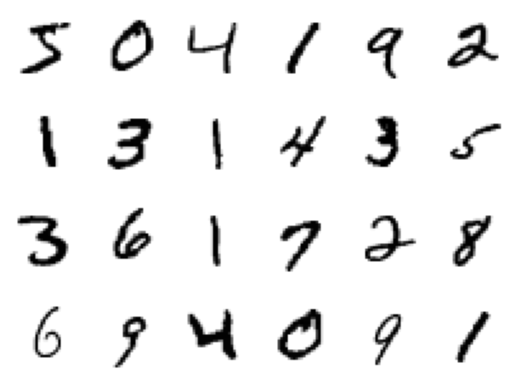

In [9]:
show_digits(4, 6)

Given two arrays $\mathbf{x}$ and $\mathbf{y}$ of the same dimension $n$, the function $\texttt{distance}(\mathbf{x}, \mathbf{y})$ computes the
<em style="color:blue;">Euclidean distance</em> between $\mathbf{x}$ and $\mathbf{y}$.  This distance is defined as follows:
$$ \sqrt{\sum\limits_{i=1}^n (x_i - y_i)^2} $$

In [10]:
def distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

For example, the distance between the first two images of the training set is computed as follows:

In [11]:
distance(X_train[0,:], X_train[1,:])

9.324655

The distance between the 9th and the 15th image should be smaller, because both of these images show the digit $1$ and hence these images are quite similar.
This similarity results in a smaller distance between these images.

In [12]:
distance(X_train[8,:], X_train[14,:])

3.684565

In [13]:
D = {}
D['a'] = 1
D['b'] = 2

D

{'a': 1, 'b': 2}

In [14]:
D['a']

1

In [17]:
D['c'] = 8

In [18]:
D

{'a': 1, 'b': 2, 'c': 8}

Given a list $L$ of digits, the function $\texttt{maxCounts}(L)$ returns a pair $(d, p)$ where $d$ is the digit that occurs most frequently in $L$
and $p$ is the percentage of occurrences of $d$ in $L$.  For example, we have
$$ \texttt{maxCounts}([5,2,3,5,2,5,6,5,7,8]) = (5, 0.4)  $$
because the digit $5$ is the most frequent digit in the list $[5,2,3,5,2,5,6,5,7,8]$ and $40$% of the digits in this list are fives.

In [19]:
def maxCount(L):
    Frequencies         = {}    # number of occurrences for each digit
    most_frequent       = L[0]  # most frequent digit so far
    most_frequent_count = 1     # number of occurrences of most frequent digit
    for d in L:
        if d in Frequencies:
            Frequencies[d] += 1
        else:
            Frequencies[d]  = 1
        if Frequencies[d] > most_frequent_count:
            most_frequent       = d
            most_frequent_count = Frequencies[d]
    return most_frequent, most_frequent_count / len(L)

In [20]:
maxCount([3, 3, 4, 2, 1, 2, 3, 2, 5, 3])

(3, 0.4)

Given an image of a digit stored in the vector $\mathbf{x}$ and a number of neighbours $k$, the function $\texttt{digit}(\mathbf{x}, k)$ computes those
$k$ images in the training set `X_train` that are <em style="color:blue;">closest</em> to the image $\mathbf{x}$.  Here 
<em style="color:blue;">closeness</em> of images is defined in terms of the <em style="color:blue;">Euclidean distance</em> of the vectors that store the 
images.  From these $k$ images of the training set the function chooses the digit that occurs most frequently.  It returns a pair $(d, p)$ where $d$ is the digit that is most frequently occurring in the list of $k$ neighbours and $p$ is the percentage of images in the $k$ neighbours of $\mathbf{x}$ that show
the digit $d$.

In [21]:
def digit(x, k):
    n          = X_train.shape[0]  # number of all training images
    Distances  = [ (distance(X_train[i, :], x), i) for i in range(n)]
    Neighbours = [ Y_train[i] for _, i in sorted(Distances)]
    return maxCount(Neighbours[:k])

The function `show_image(n)` shows the $n^\mathrm{th}$ test image.

In [22]:
def show_image(n):
    image = 1 - X_test[n, :]
    image = np.reshape(image, (28, 28))
    plt.imshow(image, cmap="gray")
    plt.show()

This function performs $k$-nearest neighbour classification for the $n$-th image of the test set.  It also prints the image.

In [23]:
def test(n, k):
    print(f'Testing image {n}:')
    show_image(n)
    d, p = digit(X_test[n, :], k)
    print(f'I believe with a certainty of {p * 100}% that the image shows the digit {d}.')

Testing image 2:


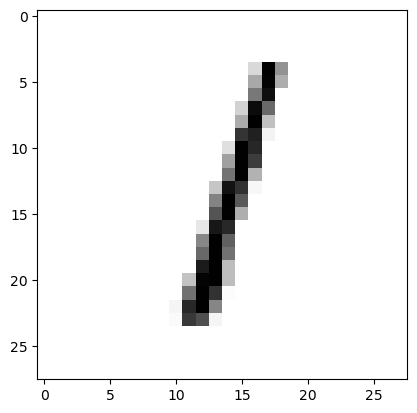

I believe with a certainty of 100.0% that the image shows the digit 1.


In [24]:
test(2, 13)

Let us classify the first 20 images from the test set.

Testing image 0:


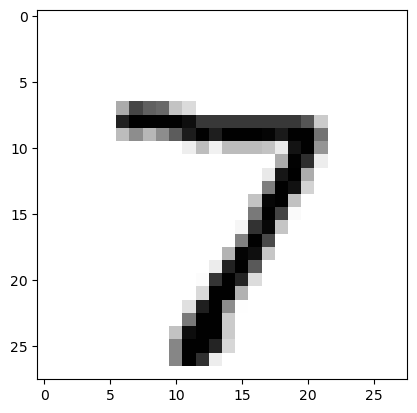

I believe with a certainty of 100.0% that the image shows the digit 7.
Testing image 1:


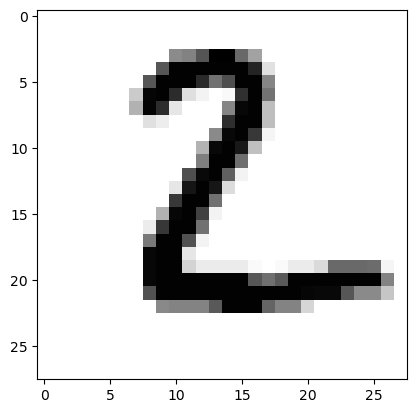

I believe with a certainty of 100.0% that the image shows the digit 2.
Testing image 2:


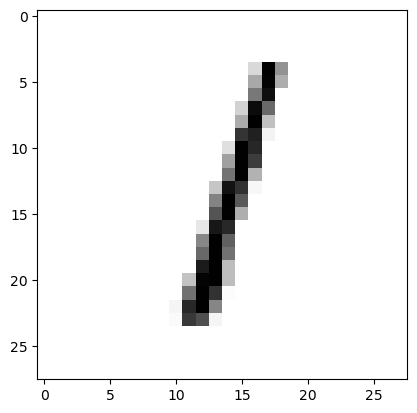

I believe with a certainty of 100.0% that the image shows the digit 1.
Testing image 3:


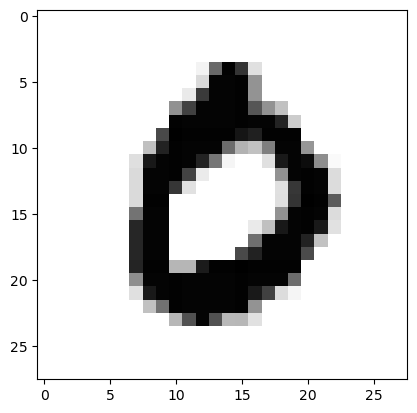

I believe with a certainty of 100.0% that the image shows the digit 0.
Testing image 4:


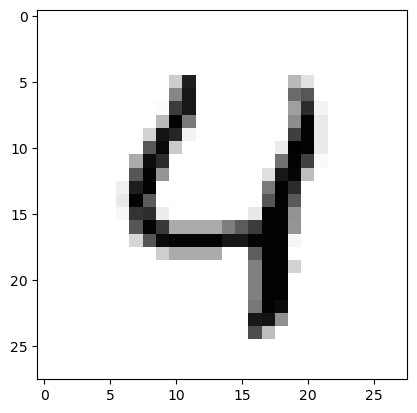

I believe with a certainty of 92.3076923076923% that the image shows the digit 4.
Testing image 5:


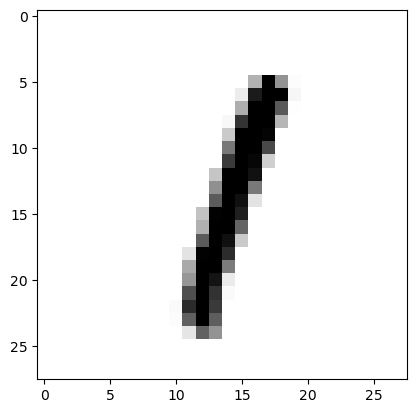

I believe with a certainty of 100.0% that the image shows the digit 1.
Testing image 6:


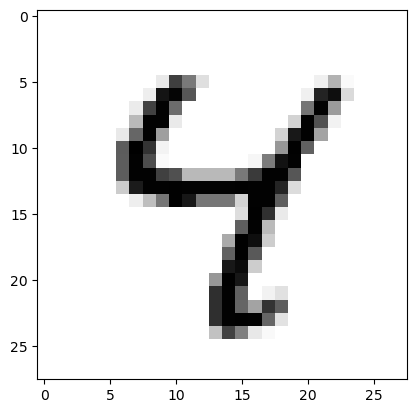

I believe with a certainty of 92.3076923076923% that the image shows the digit 4.
Testing image 7:


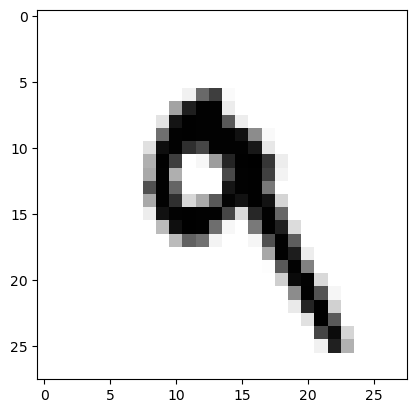

I believe with a certainty of 100.0% that the image shows the digit 9.
Testing image 8:


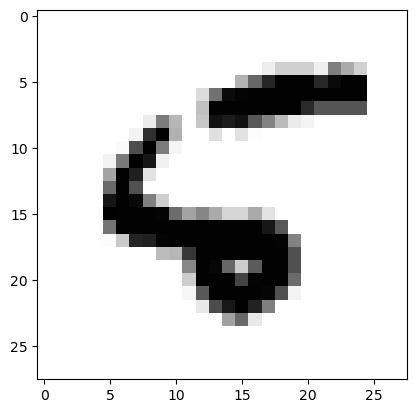

I believe with a certainty of 53.84615384615385% that the image shows the digit 5.
Testing image 9:


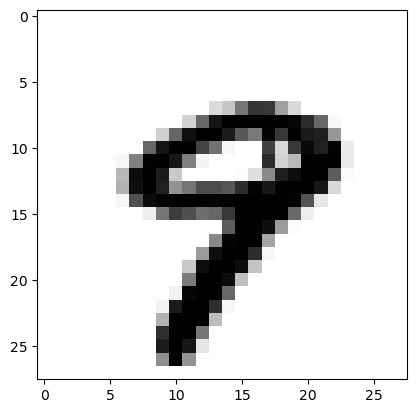

I believe with a certainty of 92.3076923076923% that the image shows the digit 9.
Testing image 10:


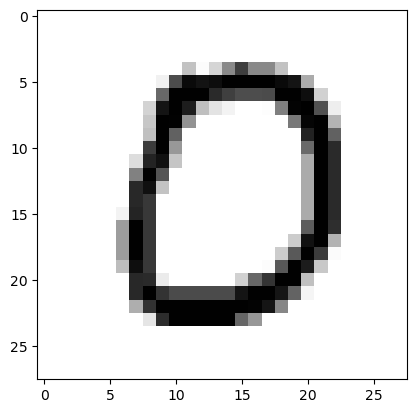

I believe with a certainty of 100.0% that the image shows the digit 0.
Testing image 11:


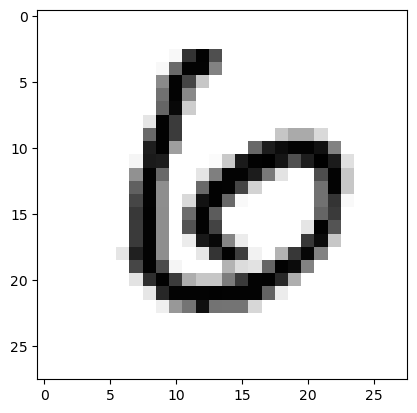

I believe with a certainty of 100.0% that the image shows the digit 6.
Testing image 12:


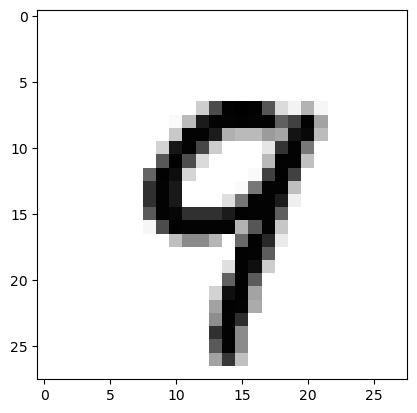

I believe with a certainty of 100.0% that the image shows the digit 9.
Testing image 13:


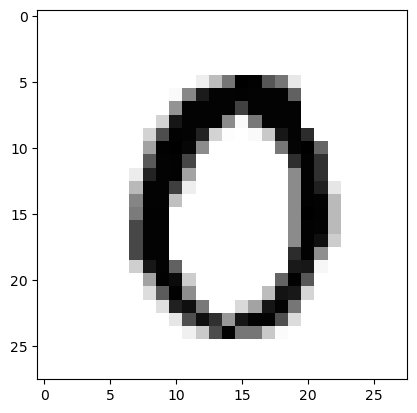

I believe with a certainty of 100.0% that the image shows the digit 0.
Testing image 14:


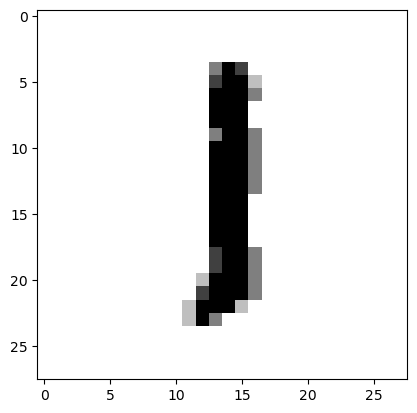

I believe with a certainty of 100.0% that the image shows the digit 1.
Testing image 15:


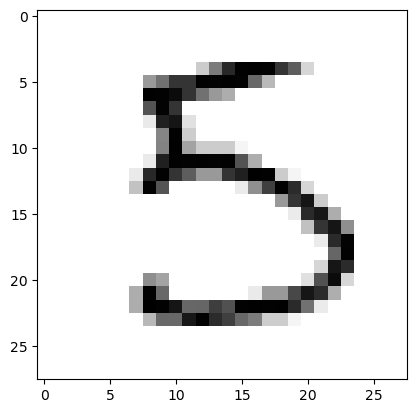

I believe with a certainty of 84.61538461538461% that the image shows the digit 5.
Testing image 16:


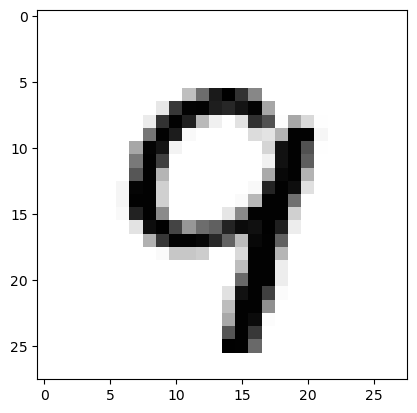

I believe with a certainty of 92.3076923076923% that the image shows the digit 9.
Testing image 17:


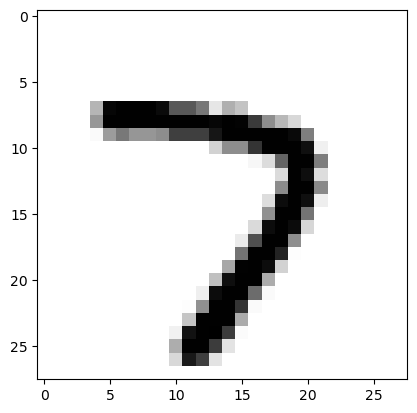

I believe with a certainty of 100.0% that the image shows the digit 7.
Testing image 18:


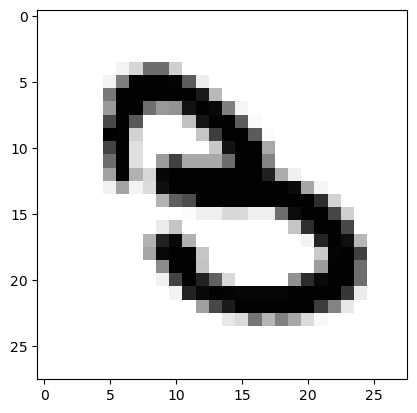

I believe with a certainty of 100.0% that the image shows the digit 3.
Testing image 19:


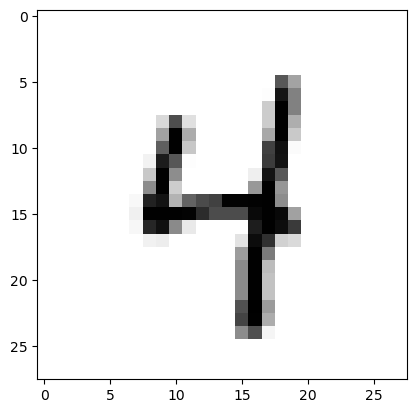

I believe with a certainty of 100.0% that the image shows the digit 4.
CPU times: user 48.7 s, sys: 2.73 s, total: 51.4 s
Wall time: 11.5 s


In [25]:
%%time
for n in range(20):
    test(n, 13)

Let us check how much memory is used at the moment.  The function call below prints all the memory of our machine that is currently used.

In [26]:
def check(n, k):
    d, p = digit(X_test[n, :], k)
    if d == Y_test[n]:
        return 0
    else:
        print(f"\nImage number {n} wrongly identified: I guessed a {d}, but it's a {Y_test[n]}.")
        show_image(n)
        return 1


Image number 43 wrongly identified: I guessed a 1, but it's a 2.


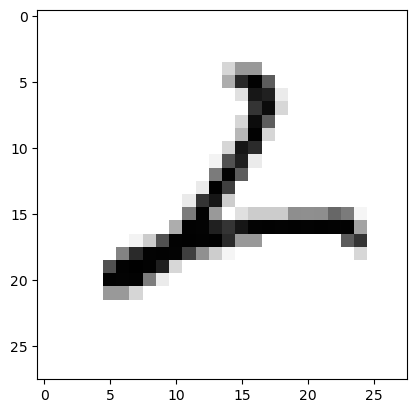


Image number 77 wrongly identified: I guessed a 7, but it's a 2.


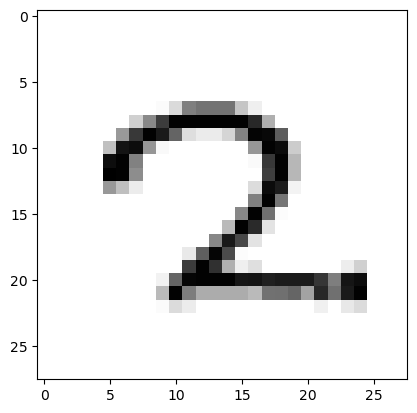


Image number 115 wrongly identified: I guessed a 9, but it's a 4.


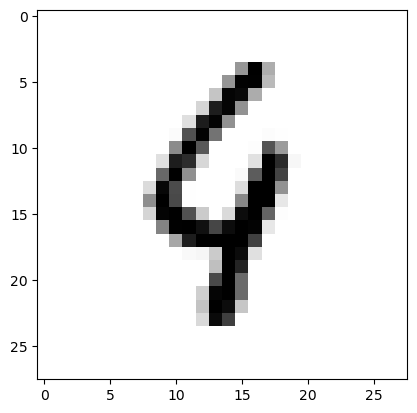


Image number 195 wrongly identified: I guessed a 1, but it's a 3.


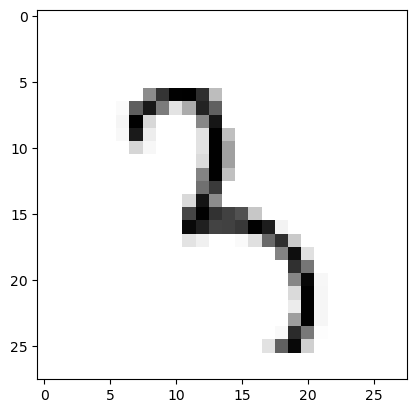


Image number 241 wrongly identified: I guessed a 8, but it's a 9.


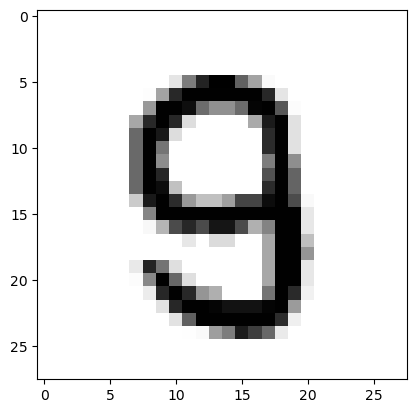


Image number 247 wrongly identified: I guessed a 6, but it's a 4.


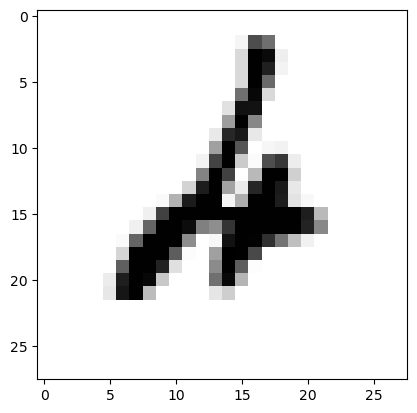


Image number 300 wrongly identified: I guessed a 1, but it's a 4.


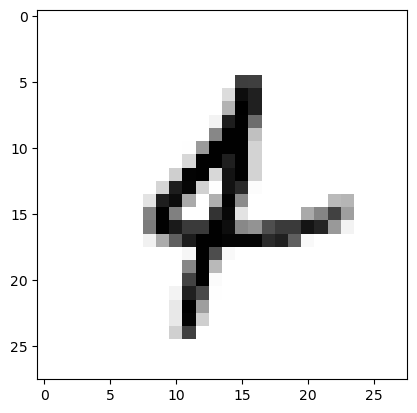


Image number 318 wrongly identified: I guessed a 0, but it's a 2.


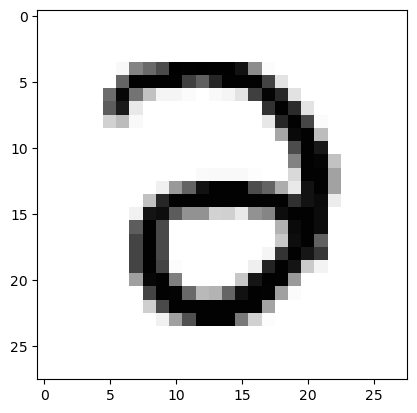


Image number 320 wrongly identified: I guessed a 7, but it's a 9.


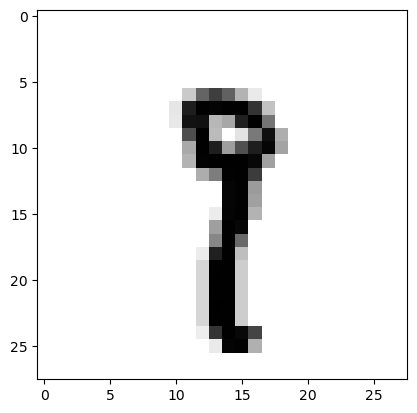


Image number 321 wrongly identified: I guessed a 7, but it's a 2.


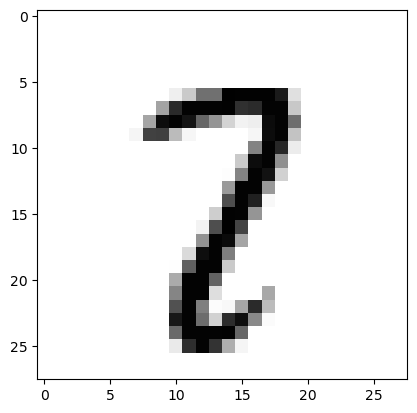


Image number 341 wrongly identified: I guessed a 4, but it's a 6.


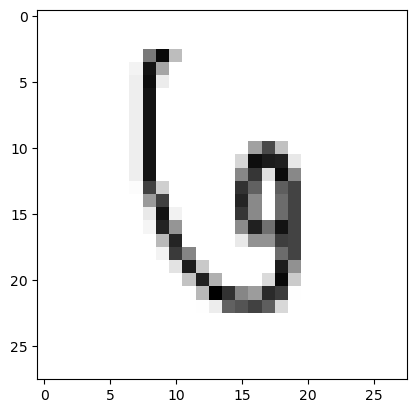


Image number 358 wrongly identified: I guessed a 4, but it's a 7.


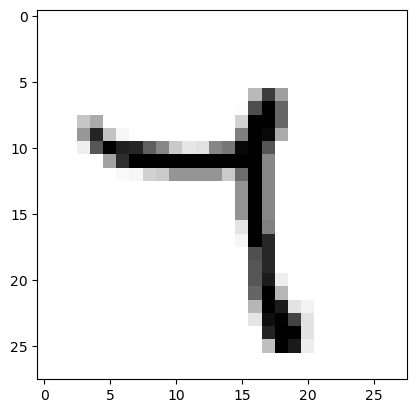


Image number 376 wrongly identified: I guessed a 9, but it's a 4.


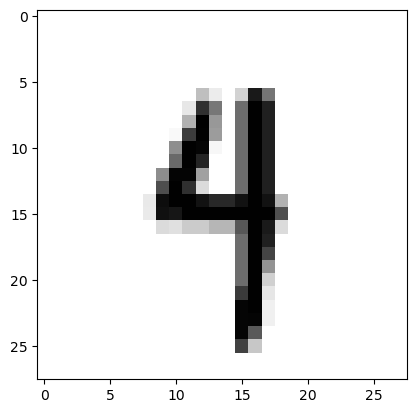


Image number 381 wrongly identified: I guessed a 7, but it's a 3.


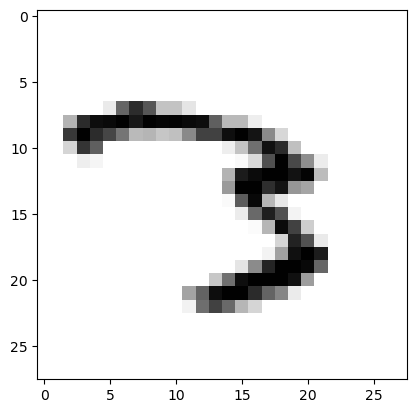


Image number 444 wrongly identified: I guessed a 8, but it's a 2.


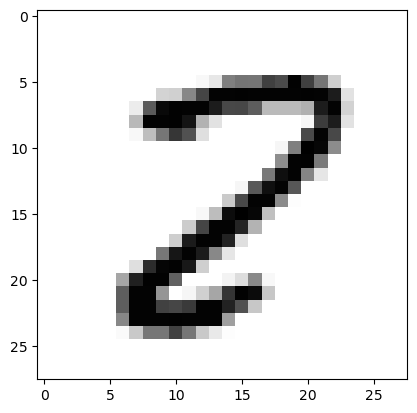


Image number 445 wrongly identified: I guessed a 0, but it's a 6.


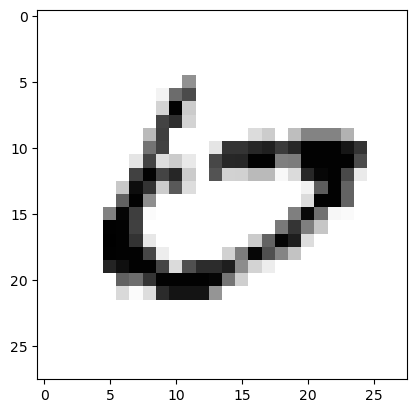


Image number 464 wrongly identified: I guessed a 7, but it's a 3.


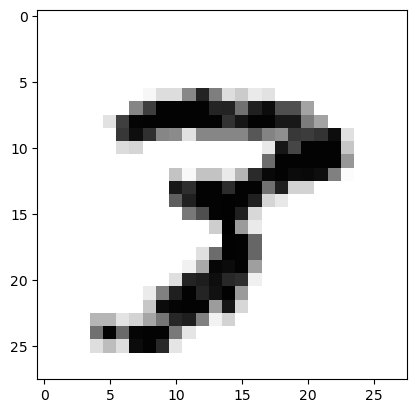


Image number 495 wrongly identified: I guessed a 0, but it's a 8.


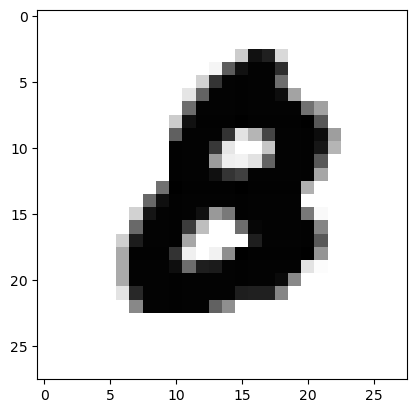


Image number 542 wrongly identified: I guessed a 1, but it's a 8.


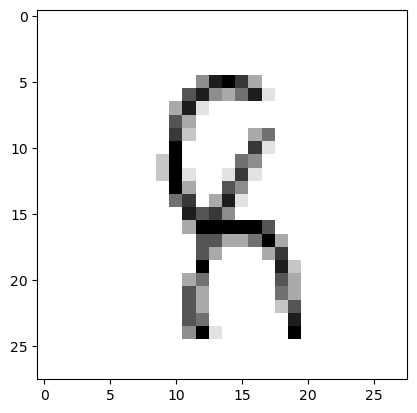


Image number 551 wrongly identified: I guessed a 1, but it's a 7.


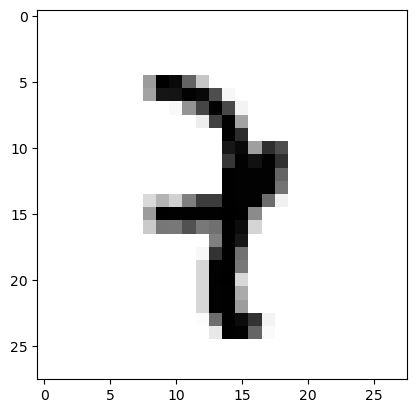


Image number 565 wrongly identified: I guessed a 9, but it's a 4.


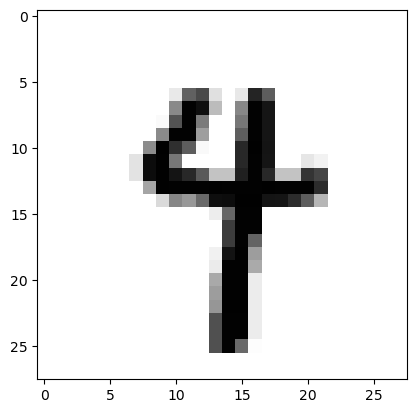


Image number 578 wrongly identified: I guessed a 8, but it's a 3.


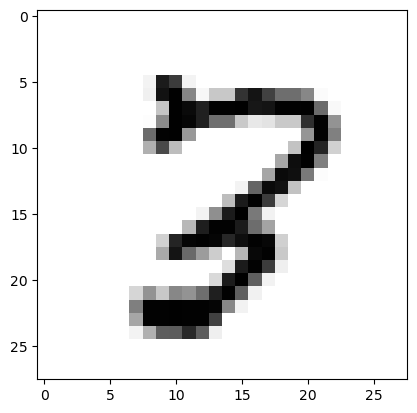


Image number 582 wrongly identified: I guessed a 3, but it's a 8.


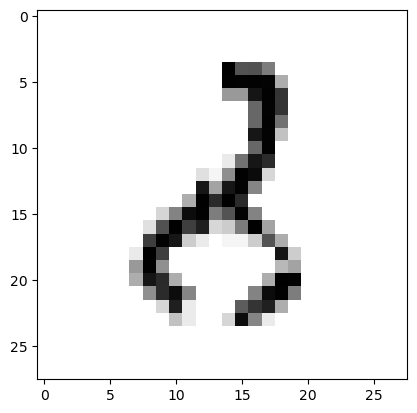


Image number 583 wrongly identified: I guessed a 7, but it's a 2.


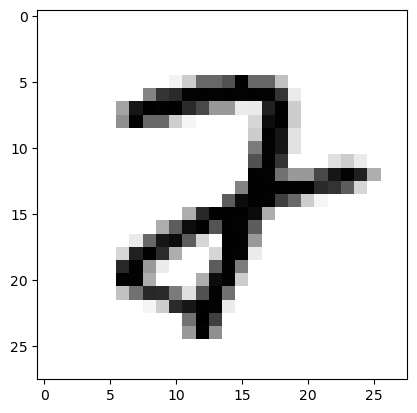


Image number 628 wrongly identified: I guessed a 9, but it's a 3.


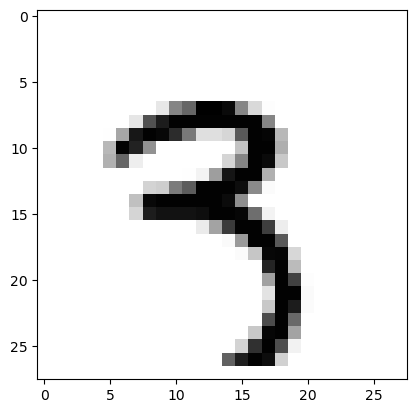


Image number 635 wrongly identified: I guessed a 1, but it's a 2.


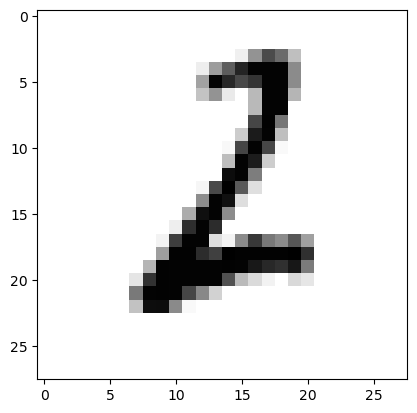


Image number 646 wrongly identified: I guessed a 6, but it's a 2.


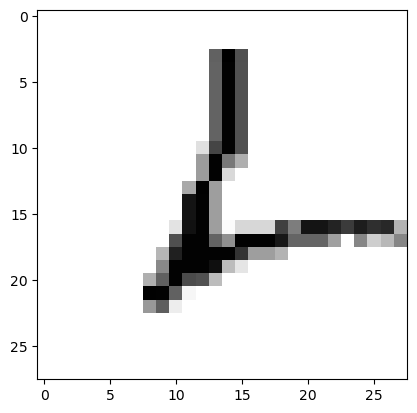


Image number 659 wrongly identified: I guessed a 7, but it's a 2.


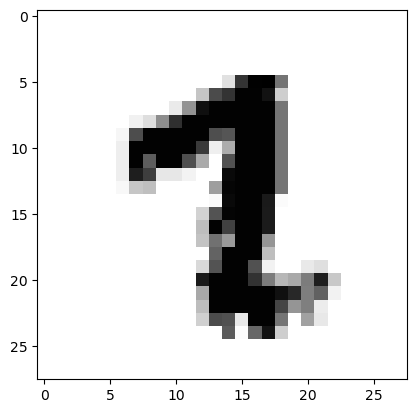


Image number 691 wrongly identified: I guessed a 4, but it's a 8.


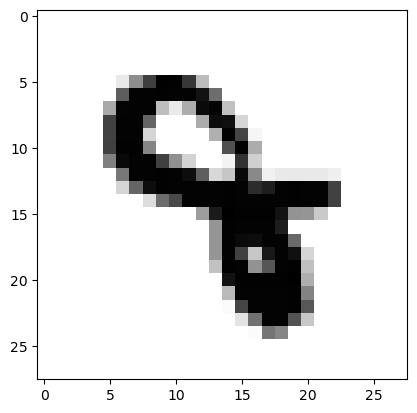


Image number 707 wrongly identified: I guessed a 9, but it's a 4.


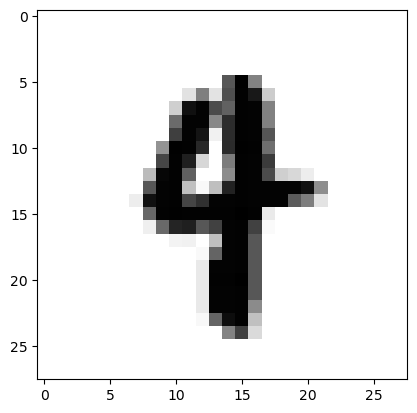


Image number 714 wrongly identified: I guessed a 5, but it's a 8.


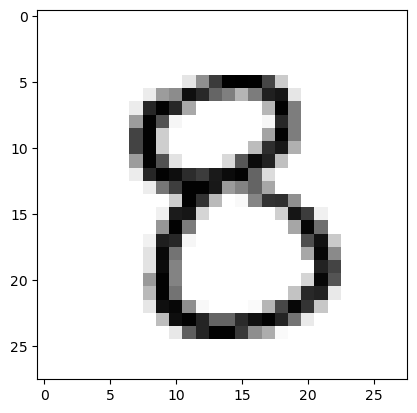


Image number 740 wrongly identified: I guessed a 9, but it's a 4.


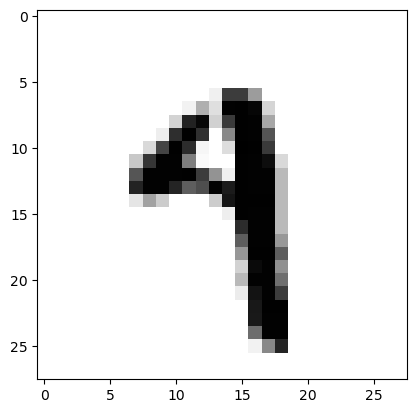


Image number 760 wrongly identified: I guessed a 9, but it's a 4.


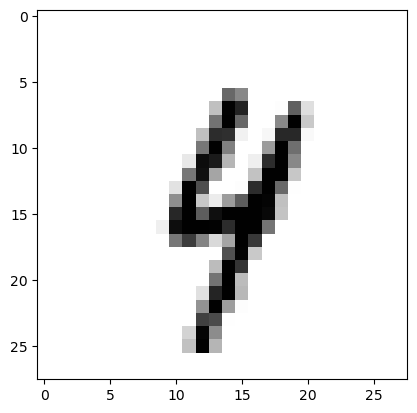


Image number 791 wrongly identified: I guessed a 9, but it's a 5.


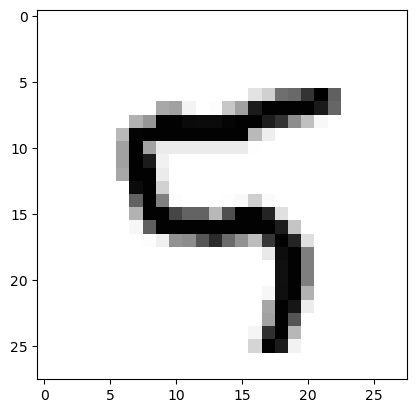


Image number 839 wrongly identified: I guessed a 3, but it's a 8.


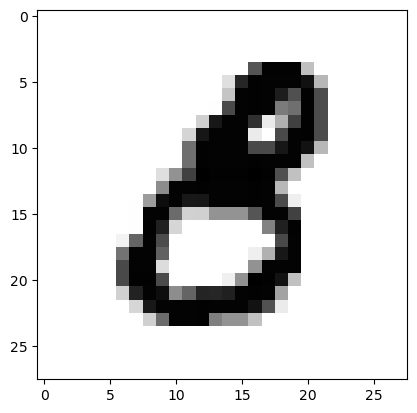


Image number 844 wrongly identified: I guessed a 3, but it's a 8.


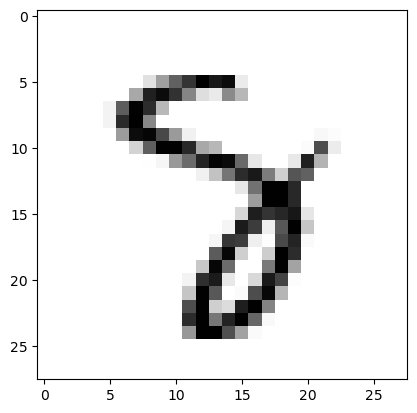


Image number 924 wrongly identified: I guessed a 7, but it's a 2.


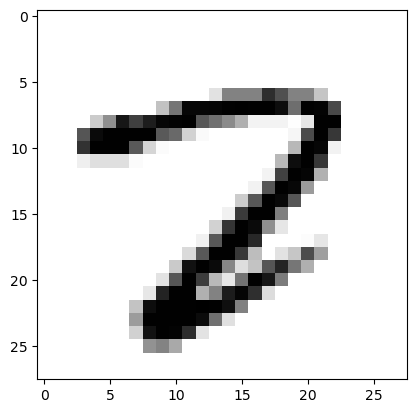


Image number 936 wrongly identified: I guessed a 5, but it's a 8.


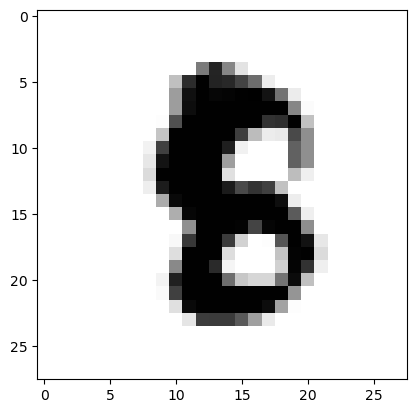


Image number 938 wrongly identified: I guessed a 5, but it's a 3.


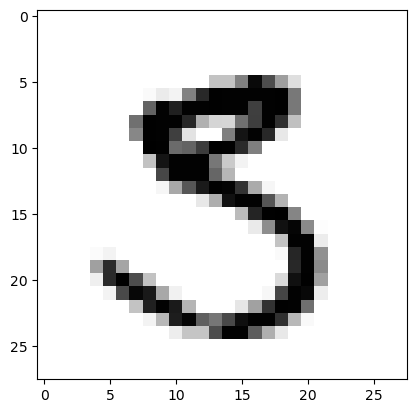


Image number 939 wrongly identified: I guessed a 0, but it's a 2.


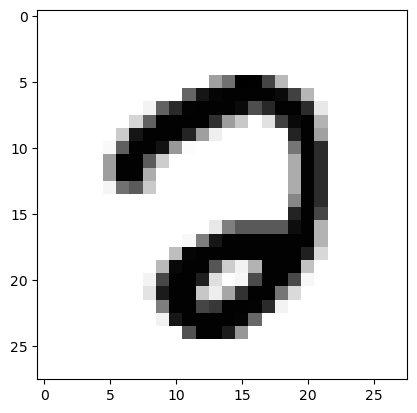


Image number 947 wrongly identified: I guessed a 9, but it's a 8.


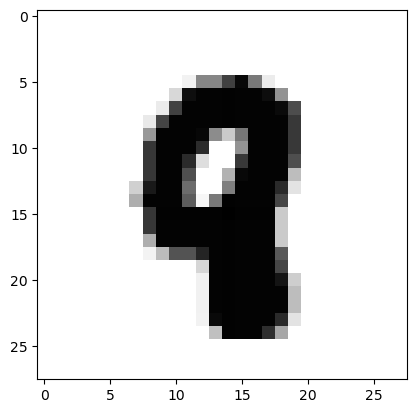


Image number 951 wrongly identified: I guessed a 4, but it's a 5.


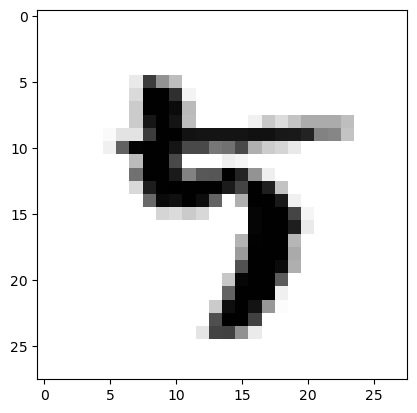


Image number 957 wrongly identified: I guessed a 5, but it's a 3.


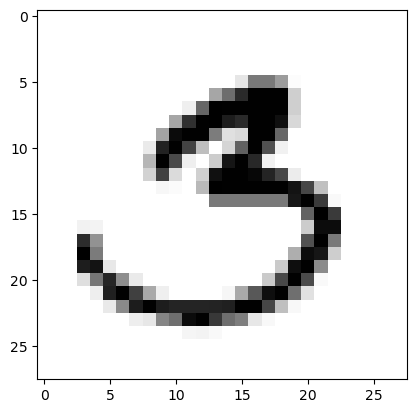


Image number 1003 wrongly identified: I guessed a 3, but it's a 5.


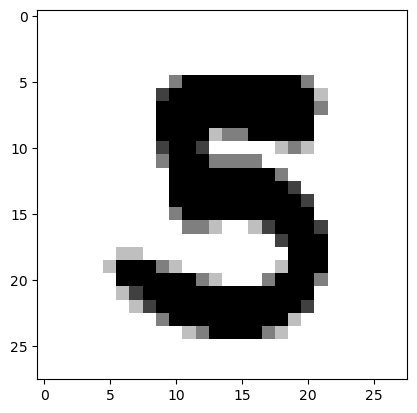


Image number 1014 wrongly identified: I guessed a 5, but it's a 6.


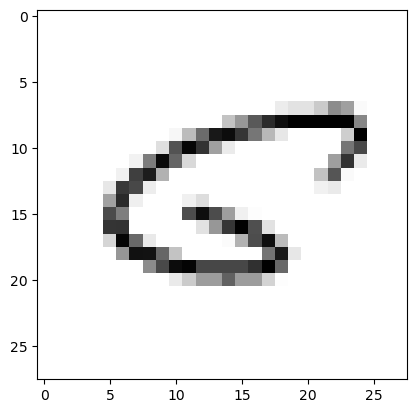


Image number 1039 wrongly identified: I guessed a 1, but it's a 7.


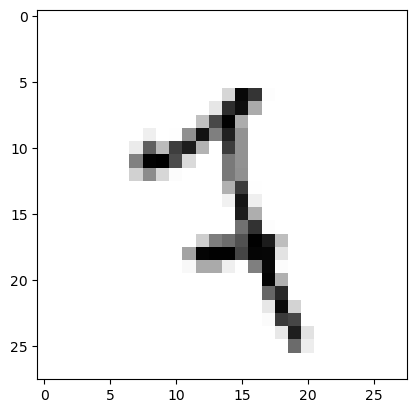


Image number 1062 wrongly identified: I guessed a 7, but it's a 3.


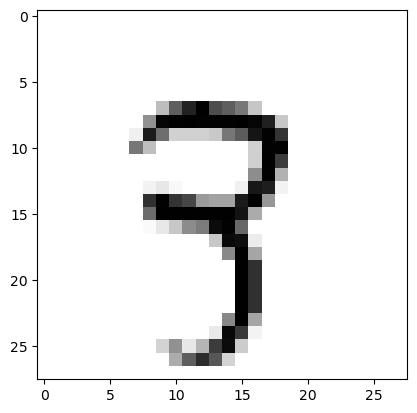


Image number 1068 wrongly identified: I guessed a 4, but it's a 8.


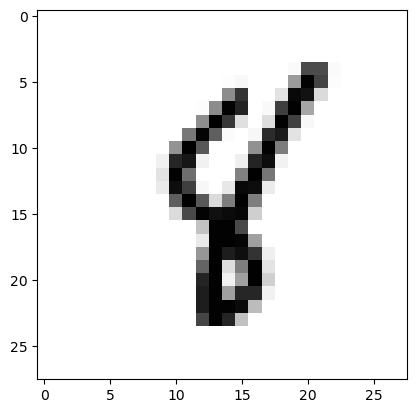


Image number 1107 wrongly identified: I guessed a 8, but it's a 9.


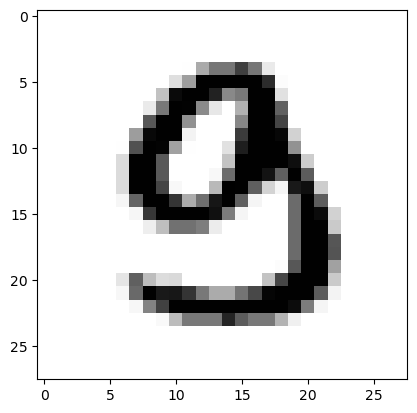


Image number 1112 wrongly identified: I guessed a 6, but it's a 4.


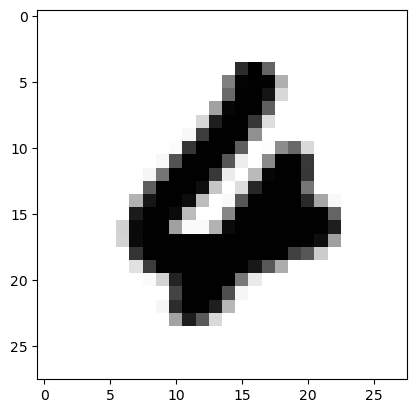


Image number 1181 wrongly identified: I guessed a 1, but it's a 6.


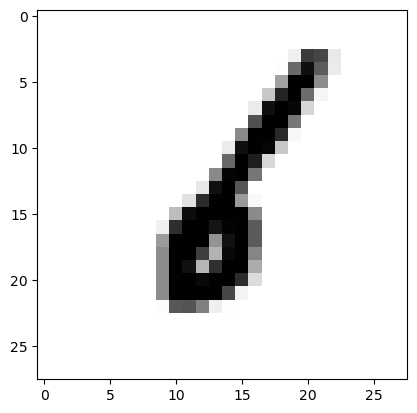


Image number 1184 wrongly identified: I guessed a 1, but it's a 2.


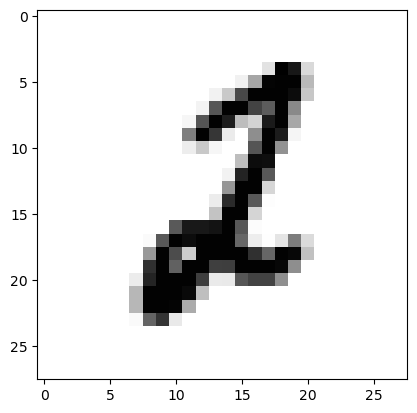


Image number 1192 wrongly identified: I guessed a 4, but it's a 9.


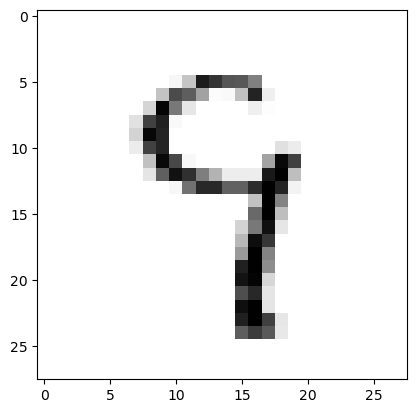


Image number 1202 wrongly identified: I guessed a 5, but it's a 8.


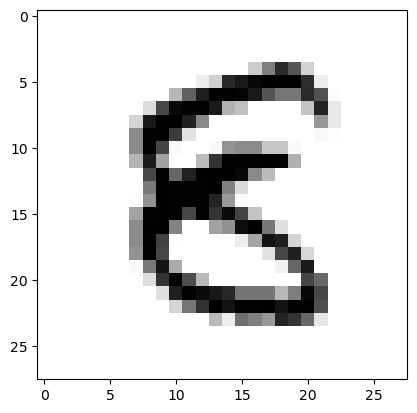


Image number 1226 wrongly identified: I guessed a 2, but it's a 7.


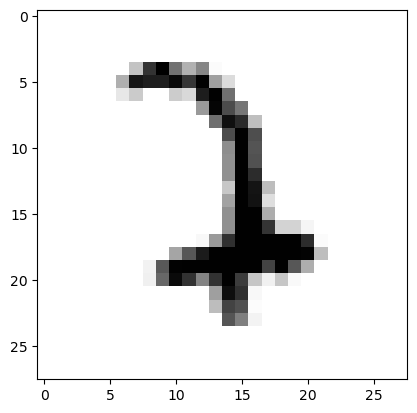


Image number 1242 wrongly identified: I guessed a 9, but it's a 4.


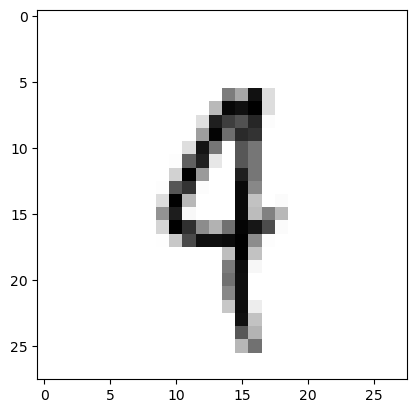


Image number 1247 wrongly identified: I guessed a 0, but it's a 9.


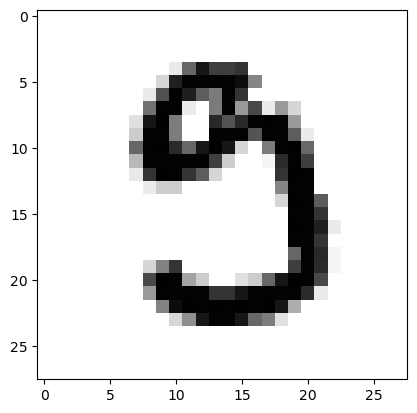


Image number 1260 wrongly identified: I guessed a 1, but it's a 7.


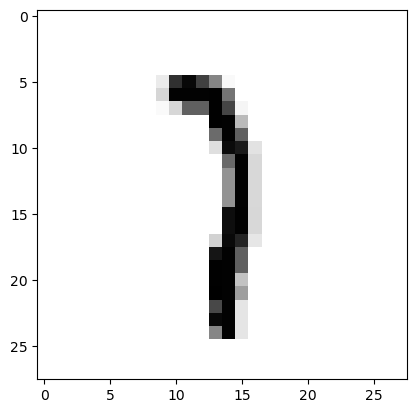


Image number 1283 wrongly identified: I guessed a 1, but it's a 7.


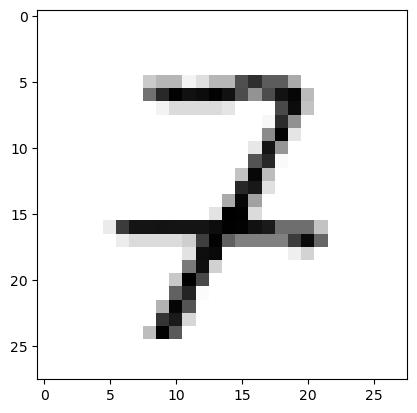


Image number 1289 wrongly identified: I guessed a 9, but it's a 5.


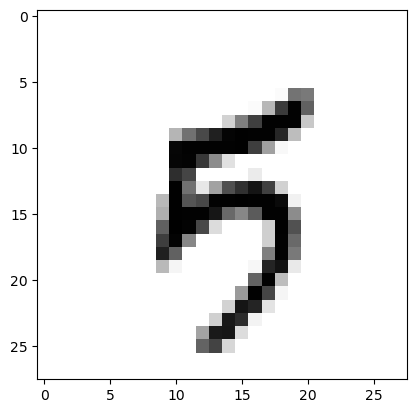


Image number 1299 wrongly identified: I guessed a 7, but it's a 5.


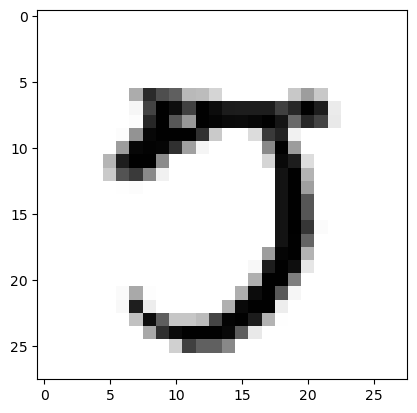


Image number 1319 wrongly identified: I guessed a 3, but it's a 8.


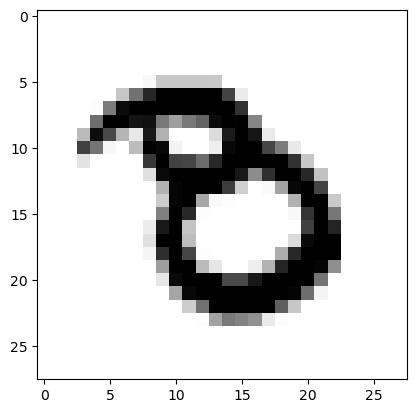


Image number 1326 wrongly identified: I guessed a 1, but it's a 7.


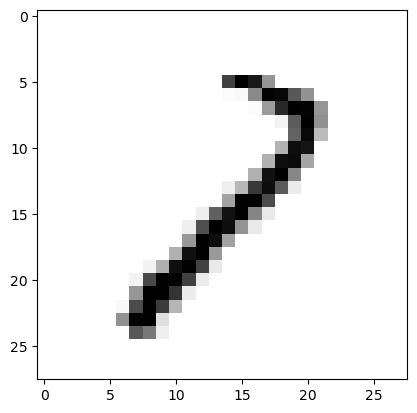


Image number 1356 wrongly identified: I guessed a 8, but it's a 2.


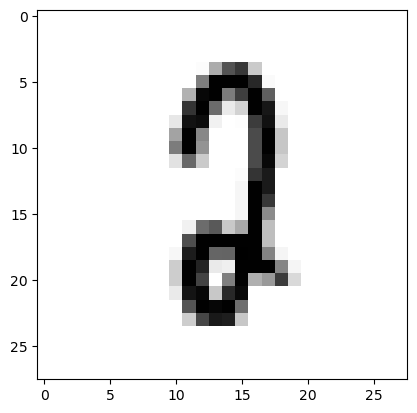


Image number 1364 wrongly identified: I guessed a 3, but it's a 8.


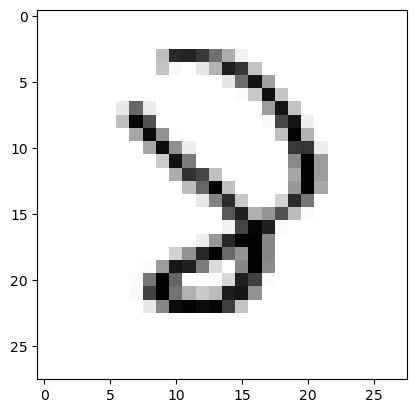


Image number 1378 wrongly identified: I guessed a 6, but it's a 5.


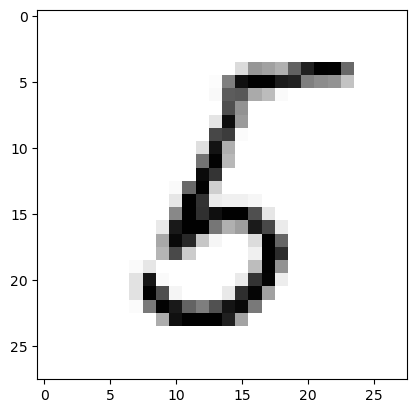


Image number 1393 wrongly identified: I guessed a 3, but it's a 5.


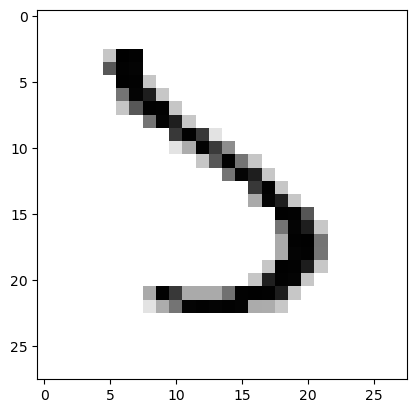


Image number 1425 wrongly identified: I guessed a 9, but it's a 8.


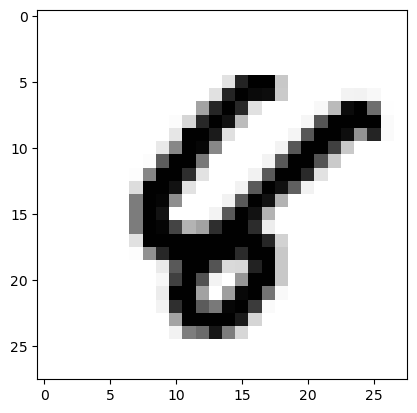


Image number 1465 wrongly identified: I guessed a 1, but it's a 4.


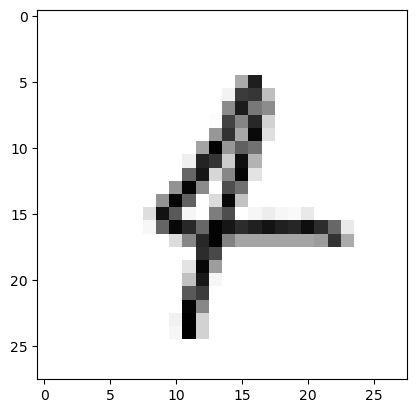


Image number 1500 wrongly identified: I guessed a 1, but it's a 7.


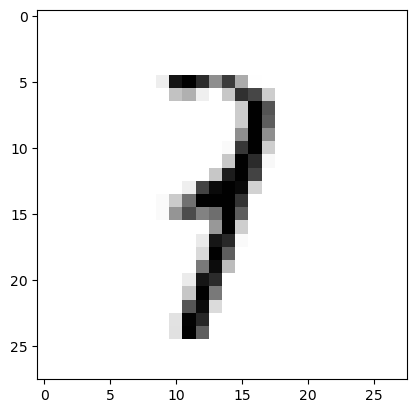


Image number 1522 wrongly identified: I guessed a 9, but it's a 7.


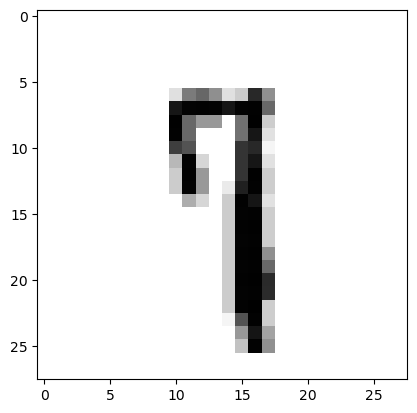


Image number 1523 wrongly identified: I guessed a 5, but it's a 8.


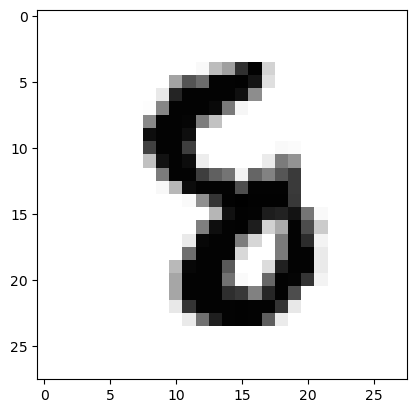


Image number 1530 wrongly identified: I guessed a 7, but it's a 8.


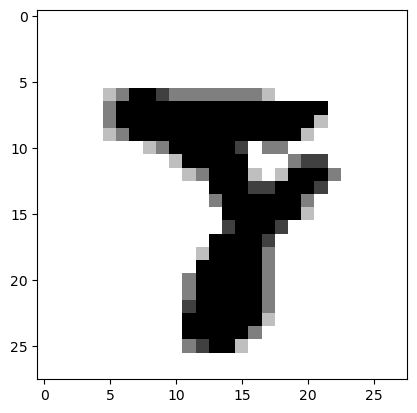


Image number 1549 wrongly identified: I guessed a 6, but it's a 4.


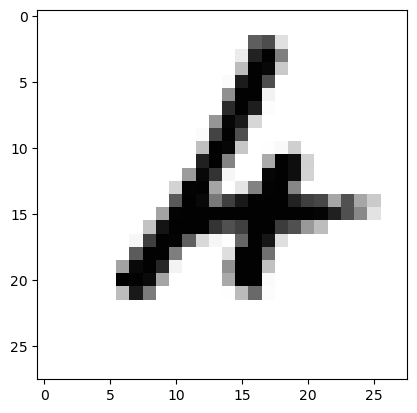


Image number 1553 wrongly identified: I guessed a 3, but it's a 9.


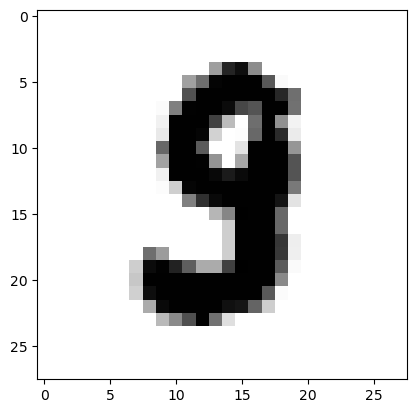


Image number 1559 wrongly identified: I guessed a 3, but it's a 9.


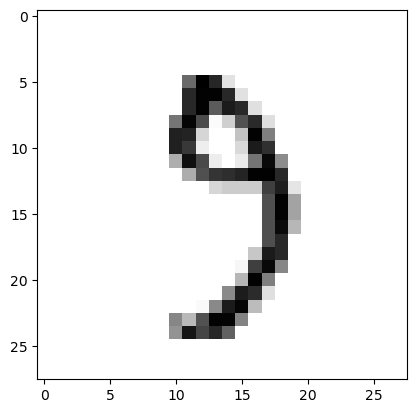


Image number 1681 wrongly identified: I guessed a 7, but it's a 3.


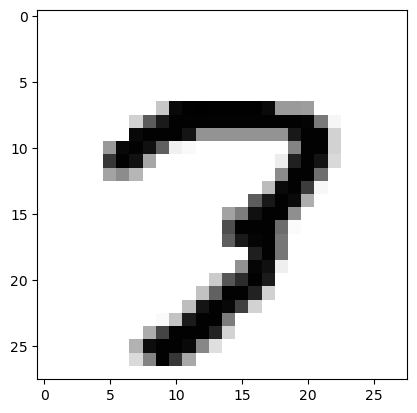


Image number 1701 wrongly identified: I guessed a 9, but it's a 4.


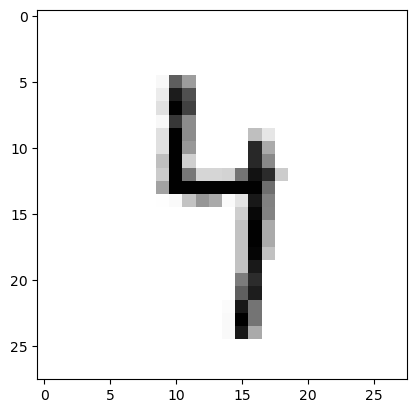


Image number 1709 wrongly identified: I guessed a 3, but it's a 9.


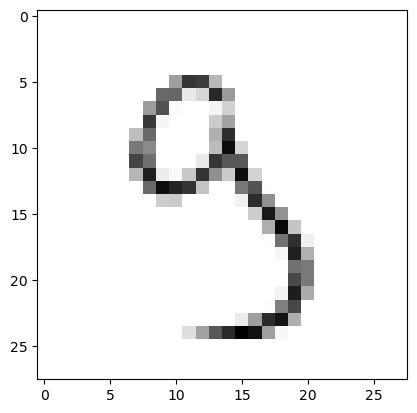


Image number 1716 wrongly identified: I guessed a 1, but it's a 7.


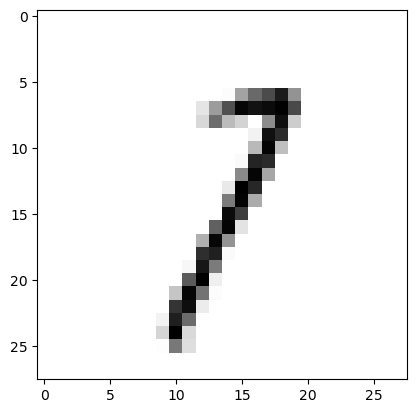


Image number 1717 wrongly identified: I guessed a 0, but it's a 8.


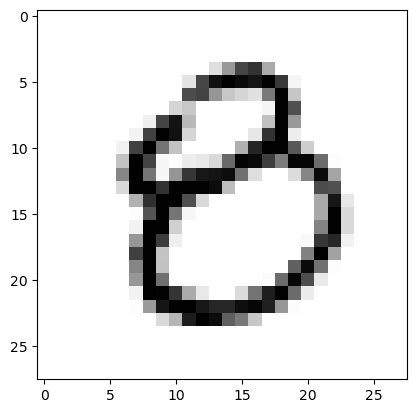


Image number 1721 wrongly identified: I guessed a 9, but it's a 7.


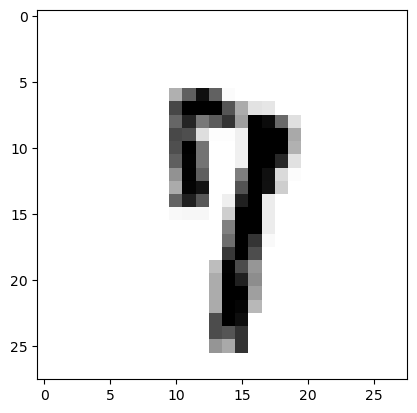


Image number 1737 wrongly identified: I guessed a 3, but it's a 5.


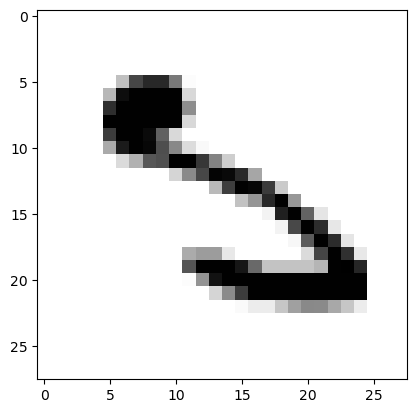


Image number 1754 wrongly identified: I guessed a 1, but it's a 7.


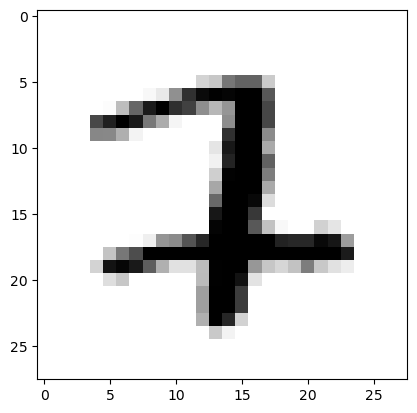


Image number 1782 wrongly identified: I guessed a 4, but it's a 8.


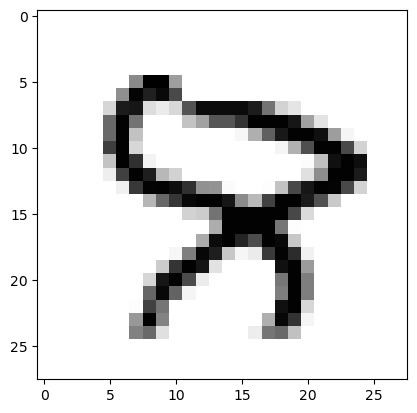


Image number 1790 wrongly identified: I guessed a 7, but it's a 2.


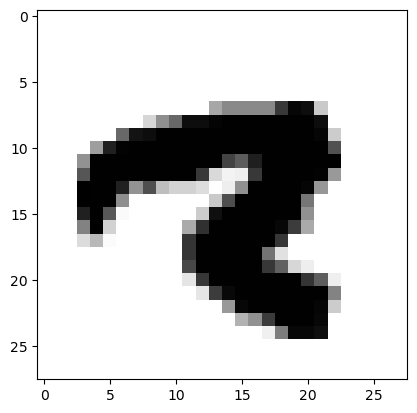


Image number 1813 wrongly identified: I guessed a 5, but it's a 8.


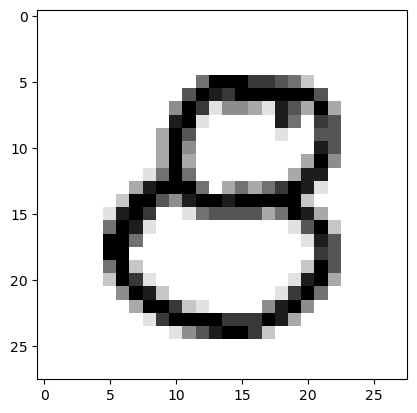


Image number 1823 wrongly identified: I guessed a 4, but it's a 8.


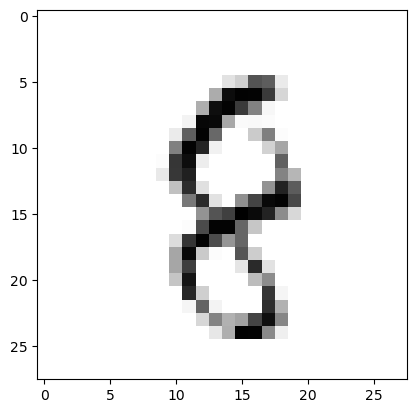


Image number 1850 wrongly identified: I guessed a 7, but it's a 8.


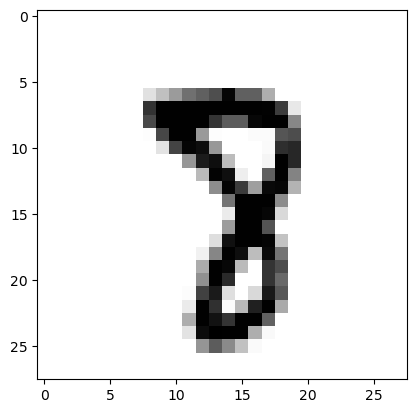


Image number 1865 wrongly identified: I guessed a 9, but it's a 4.


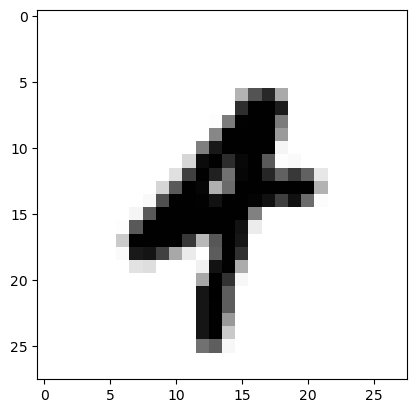


Image number 1878 wrongly identified: I guessed a 3, but it's a 8.


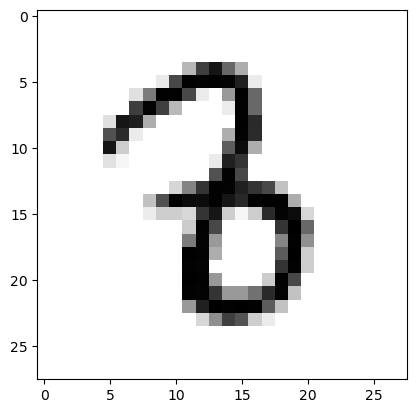


Image number 1901 wrongly identified: I guessed a 4, but it's a 9.


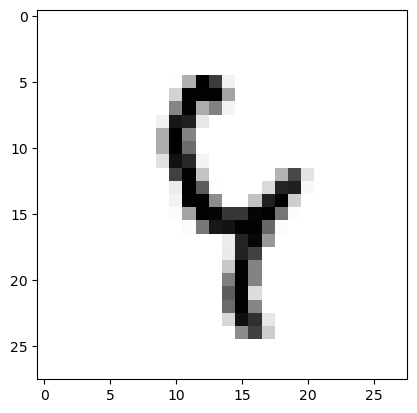


Image number 1955 wrongly identified: I guessed a 2, but it's a 8.


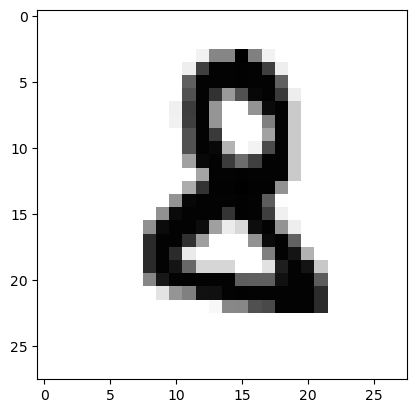


Image number 1968 wrongly identified: I guessed a 1, but it's a 8.


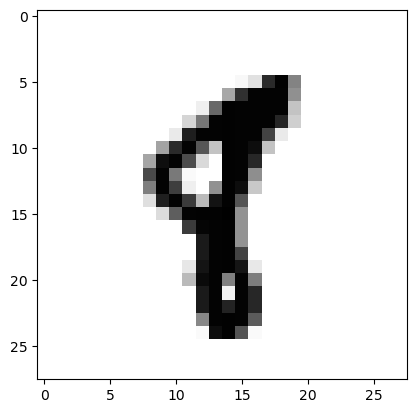


Image number 1970 wrongly identified: I guessed a 3, but it's a 5.


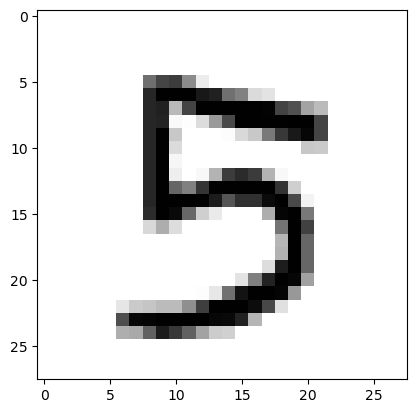


Image number 1984 wrongly identified: I guessed a 0, but it's a 2.


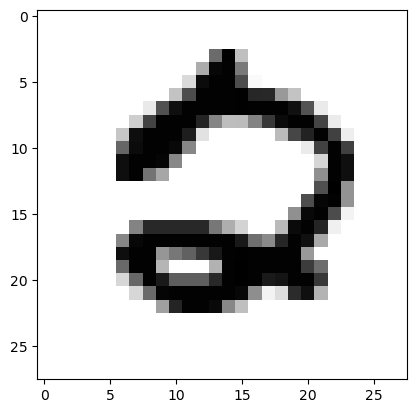


Image number 2043 wrongly identified: I guessed a 8, but it's a 4.


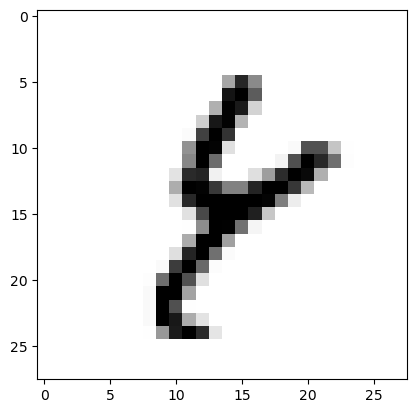


Image number 2044 wrongly identified: I guessed a 7, but it's a 2.


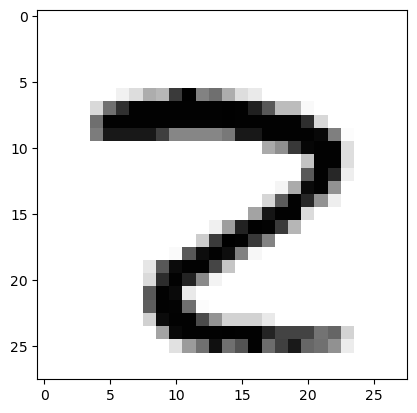


Image number 2052 wrongly identified: I guessed a 4, but it's a 8.


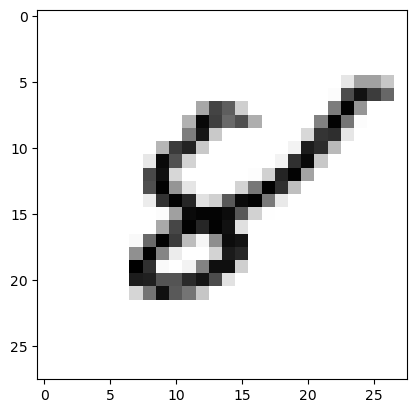


Image number 2053 wrongly identified: I guessed a 9, but it's a 4.


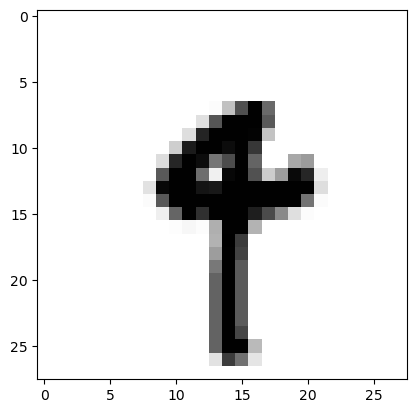


Image number 2063 wrongly identified: I guessed a 1, but it's a 7.


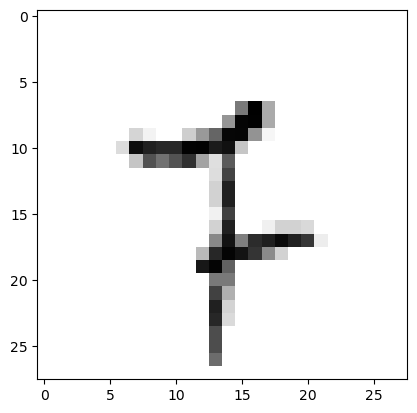


Image number 2093 wrongly identified: I guessed a 1, but it's a 8.


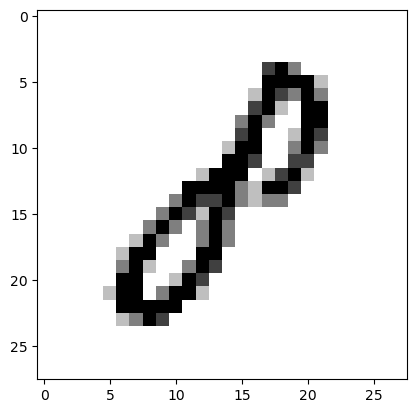


Image number 2098 wrongly identified: I guessed a 0, but it's a 2.


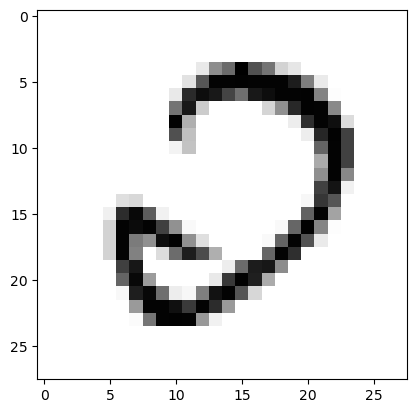


Image number 2109 wrongly identified: I guessed a 4, but it's a 3.


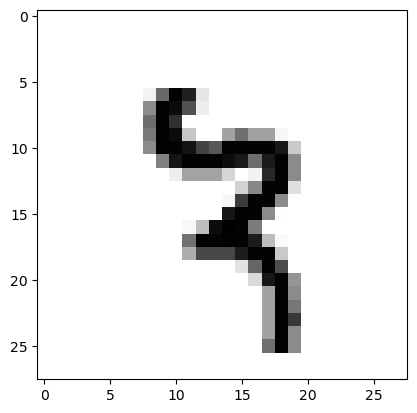


Image number 2118 wrongly identified: I guessed a 0, but it's a 6.


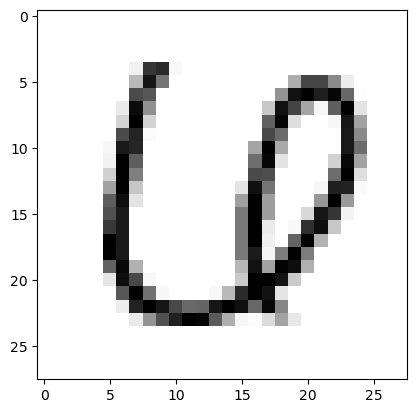


Image number 2129 wrongly identified: I guessed a 2, but it's a 9.


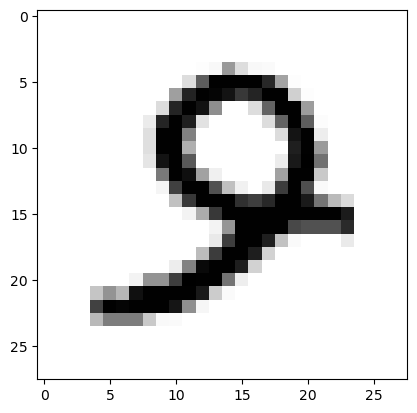


Image number 2130 wrongly identified: I guessed a 9, but it's a 4.


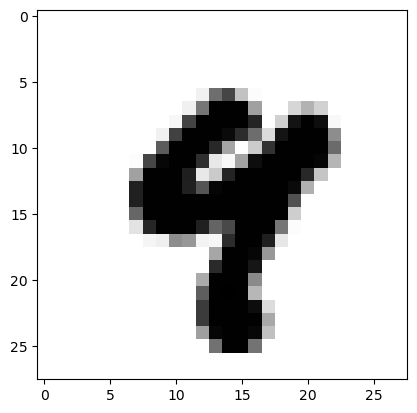


Image number 2135 wrongly identified: I guessed a 1, but it's a 6.


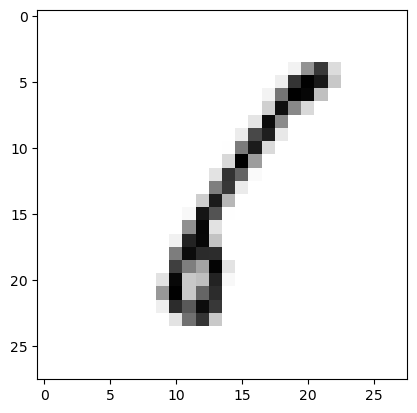


Image number 2168 wrongly identified: I guessed a 2, but it's a 8.


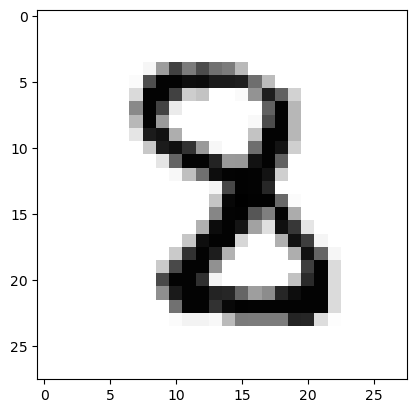


Image number 2177 wrongly identified: I guessed a 3, but it's a 8.


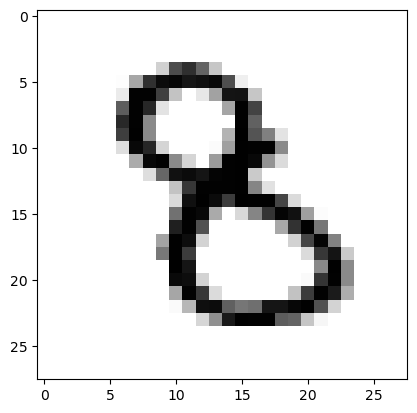


Image number 2182 wrongly identified: I guessed a 2, but it's a 1.


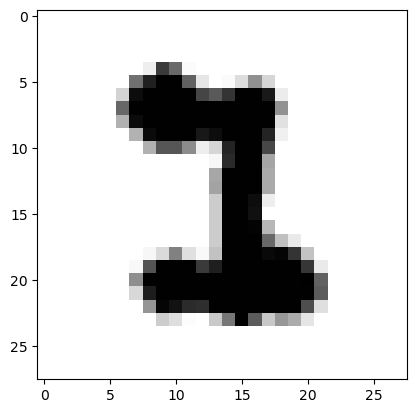


Image number 2197 wrongly identified: I guessed a 1, but it's a 4.


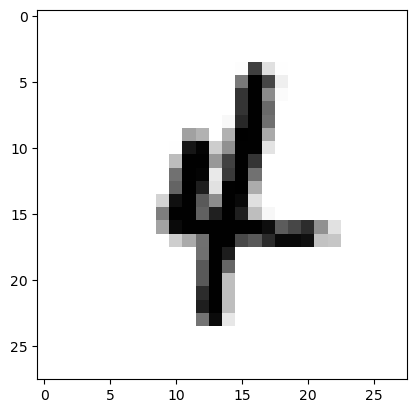


Image number 2224 wrongly identified: I guessed a 6, but it's a 5.


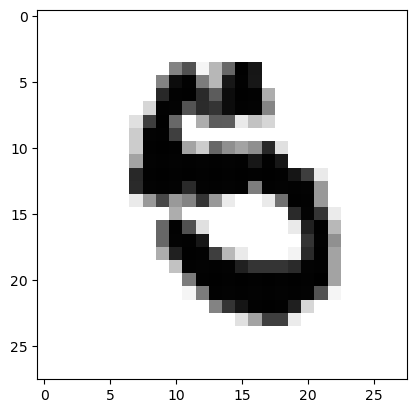


Image number 2237 wrongly identified: I guessed a 8, but it's a 5.


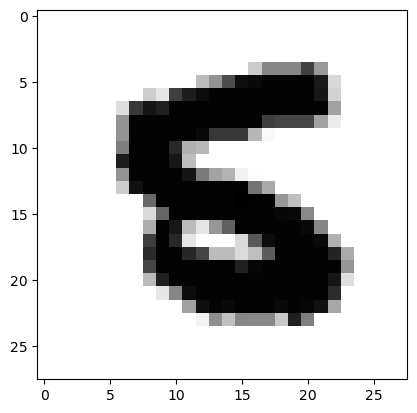


Image number 2293 wrongly identified: I guessed a 6, but it's a 9.


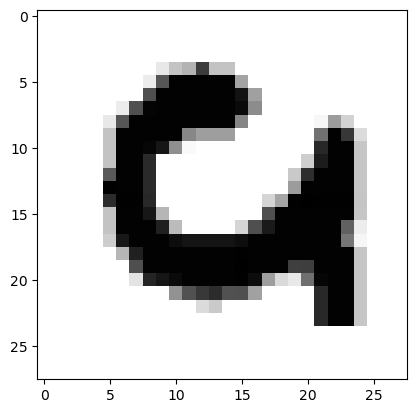


Image number 2299 wrongly identified: I guessed a 7, but it's a 2.


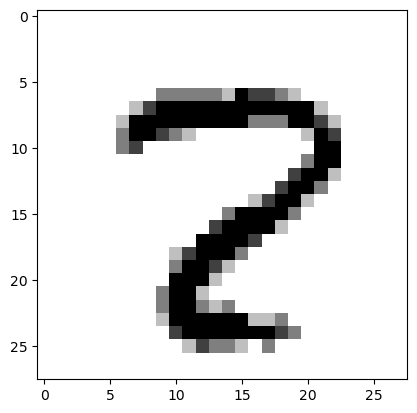


Image number 2325 wrongly identified: I guessed a 1, but it's a 7.


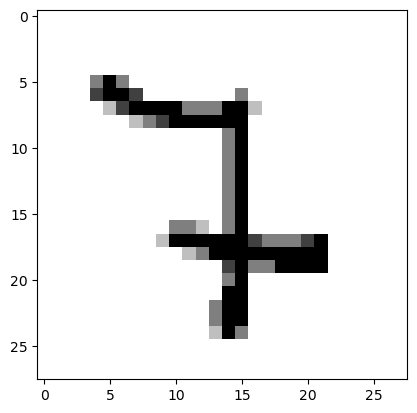


Image number 2339 wrongly identified: I guessed a 8, but it's a 5.


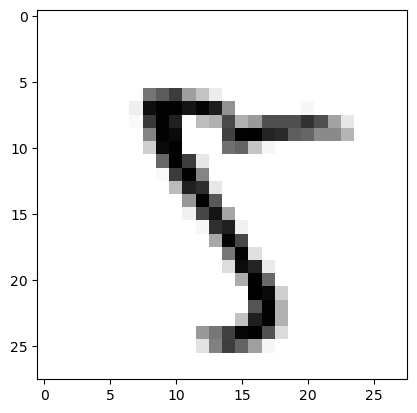


Image number 2371 wrongly identified: I guessed a 9, but it's a 4.


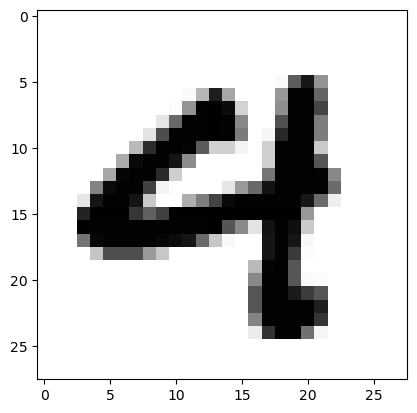


Image number 2387 wrongly identified: I guessed a 1, but it's a 9.


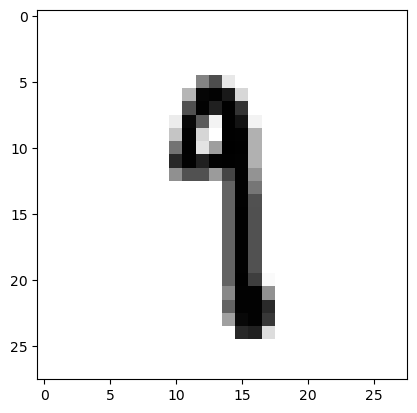


Image number 2393 wrongly identified: I guessed a 3, but it's a 8.


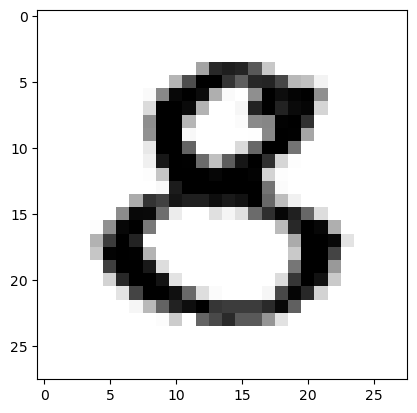


Image number 2395 wrongly identified: I guessed a 3, but it's a 8.


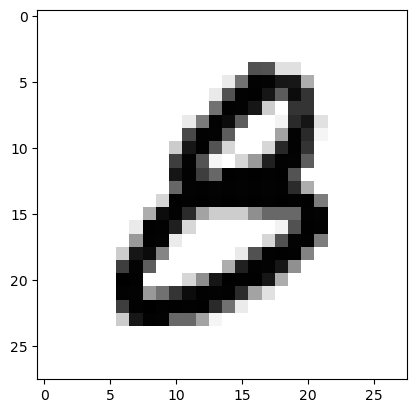


Image number 2406 wrongly identified: I guessed a 1, but it's a 9.


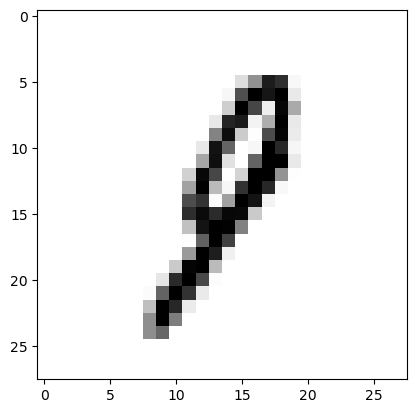


Image number 2437 wrongly identified: I guessed a 1, but it's a 2.


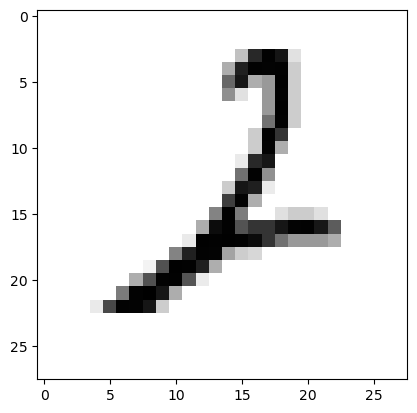


Image number 2447 wrongly identified: I guessed a 9, but it's a 4.


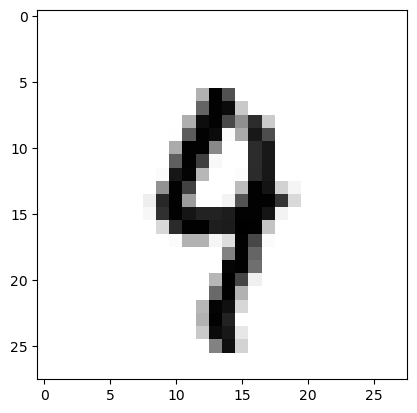


Image number 2454 wrongly identified: I guessed a 5, but it's a 6.


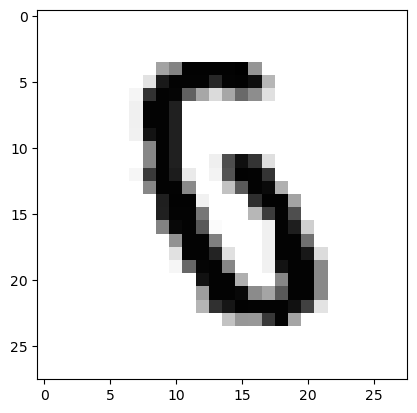


Image number 2462 wrongly identified: I guessed a 0, but it's a 2.


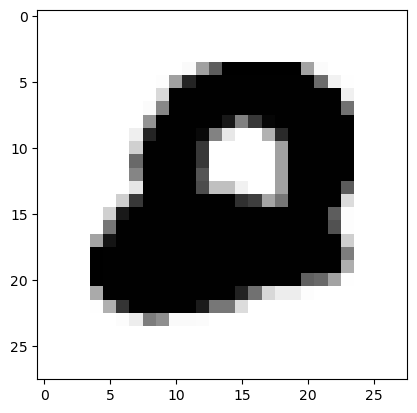


Image number 2488 wrongly identified: I guessed a 4, but it's a 2.


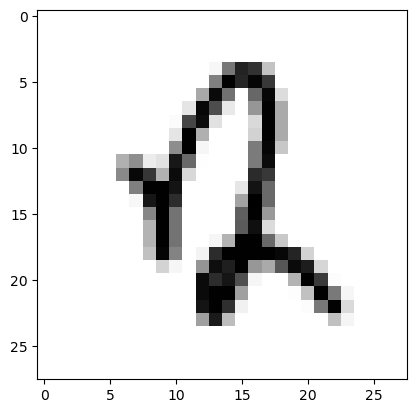


Image number 2533 wrongly identified: I guessed a 1, but it's a 3.


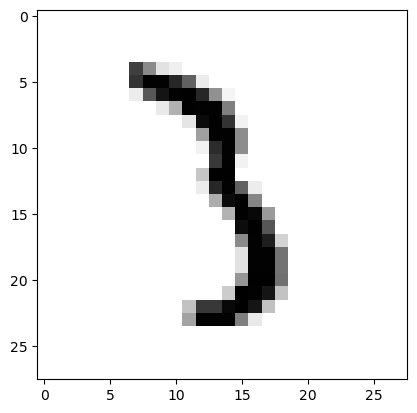


Image number 2582 wrongly identified: I guessed a 7, but it's a 9.


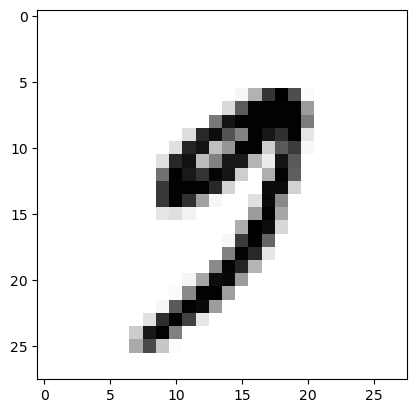


Image number 2597 wrongly identified: I guessed a 3, but it's a 5.


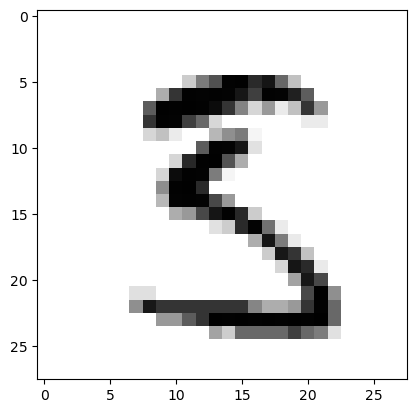


Image number 2607 wrongly identified: I guessed a 1, but it's a 7.


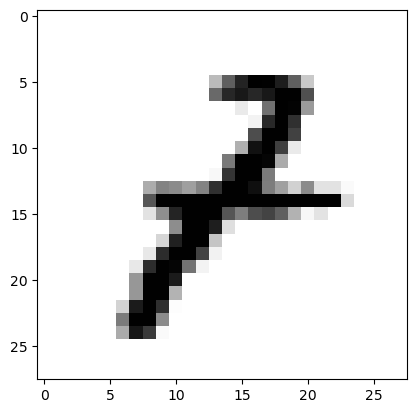


Image number 2648 wrongly identified: I guessed a 0, but it's a 9.


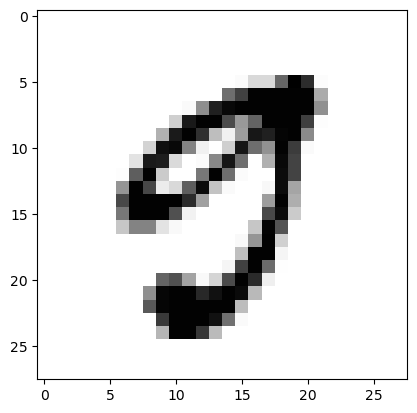


Image number 2654 wrongly identified: I guessed a 1, but it's a 6.


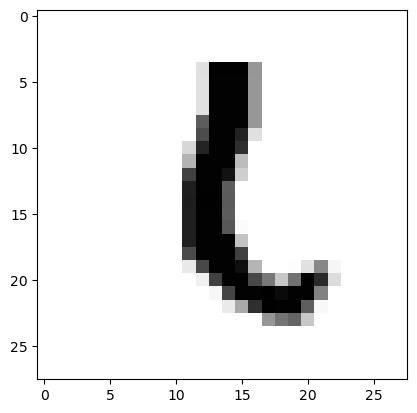


Image number 2771 wrongly identified: I guessed a 9, but it's a 4.


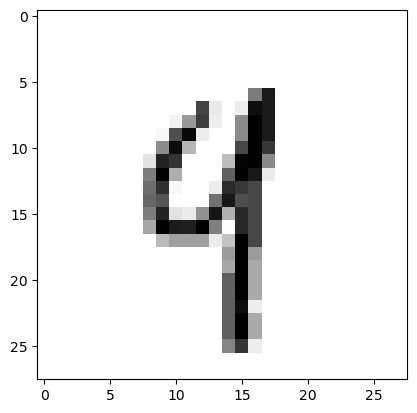


Image number 2896 wrongly identified: I guessed a 0, but it's a 8.


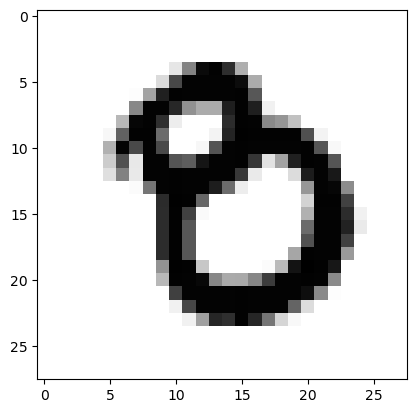


Image number 2901 wrongly identified: I guessed a 9, but it's a 4.


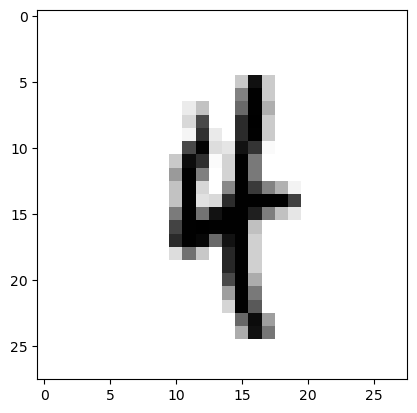


Image number 2927 wrongly identified: I guessed a 2, but it's a 3.


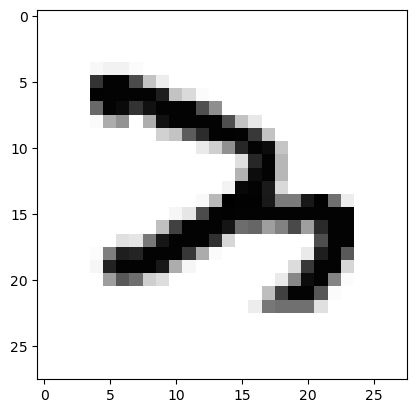


Image number 2939 wrongly identified: I guessed a 5, but it's a 9.


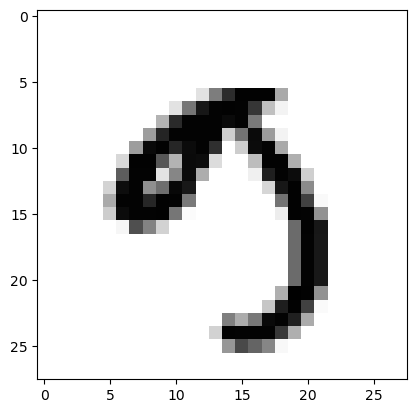


Image number 2952 wrongly identified: I guessed a 5, but it's a 3.


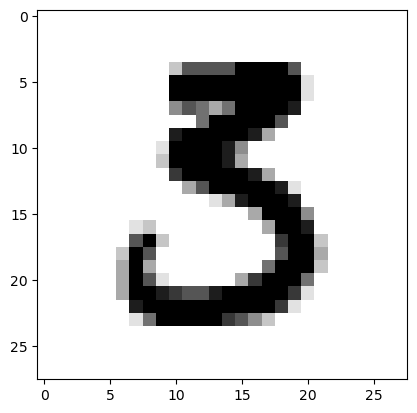


Image number 2953 wrongly identified: I guessed a 5, but it's a 3.


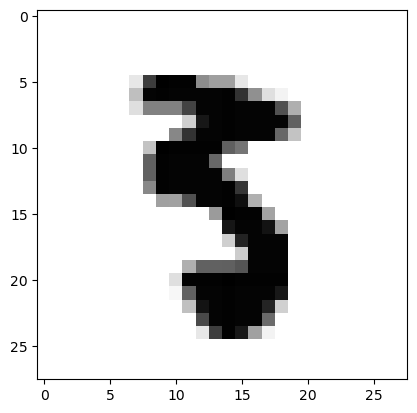


Image number 3005 wrongly identified: I guessed a 1, but it's a 9.


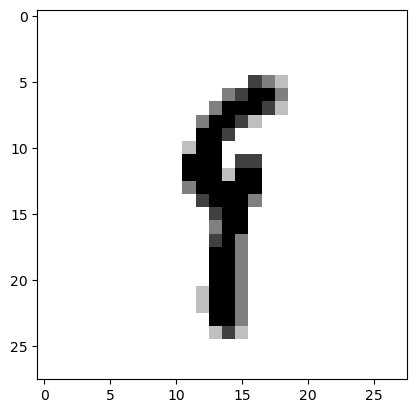


Image number 3060 wrongly identified: I guessed a 7, but it's a 9.


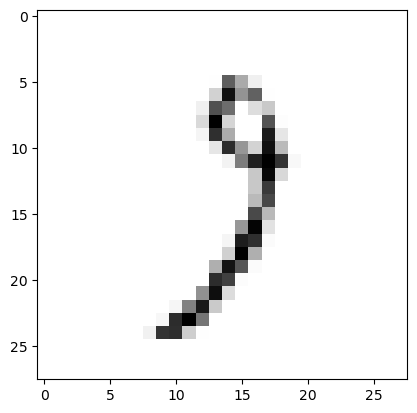


Image number 3062 wrongly identified: I guessed a 6, but it's a 8.


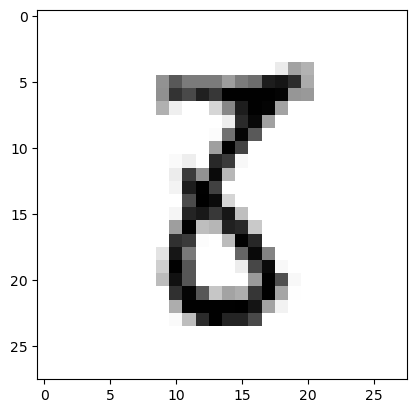


Image number 3073 wrongly identified: I guessed a 2, but it's a 1.


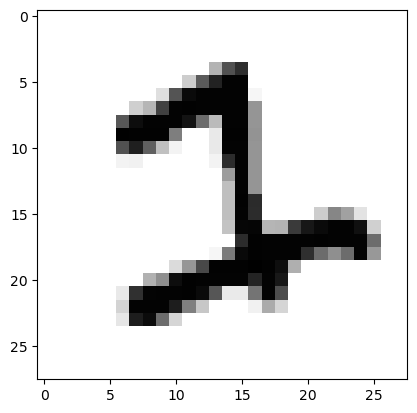


Image number 3117 wrongly identified: I guessed a 9, but it's a 5.


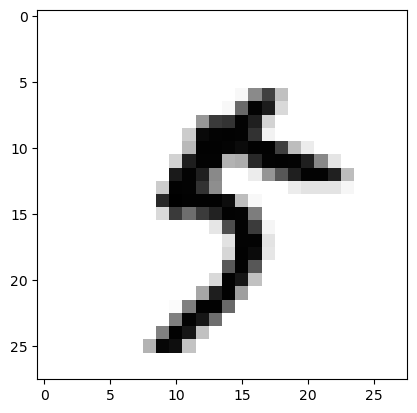


Image number 3136 wrongly identified: I guessed a 1, but it's a 7.


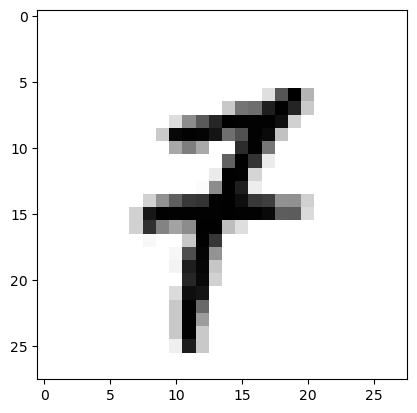


Image number 3160 wrongly identified: I guessed a 4, but it's a 9.


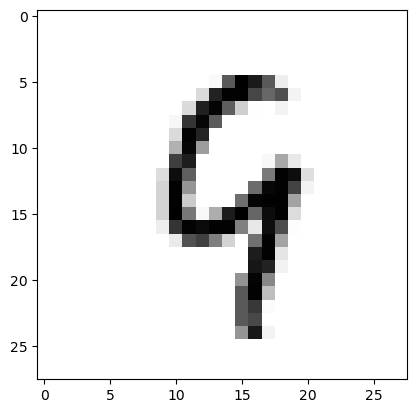


Image number 3206 wrongly identified: I guessed a 3, but it's a 8.


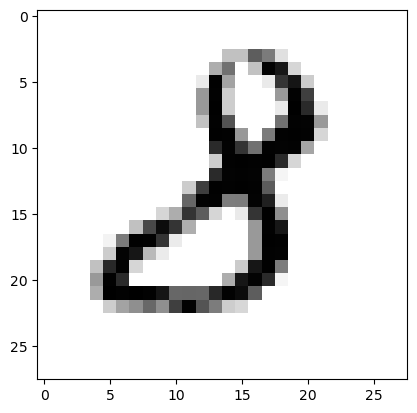


Image number 3207 wrongly identified: I guessed a 1, but it's a 2.


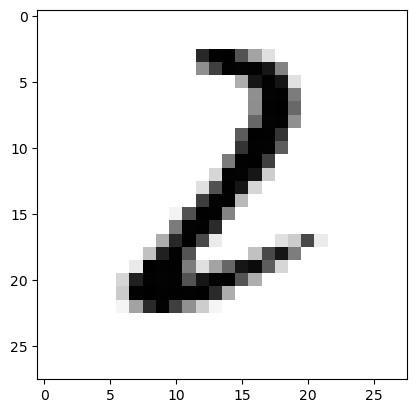


Image number 3225 wrongly identified: I guessed a 1, but it's a 7.


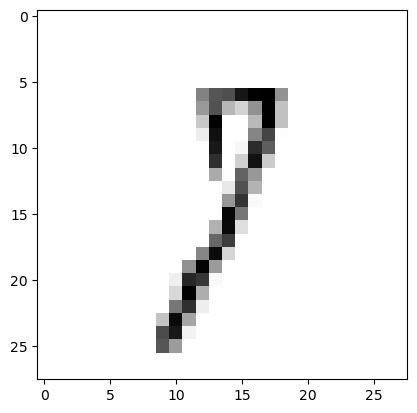


Image number 3262 wrongly identified: I guessed a 1, but it's a 7.


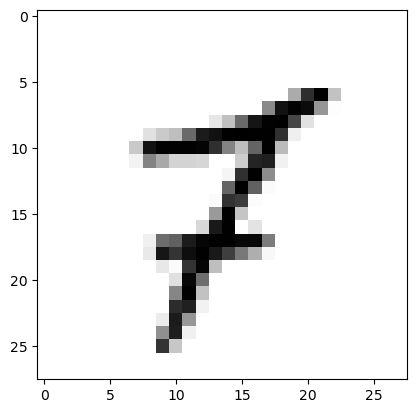


Image number 3269 wrongly identified: I guessed a 0, but it's a 6.


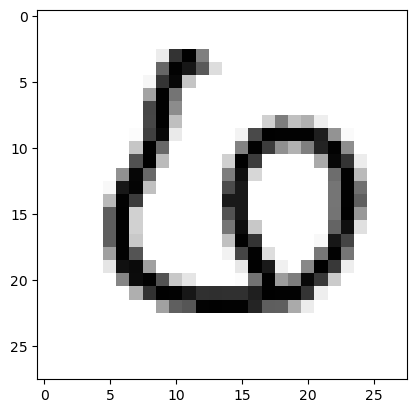


Image number 3333 wrongly identified: I guessed a 9, but it's a 7.


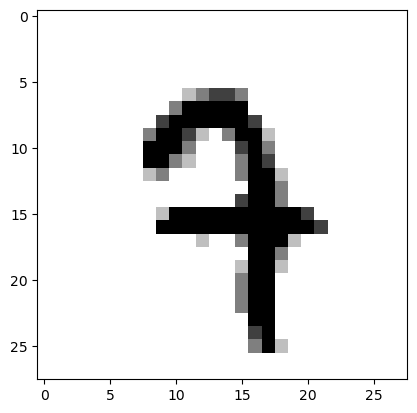


Image number 3336 wrongly identified: I guessed a 9, but it's a 5.


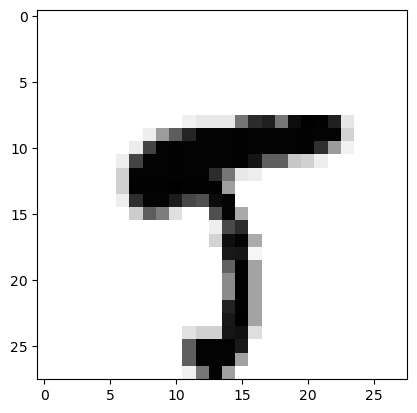


Image number 3384 wrongly identified: I guessed a 6, but it's a 2.


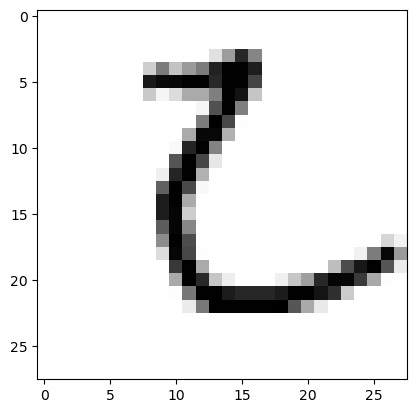


Image number 3388 wrongly identified: I guessed a 9, but it's a 4.


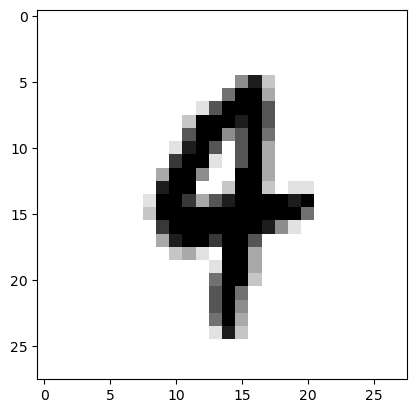


Image number 3405 wrongly identified: I guessed a 9, but it's a 4.


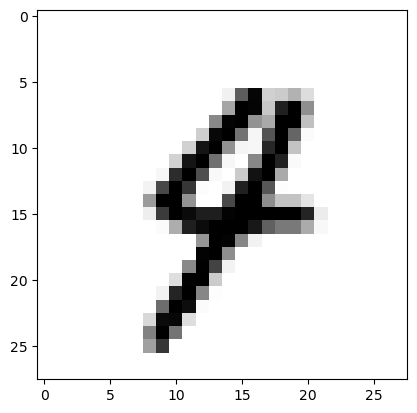


Image number 3437 wrongly identified: I guessed a 9, but it's a 4.


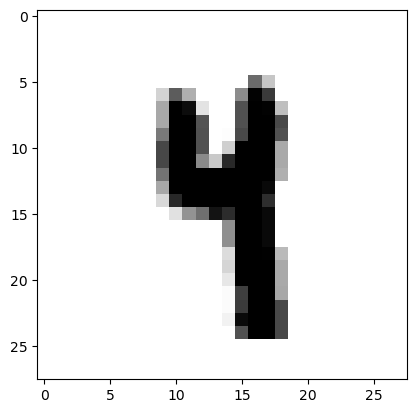


Image number 3456 wrongly identified: I guessed a 5, but it's a 3.


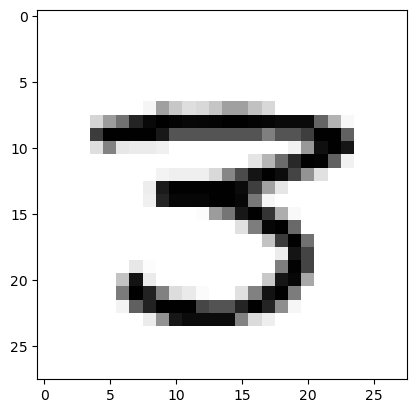


Image number 3475 wrongly identified: I guessed a 7, but it's a 3.


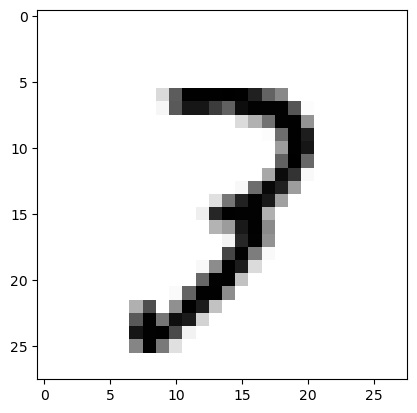


Image number 3490 wrongly identified: I guessed a 9, but it's a 4.


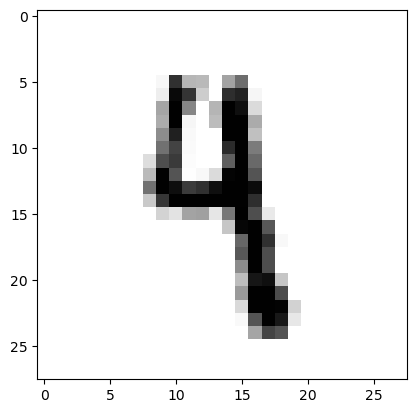


Image number 3503 wrongly identified: I guessed a 1, but it's a 9.


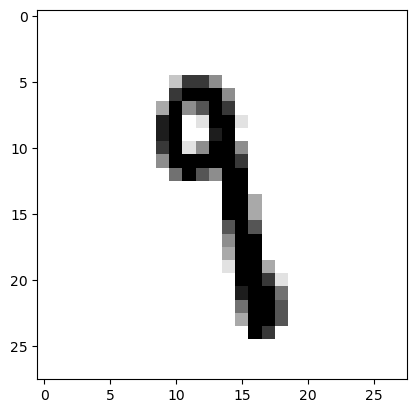


Image number 3520 wrongly identified: I guessed a 4, but it's a 6.


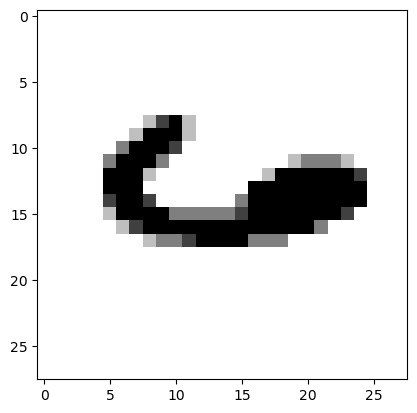


Image number 3558 wrongly identified: I guessed a 0, but it's a 5.


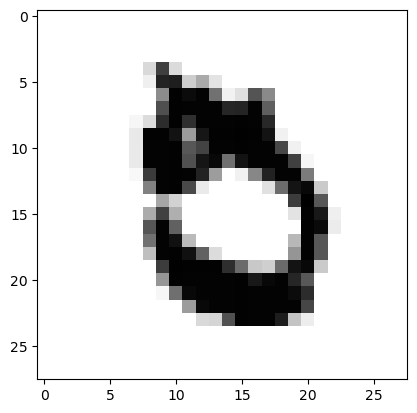


Image number 3559 wrongly identified: I guessed a 5, but it's a 8.


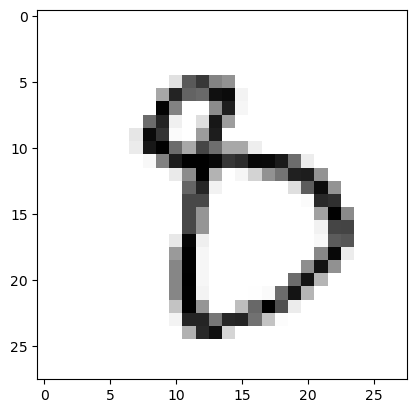


Image number 3567 wrongly identified: I guessed a 5, but it's a 8.


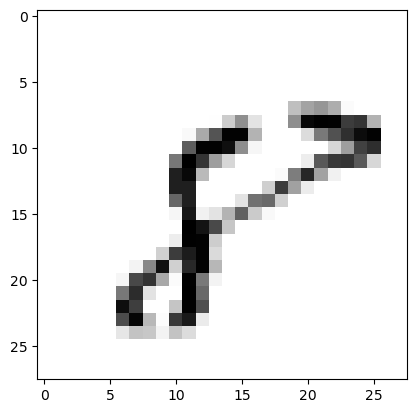


Image number 3597 wrongly identified: I guessed a 3, but it's a 9.


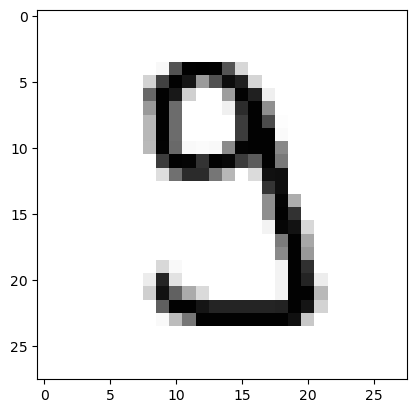


Image number 3599 wrongly identified: I guessed a 7, but it's a 2.


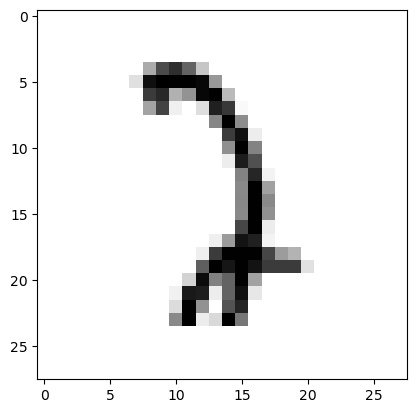


Image number 3629 wrongly identified: I guessed a 0, but it's a 8.


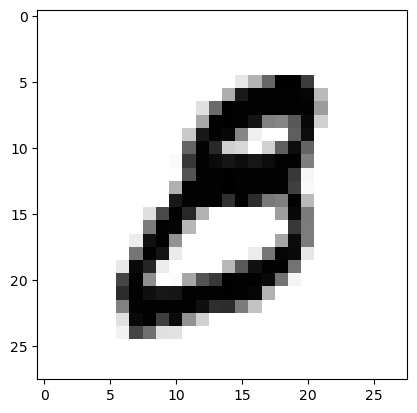


Image number 3654 wrongly identified: I guessed a 8, but it's a 5.


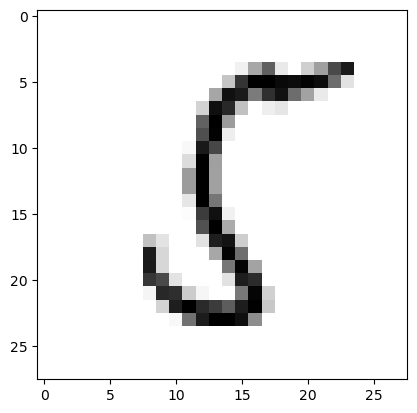


Image number 3662 wrongly identified: I guessed a 0, but it's a 8.


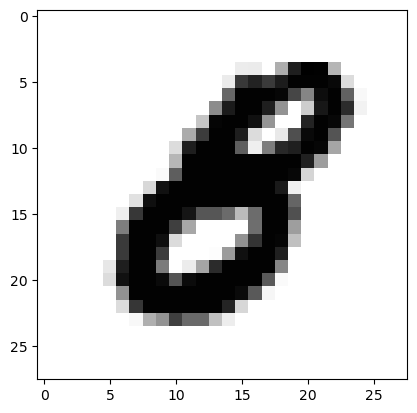


Image number 3664 wrongly identified: I guessed a 4, but it's a 9.


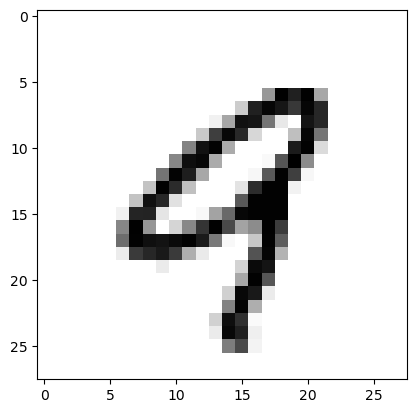


Image number 3702 wrongly identified: I guessed a 4, but it's a 5.


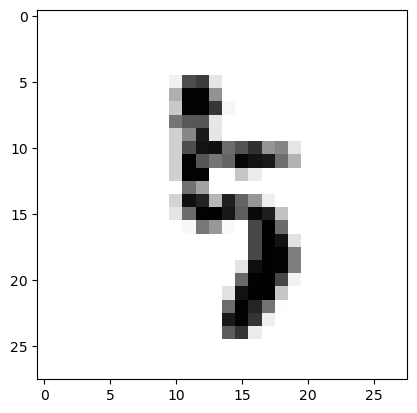


Image number 3751 wrongly identified: I guessed a 1, but it's a 7.


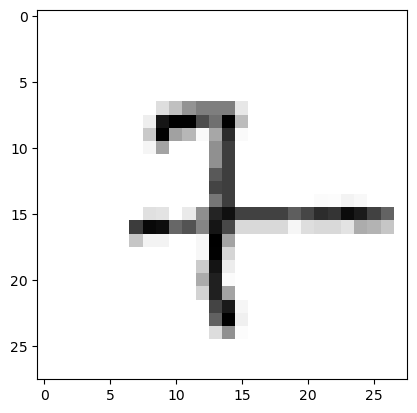


Image number 3767 wrongly identified: I guessed a 1, but it's a 7.


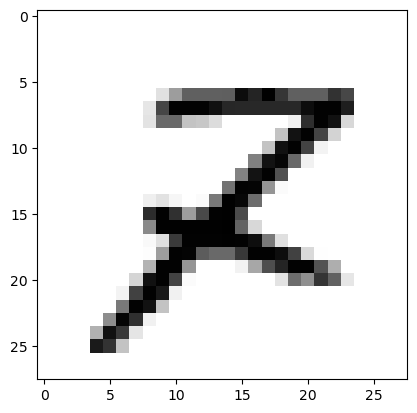


Image number 3780 wrongly identified: I guessed a 6, but it's a 4.


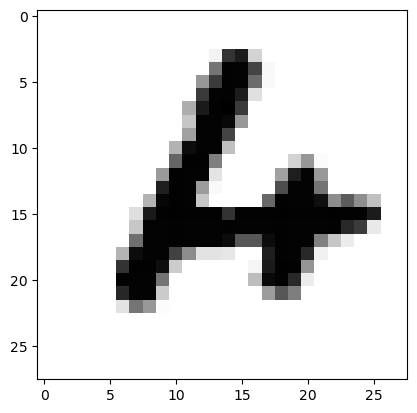


Image number 3796 wrongly identified: I guessed a 1, but it's a 2.


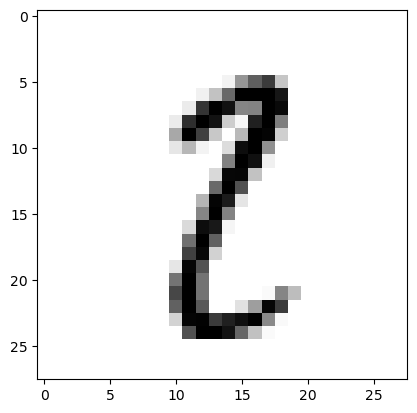


Image number 3808 wrongly identified: I guessed a 1, but it's a 7.


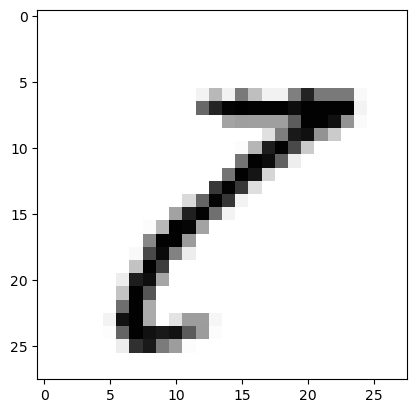


Image number 3811 wrongly identified: I guessed a 3, but it's a 2.


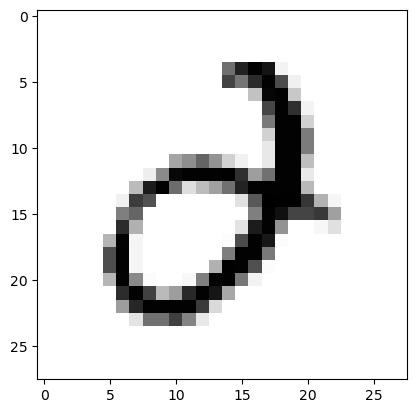


Image number 3838 wrongly identified: I guessed a 1, but it's a 7.


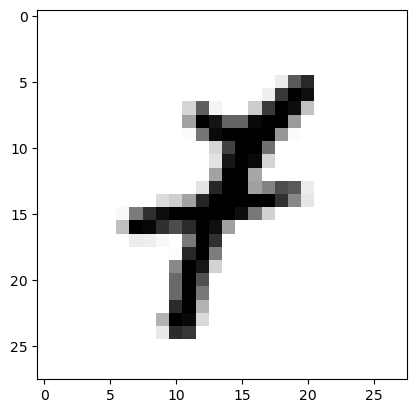


Image number 3853 wrongly identified: I guessed a 0, but it's a 6.


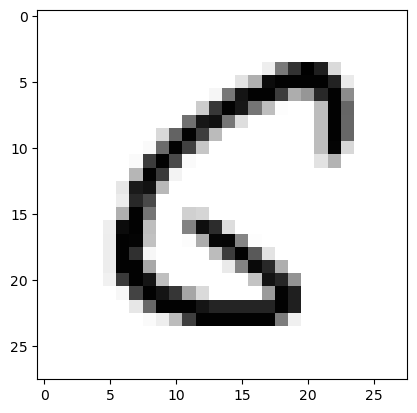


Image number 3893 wrongly identified: I guessed a 0, but it's a 5.


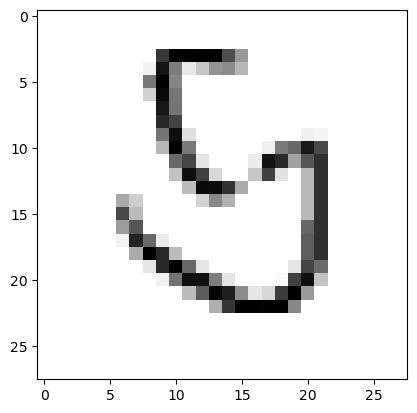


Image number 3902 wrongly identified: I guessed a 3, but it's a 5.


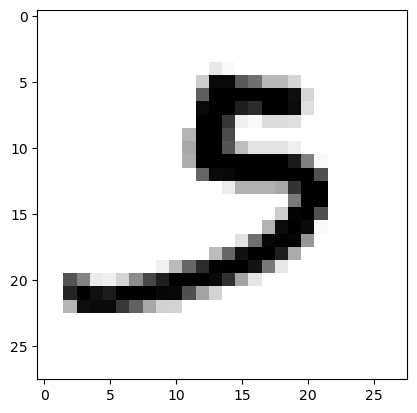


Image number 3926 wrongly identified: I guessed a 3, but it's a 9.


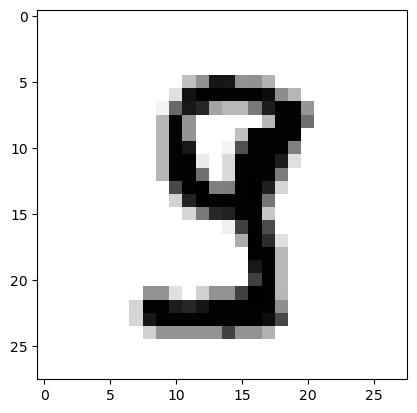


Image number 3941 wrongly identified: I guessed a 6, but it's a 4.


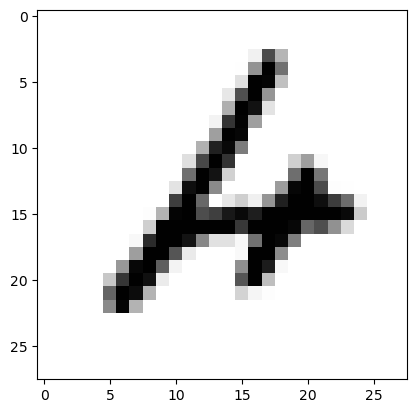


Image number 3976 wrongly identified: I guessed a 1, but it's a 7.


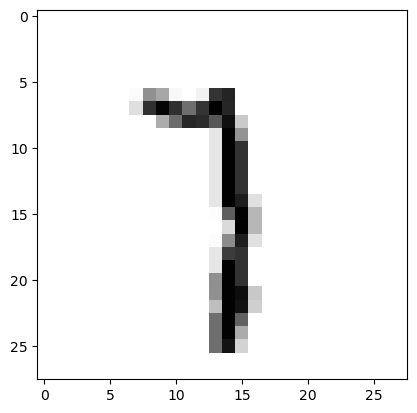


Image number 4017 wrongly identified: I guessed a 9, but it's a 4.


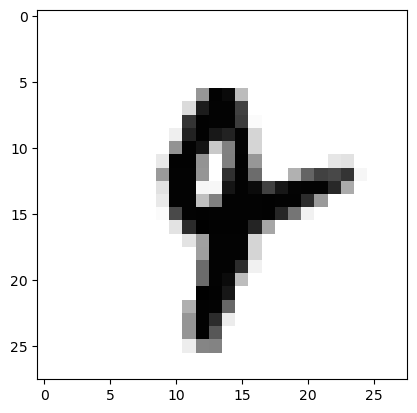


Image number 4027 wrongly identified: I guessed a 9, but it's a 7.


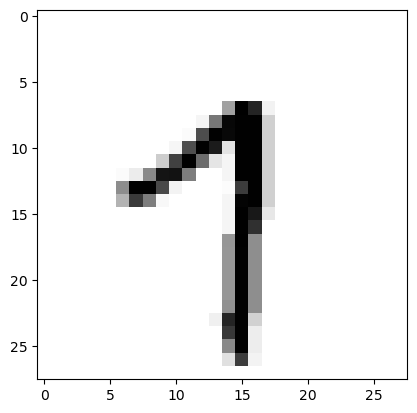


Image number 4065 wrongly identified: I guessed a 2, but it's a 0.


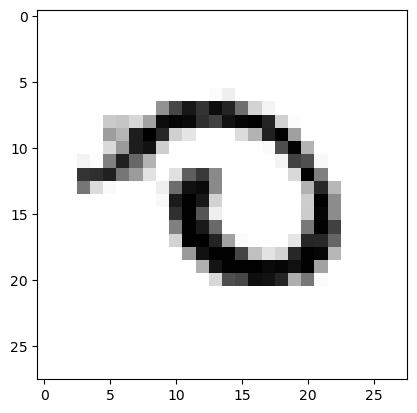


Image number 4075 wrongly identified: I guessed a 3, but it's a 8.


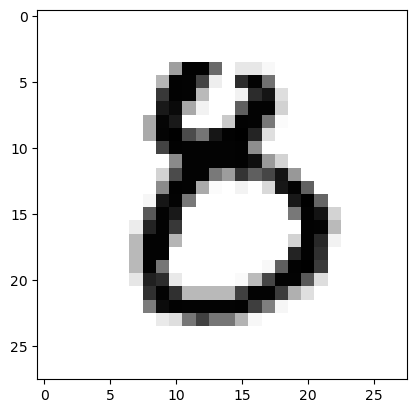


Image number 4078 wrongly identified: I guessed a 2, but it's a 9.


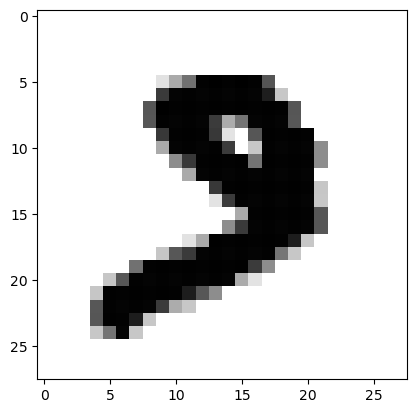


Image number 4116 wrongly identified: I guessed a 5, but it's a 8.


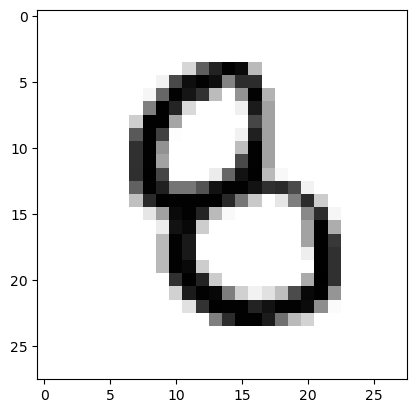


Image number 4140 wrongly identified: I guessed a 2, but it's a 8.


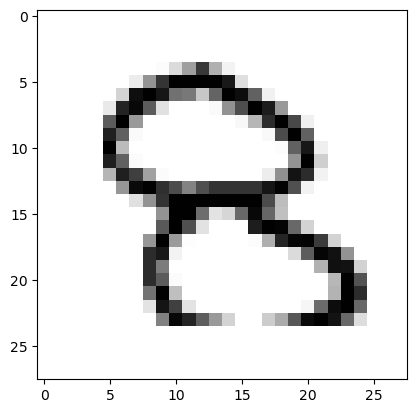


Image number 4176 wrongly identified: I guessed a 7, but it's a 2.


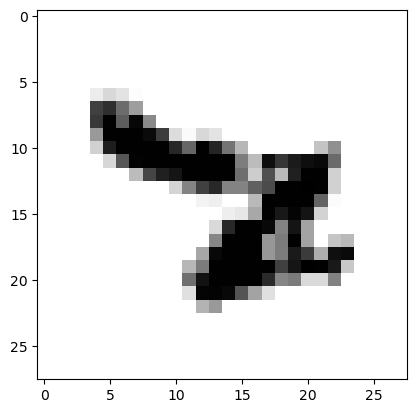


Image number 4194 wrongly identified: I guessed a 9, but it's a 4.


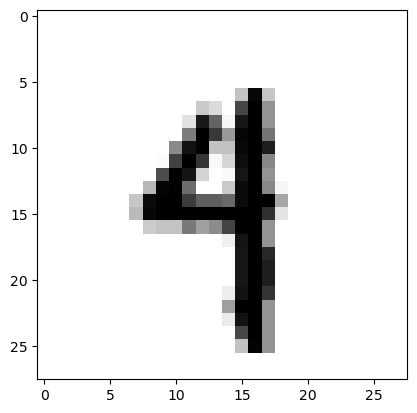


Image number 4199 wrongly identified: I guessed a 9, but it's a 7.


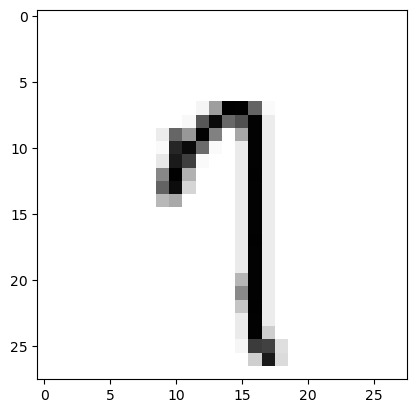


Image number 4224 wrongly identified: I guessed a 7, but it's a 9.


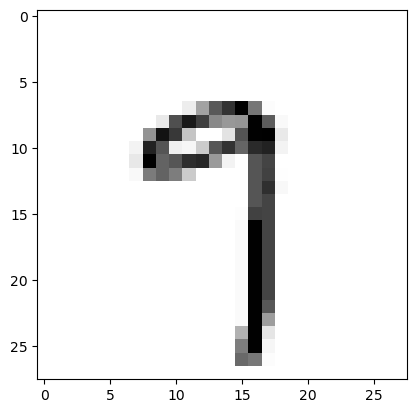


Image number 4248 wrongly identified: I guessed a 1, but it's a 2.


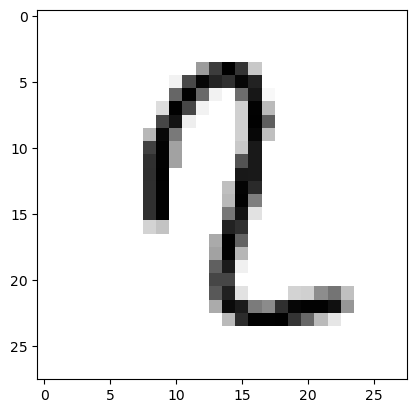


Image number 4271 wrongly identified: I guessed a 3, but it's a 5.


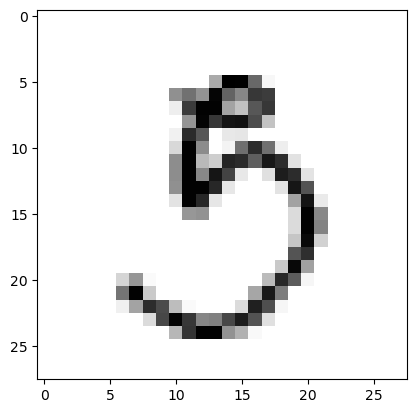


Image number 4289 wrongly identified: I guessed a 7, but it's a 2.


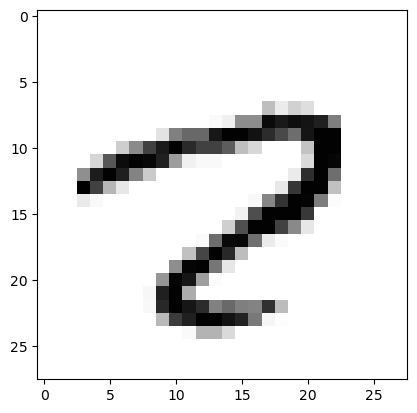


Image number 4306 wrongly identified: I guessed a 7, but it's a 3.


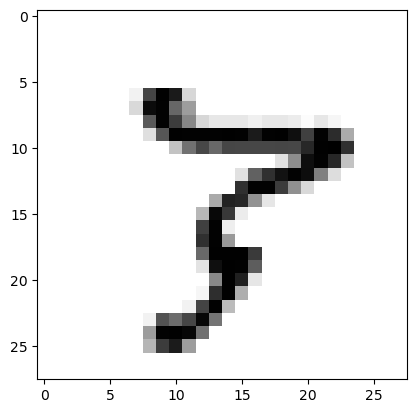


Image number 4317 wrongly identified: I guessed a 5, but it's a 3.


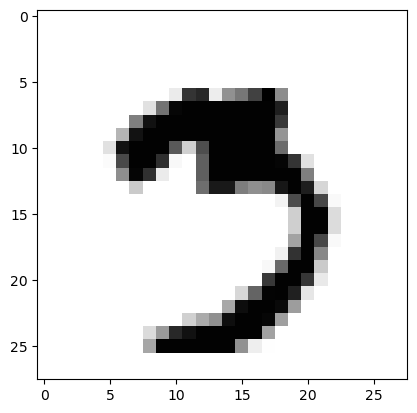


Image number 4341 wrongly identified: I guessed a 3, but it's a 2.


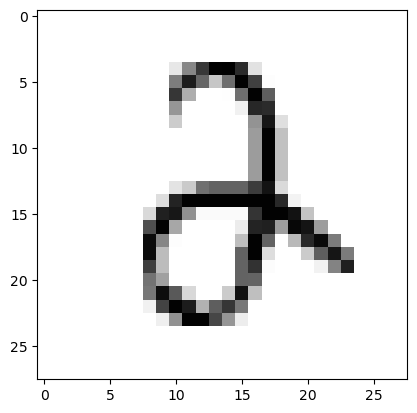


Image number 4344 wrongly identified: I guessed a 2, but it's a 9.


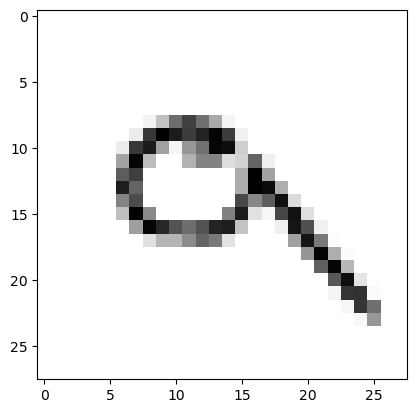


Image number 4360 wrongly identified: I guessed a 3, but it's a 5.


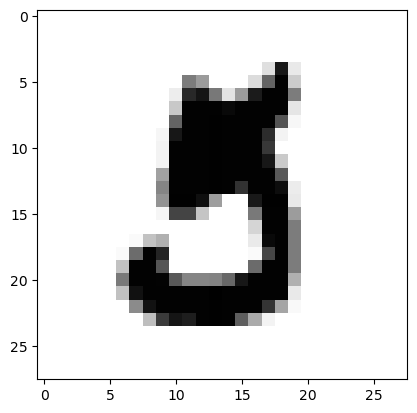


Image number 4374 wrongly identified: I guessed a 0, but it's a 5.


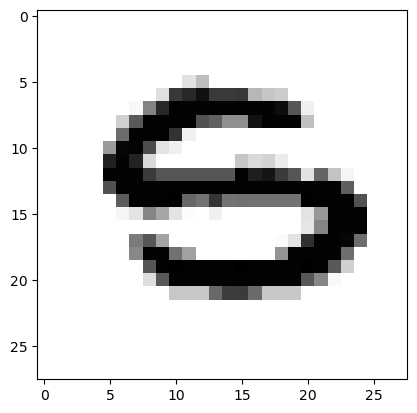


Image number 4382 wrongly identified: I guessed a 9, but it's a 4.


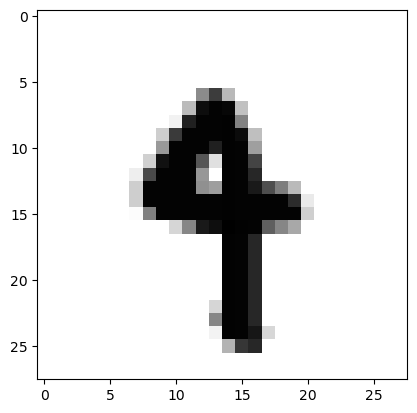


Image number 4433 wrongly identified: I guessed a 1, but it's a 7.


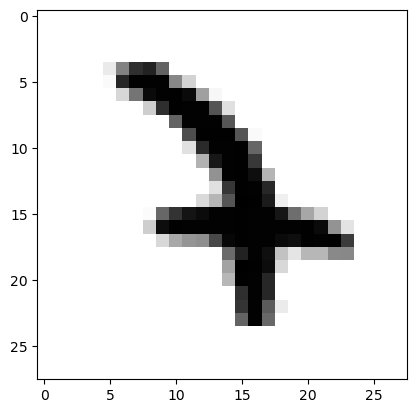


Image number 4451 wrongly identified: I guessed a 7, but it's a 2.


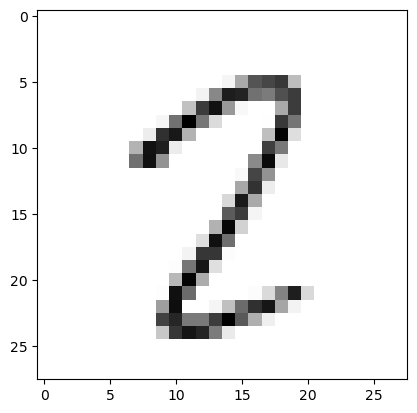


Image number 4483 wrongly identified: I guessed a 9, but it's a 4.


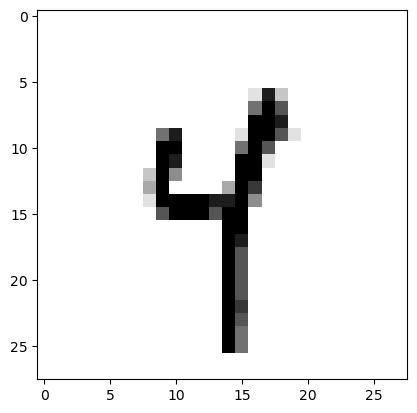


Image number 4497 wrongly identified: I guessed a 7, but it's a 8.


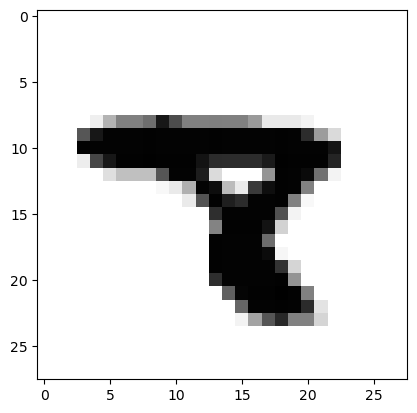


Image number 4500 wrongly identified: I guessed a 1, but it's a 9.


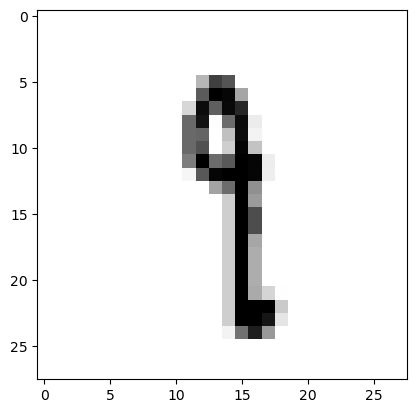


Image number 4504 wrongly identified: I guessed a 7, but it's a 2.


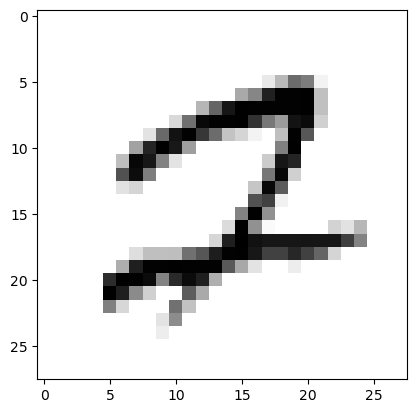


Image number 4575 wrongly identified: I guessed a 9, but it's a 4.


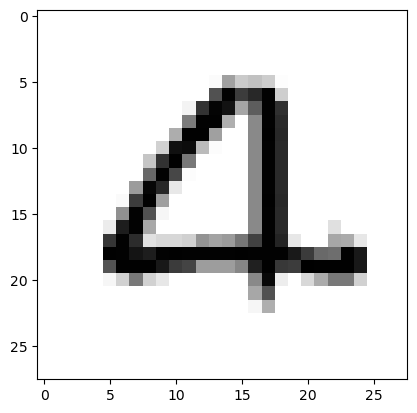


Image number 4578 wrongly identified: I guessed a 9, but it's a 7.


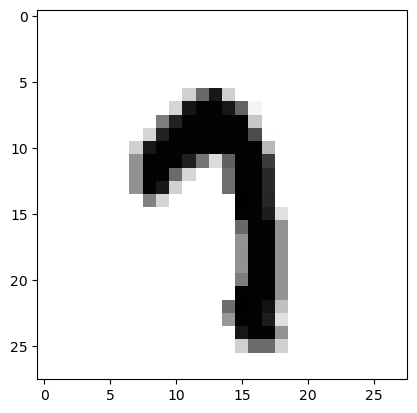


Image number 4635 wrongly identified: I guessed a 5, but it's a 3.


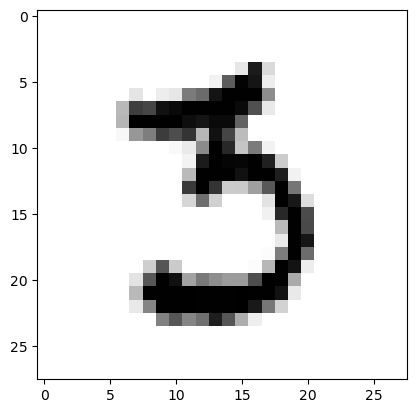


Image number 4639 wrongly identified: I guessed a 9, but it's a 8.


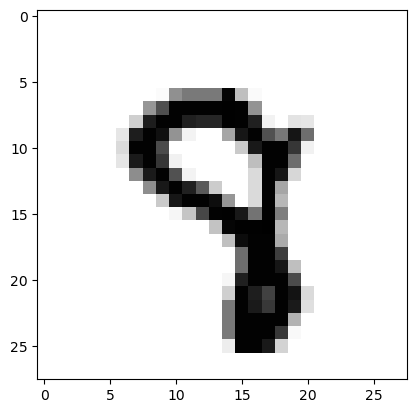


Image number 4671 wrongly identified: I guessed a 3, but it's a 8.


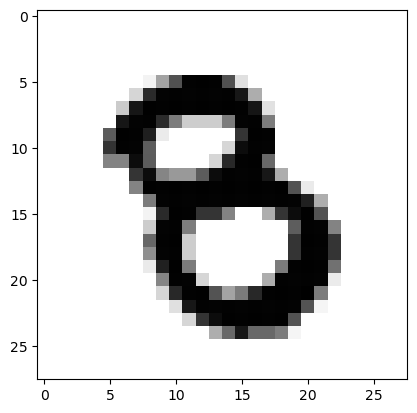


Image number 4690 wrongly identified: I guessed a 9, but it's a 7.


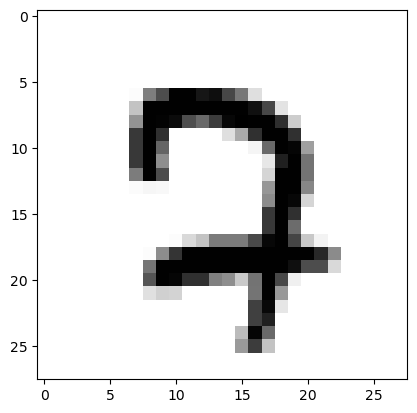


Image number 4699 wrongly identified: I guessed a 1, but it's a 6.


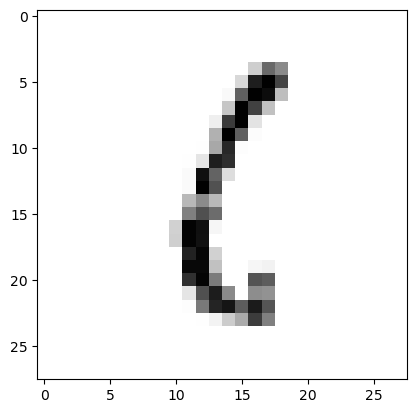


Image number 4712 wrongly identified: I guessed a 9, but it's a 5.


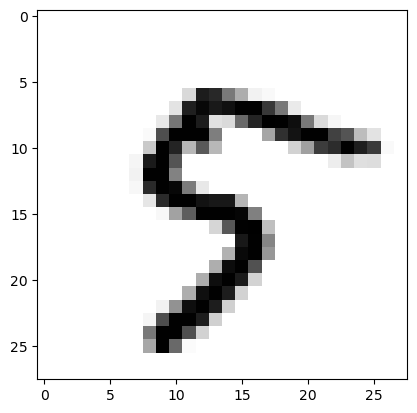


Image number 4737 wrongly identified: I guessed a 6, but it's a 8.


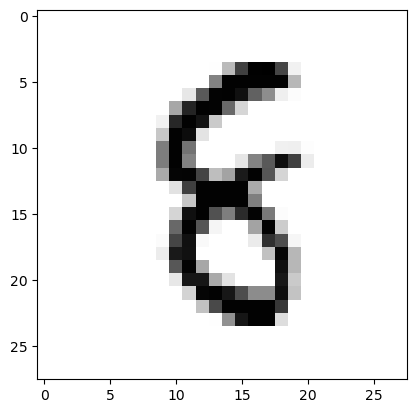


Image number 4740 wrongly identified: I guessed a 5, but it's a 3.


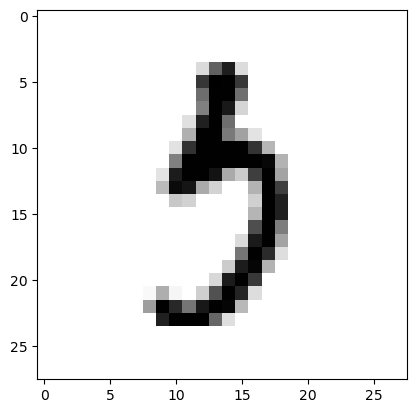


Image number 4785 wrongly identified: I guessed a 8, but it's a 3.


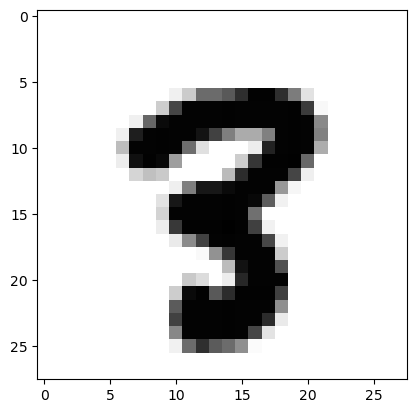


Image number 4807 wrongly identified: I guessed a 0, but it's a 8.


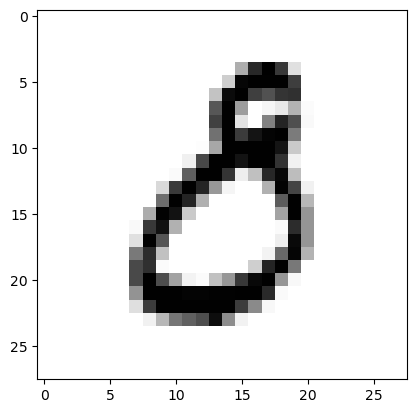


Image number 4814 wrongly identified: I guessed a 0, but it's a 6.


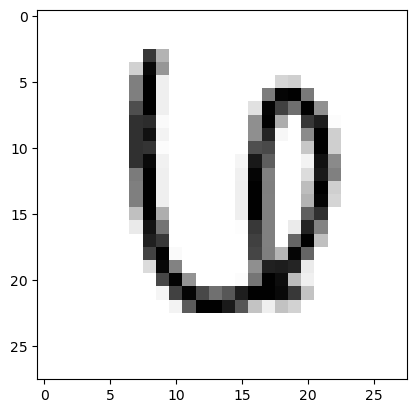


Image number 4823 wrongly identified: I guessed a 4, but it's a 9.


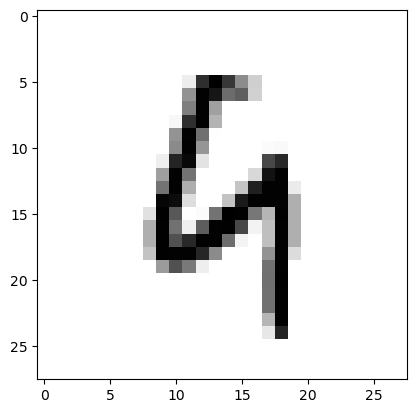


Image number 4837 wrongly identified: I guessed a 1, but it's a 7.


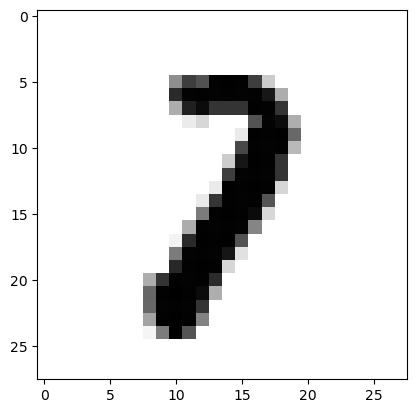


Image number 4860 wrongly identified: I guessed a 9, but it's a 4.


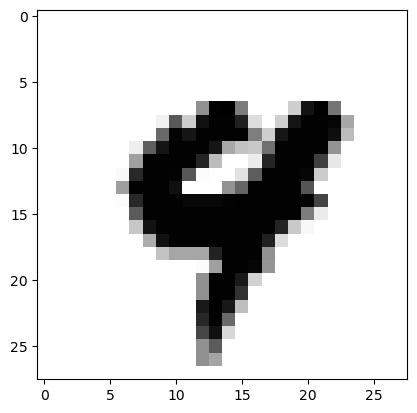


Image number 4879 wrongly identified: I guessed a 6, but it's a 8.


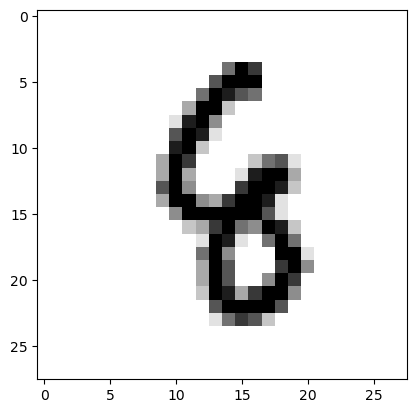


Image number 4886 wrongly identified: I guessed a 1, but it's a 7.


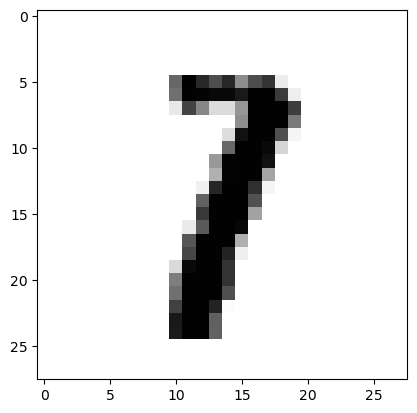


Image number 4890 wrongly identified: I guessed a 2, but it's a 8.


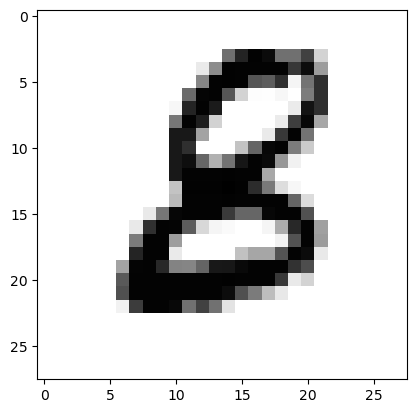


Image number 4943 wrongly identified: I guessed a 7, but it's a 2.


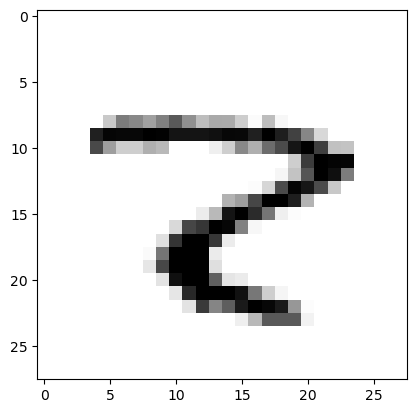


Image number 4966 wrongly identified: I guessed a 1, but it's a 7.


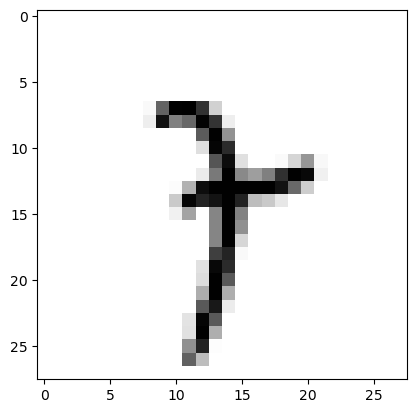


Image number 4978 wrongly identified: I guessed a 7, but it's a 8.


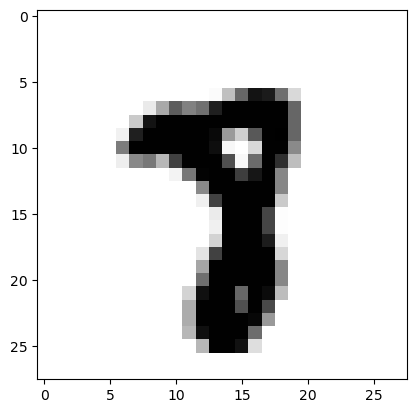


Image number 5001 wrongly identified: I guessed a 4, but it's a 9.


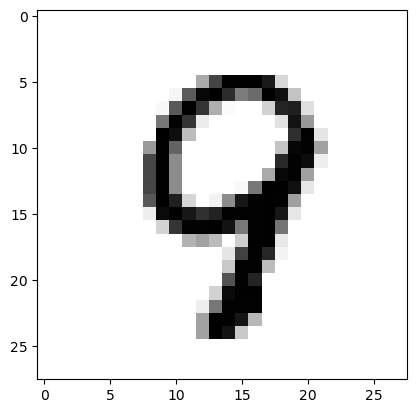


Image number 5068 wrongly identified: I guessed a 1, but it's a 4.


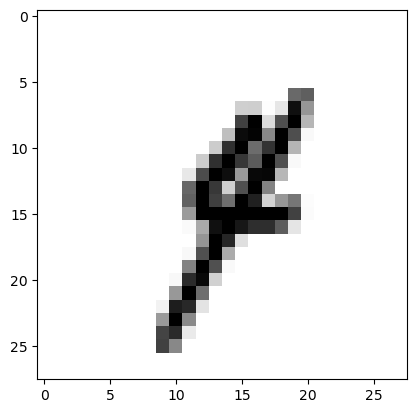


Image number 5176 wrongly identified: I guessed a 4, but it's a 8.


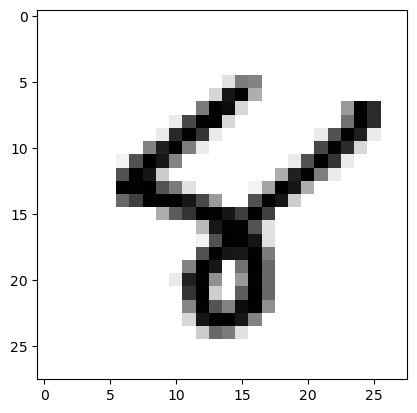


Image number 5278 wrongly identified: I guessed a 9, but it's a 8.


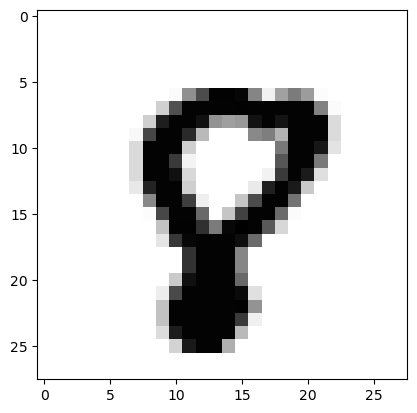


Image number 5288 wrongly identified: I guessed a 9, but it's a 8.


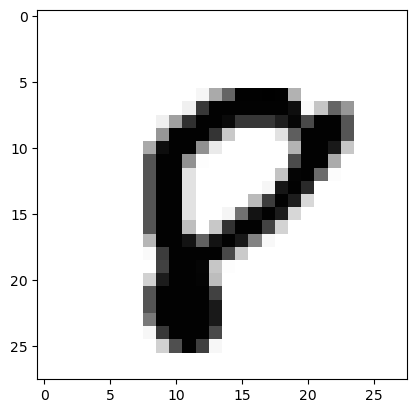


Image number 5457 wrongly identified: I guessed a 6, but it's a 1.


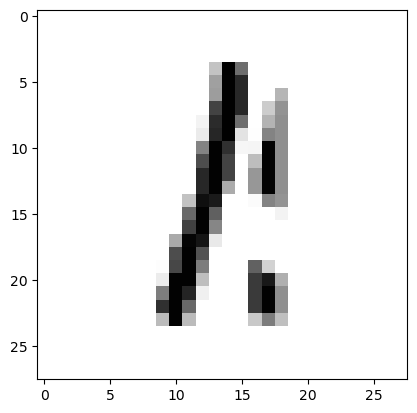


Image number 5600 wrongly identified: I guessed a 9, but it's a 7.


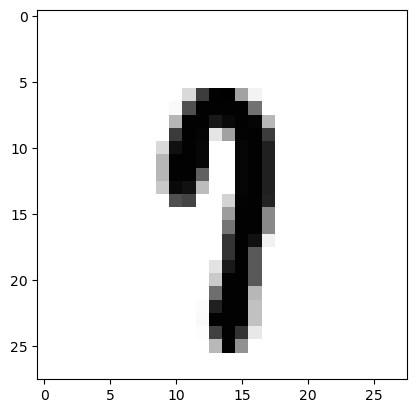


Image number 5617 wrongly identified: I guessed a 1, but it's a 4.


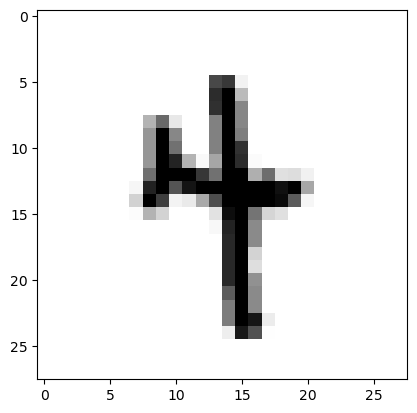


Image number 5634 wrongly identified: I guessed a 3, but it's a 2.


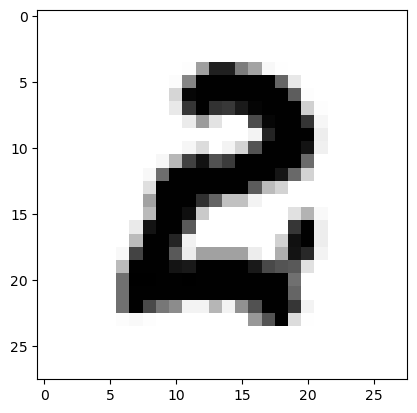


Image number 5677 wrongly identified: I guessed a 1, but it's a 4.


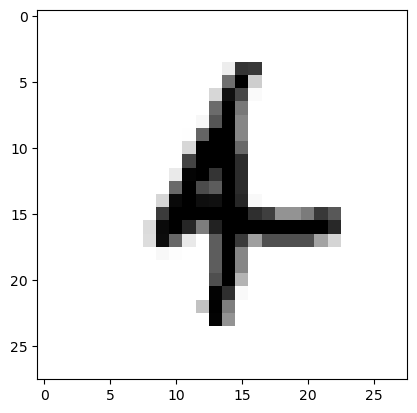


Image number 5691 wrongly identified: I guessed a 1, but it's a 4.


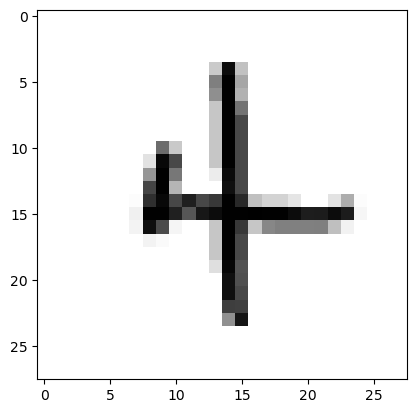


Image number 5714 wrongly identified: I guessed a 9, but it's a 7.


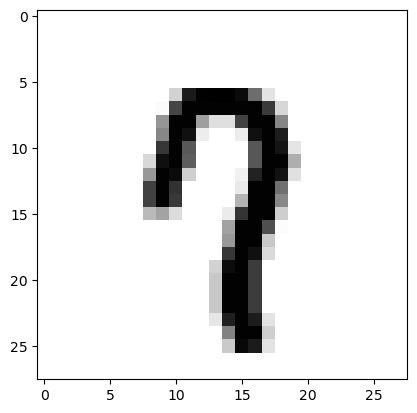


Image number 5720 wrongly identified: I guessed a 1, but it's a 4.


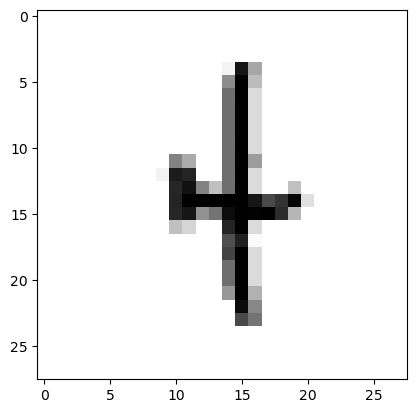


Image number 5734 wrongly identified: I guessed a 7, but it's a 3.


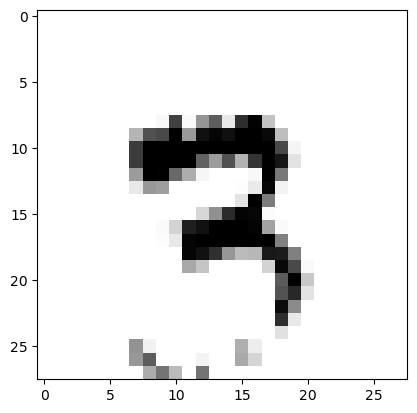


Image number 5757 wrongly identified: I guessed a 7, but it's a 9.


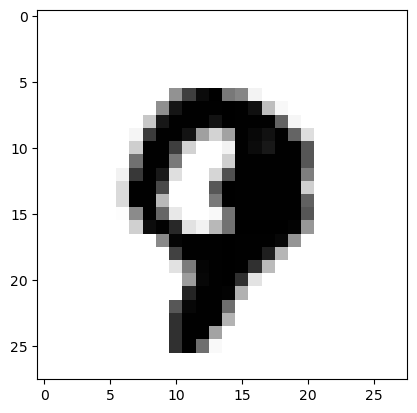


Image number 5835 wrongly identified: I guessed a 9, but it's a 7.


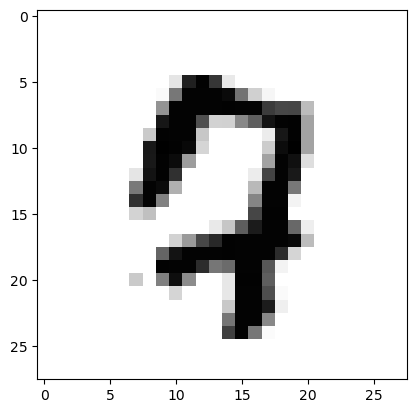


Image number 5841 wrongly identified: I guessed a 6, but it's a 3.


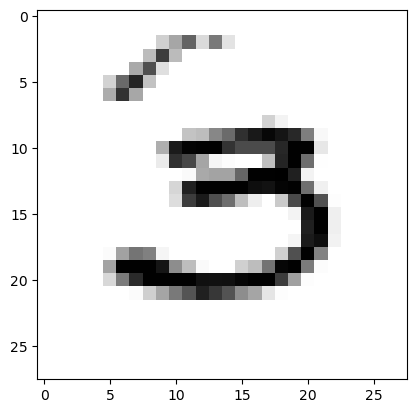


Image number 5887 wrongly identified: I guessed a 9, but it's a 7.


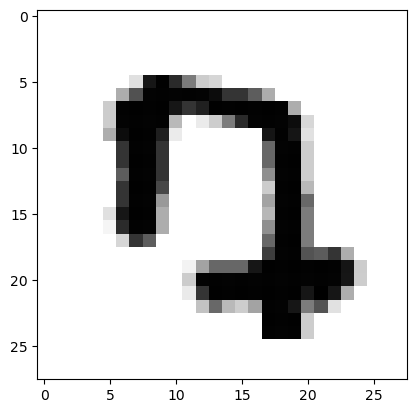


Image number 5936 wrongly identified: I guessed a 9, but it's a 4.


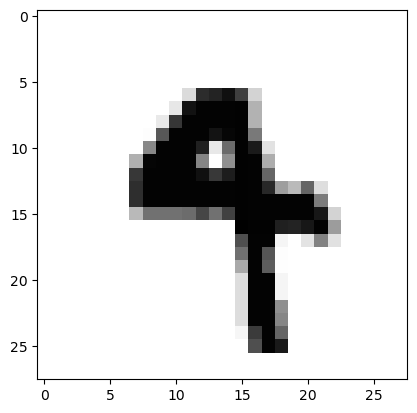


Image number 5937 wrongly identified: I guessed a 3, but it's a 5.


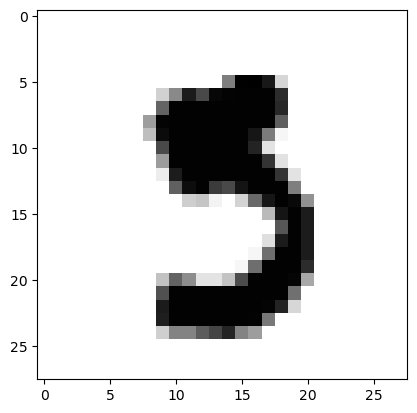


Image number 5955 wrongly identified: I guessed a 8, but it's a 3.


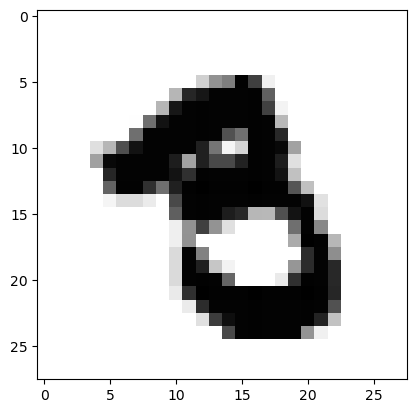


Image number 5973 wrongly identified: I guessed a 9, but it's a 3.


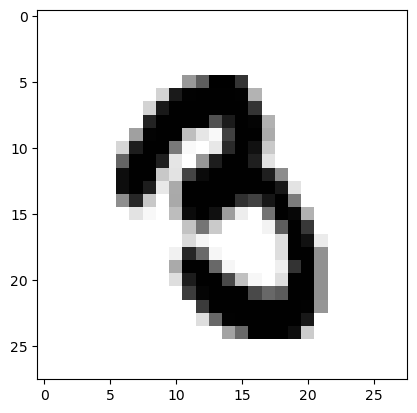


Image number 6011 wrongly identified: I guessed a 5, but it's a 3.


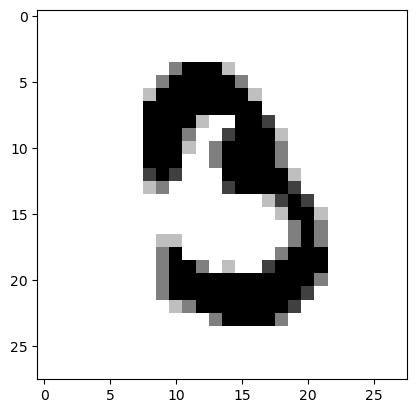


Image number 6023 wrongly identified: I guessed a 8, but it's a 3.


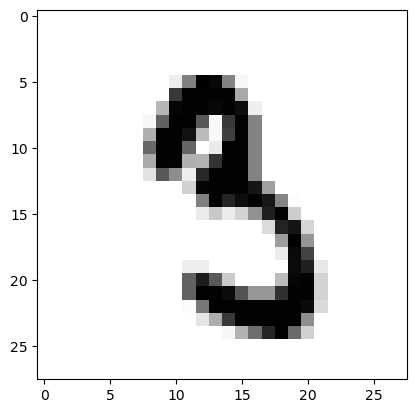


Image number 6035 wrongly identified: I guessed a 0, but it's a 2.


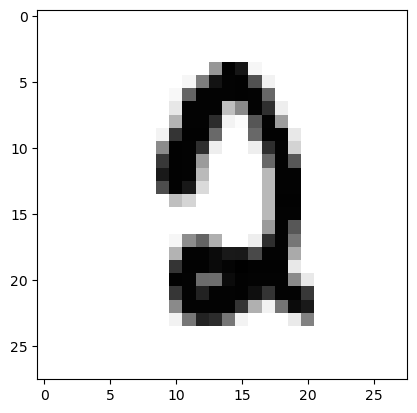


Image number 6045 wrongly identified: I guessed a 5, but it's a 3.


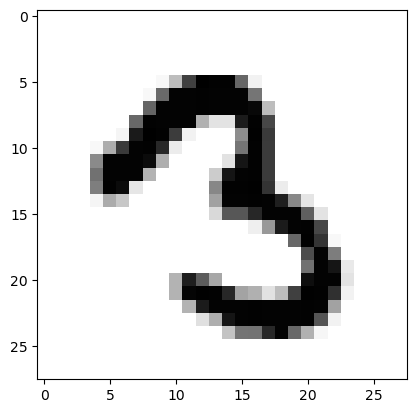


Image number 6059 wrongly identified: I guessed a 5, but it's a 3.


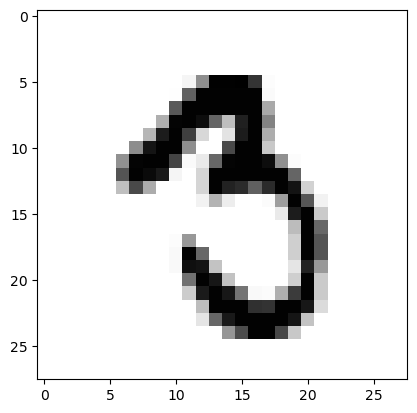


Image number 6071 wrongly identified: I guessed a 3, but it's a 9.


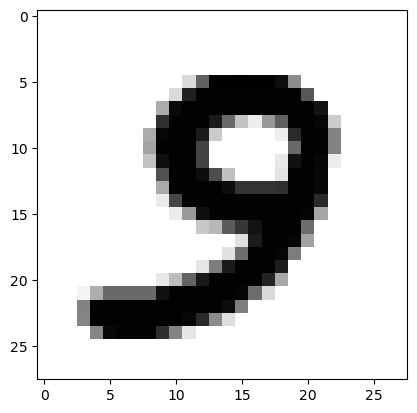


Image number 6081 wrongly identified: I guessed a 5, but it's a 9.


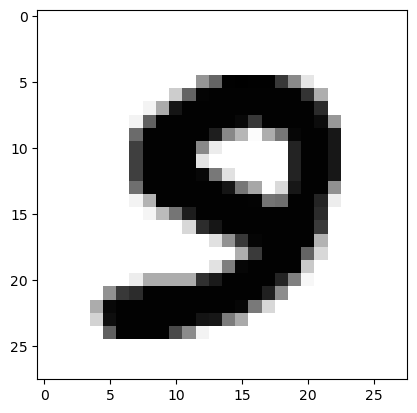


Image number 6157 wrongly identified: I guessed a 0, but it's a 9.


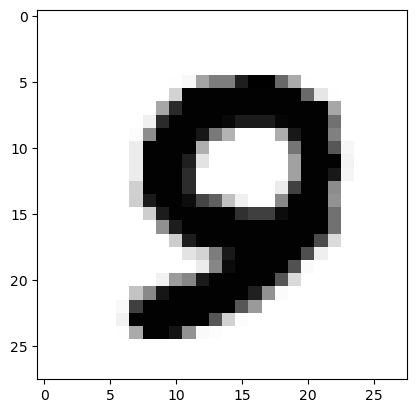


Image number 6166 wrongly identified: I guessed a 5, but it's a 9.


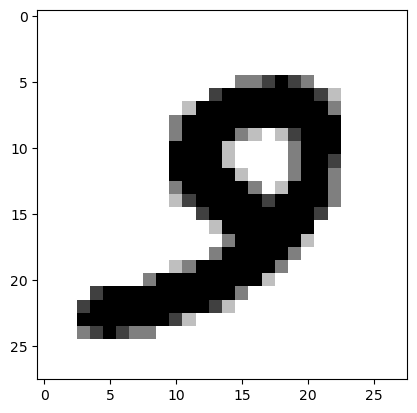


Image number 6172 wrongly identified: I guessed a 0, but it's a 9.


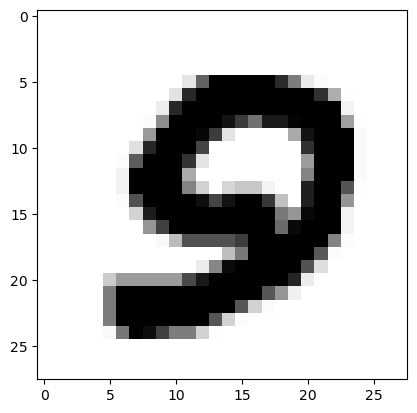


Image number 6173 wrongly identified: I guessed a 0, but it's a 9.


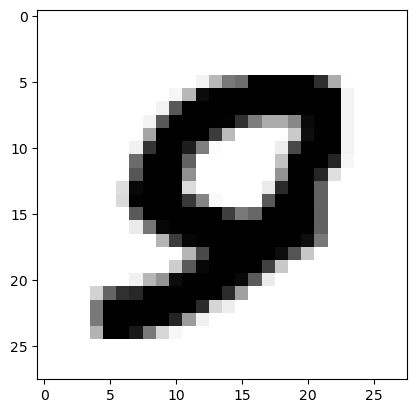


Image number 6505 wrongly identified: I guessed a 0, but it's a 9.


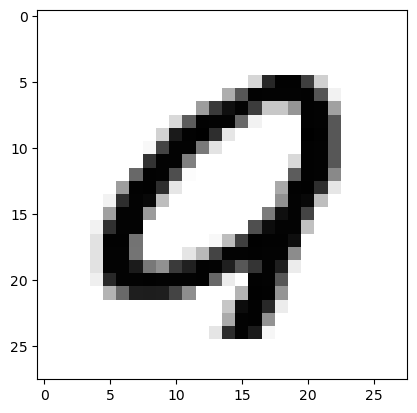


Image number 6555 wrongly identified: I guessed a 9, but it's a 8.


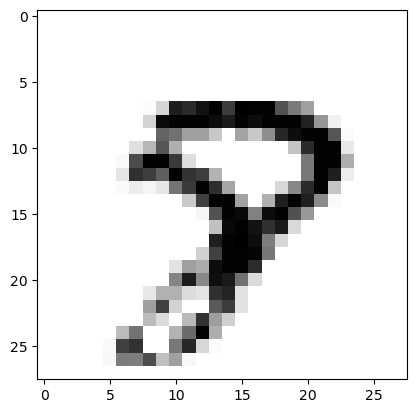


Image number 6569 wrongly identified: I guessed a 1, but it's a 3.


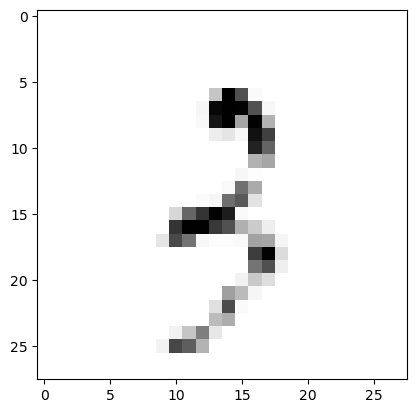


Image number 6571 wrongly identified: I guessed a 7, but it's a 9.


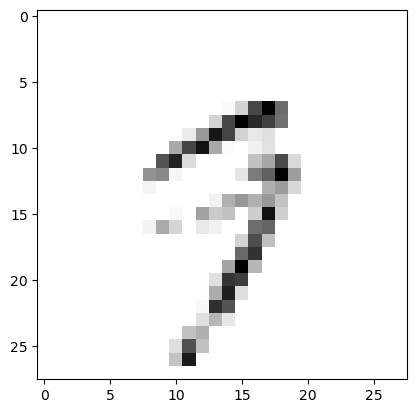


Image number 6576 wrongly identified: I guessed a 1, but it's a 7.


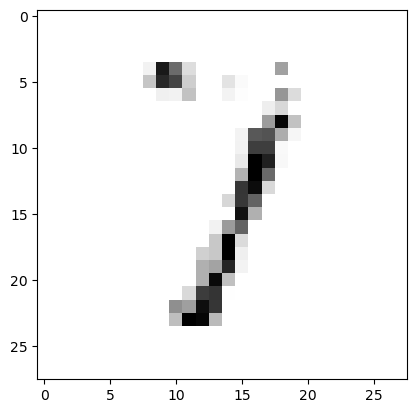


Image number 6597 wrongly identified: I guessed a 7, but it's a 0.


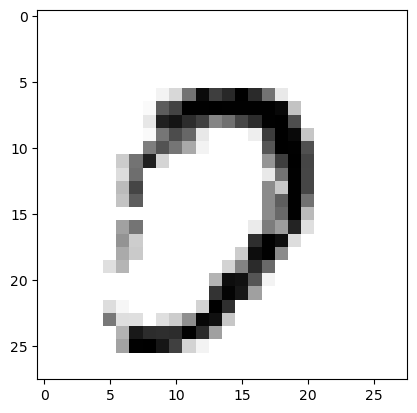


Image number 6598 wrongly identified: I guessed a 6, but it's a 5.


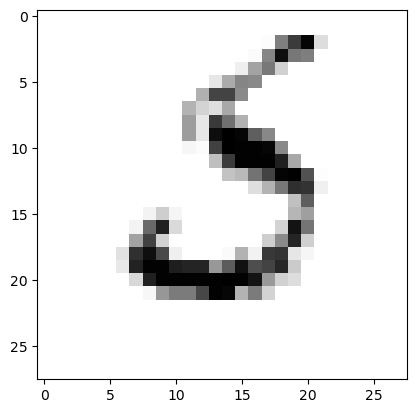


Image number 6625 wrongly identified: I guessed a 1, but it's a 8.


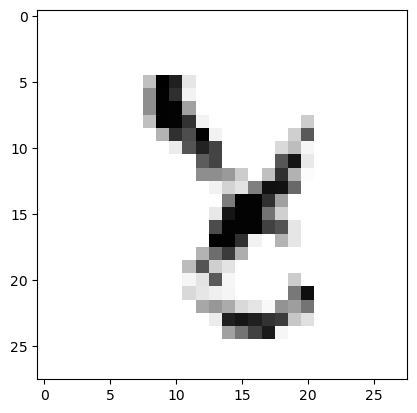


Image number 6651 wrongly identified: I guessed a 5, but it's a 0.


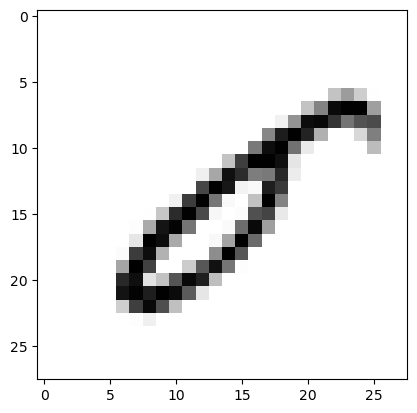


Image number 6700 wrongly identified: I guessed a 1, but it's a 4.


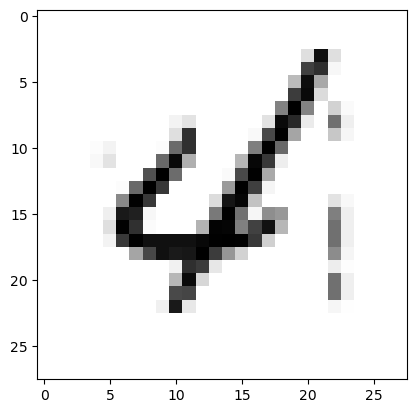


Image number 6755 wrongly identified: I guessed a 7, but it's a 8.


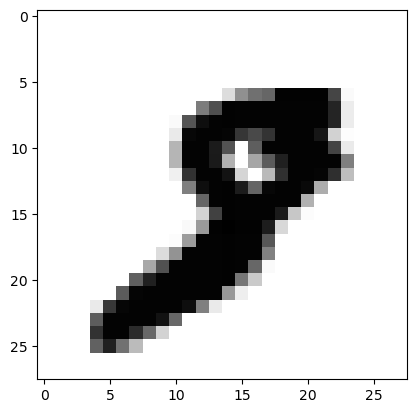


Image number 7121 wrongly identified: I guessed a 9, but it's a 8.


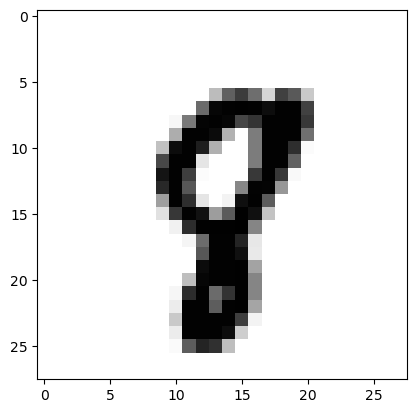


Image number 7233 wrongly identified: I guessed a 7, but it's a 3.


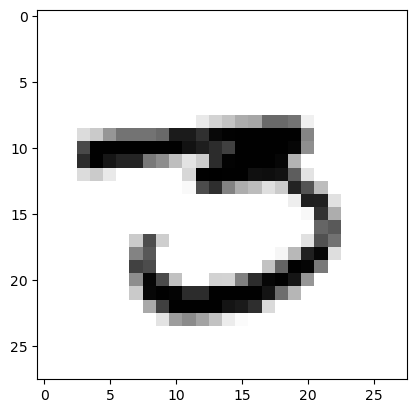


Image number 7432 wrongly identified: I guessed a 1, but it's a 7.


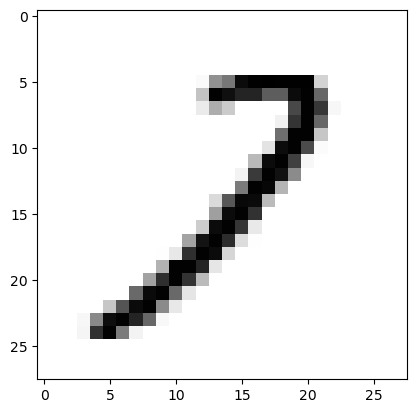


Image number 7434 wrongly identified: I guessed a 7, but it's a 4.


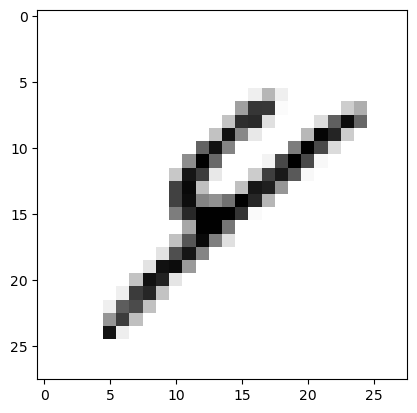


Image number 7492 wrongly identified: I guessed a 7, but it's a 2.


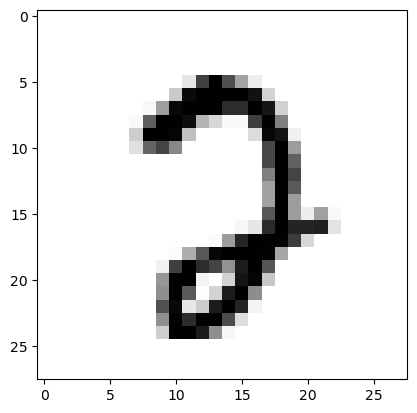


Image number 7595 wrongly identified: I guessed a 8, but it's a 3.


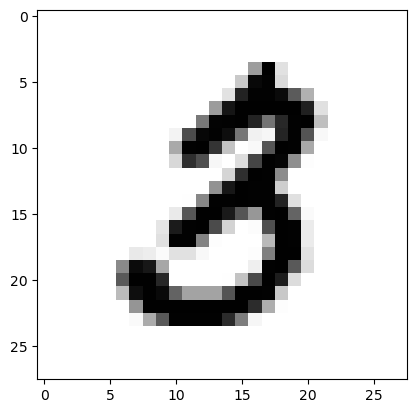


Image number 7637 wrongly identified: I guessed a 0, but it's a 2.


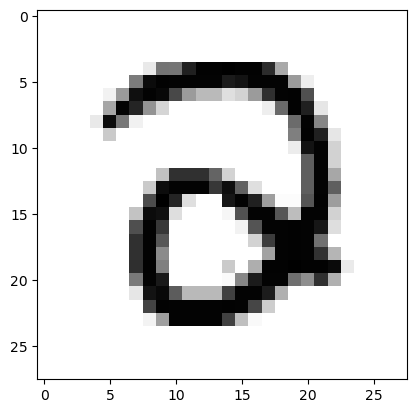


Image number 7718 wrongly identified: I guessed a 5, but it's a 8.


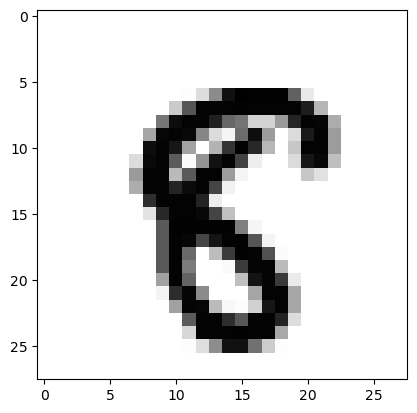


Image number 7797 wrongly identified: I guessed a 6, but it's a 5.


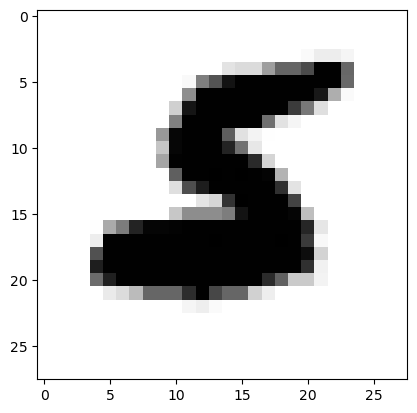


Image number 7821 wrongly identified: I guessed a 2, but it's a 3.


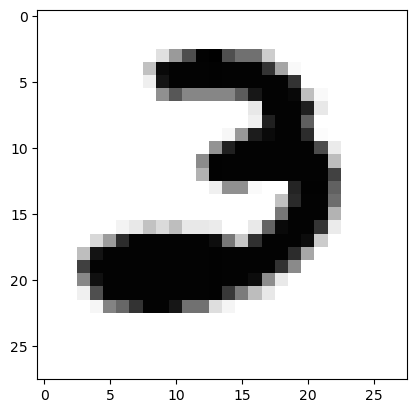


Image number 8094 wrongly identified: I guessed a 8, but it's a 2.


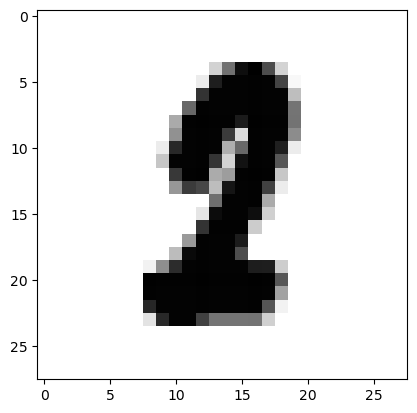


Image number 8095 wrongly identified: I guessed a 1, but it's a 4.


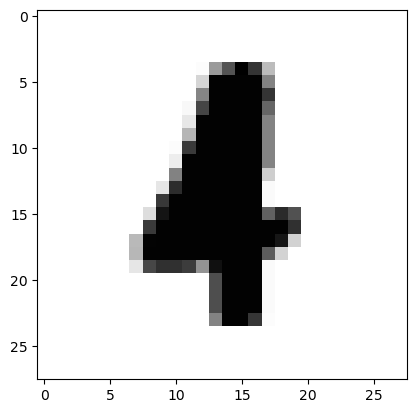


Image number 8246 wrongly identified: I guessed a 5, but it's a 3.


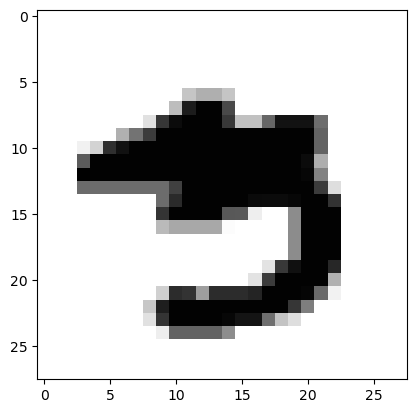


Image number 8277 wrongly identified: I guessed a 5, but it's a 3.


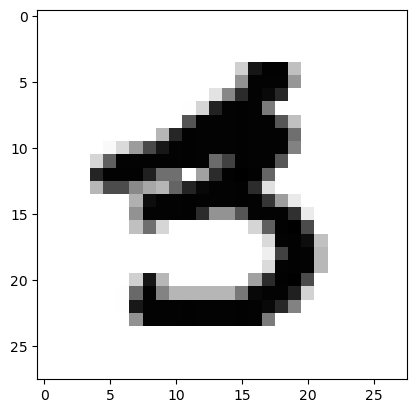


Image number 8279 wrongly identified: I guessed a 4, but it's a 8.


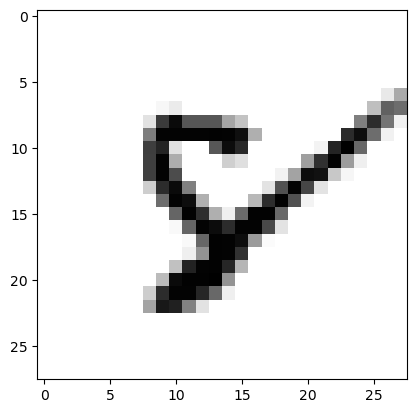


Image number 8325 wrongly identified: I guessed a 6, but it's a 0.


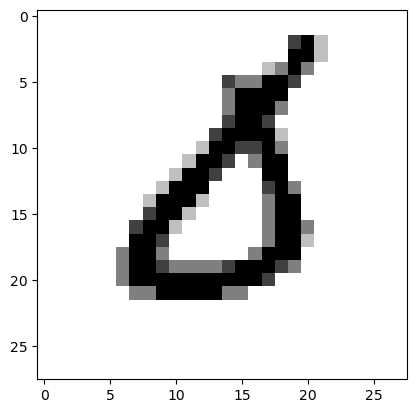


Image number 8408 wrongly identified: I guessed a 5, but it's a 8.


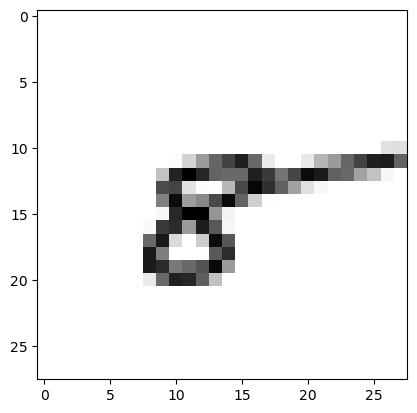


Image number 8416 wrongly identified: I guessed a 1, but it's a 4.


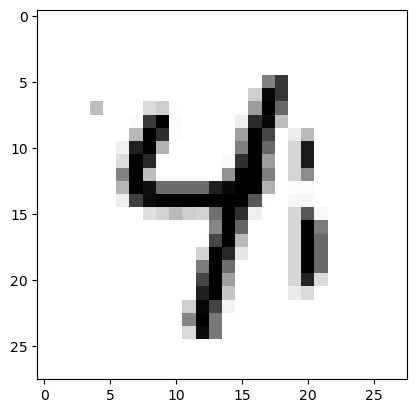


Image number 8520 wrongly identified: I guessed a 9, but it's a 4.


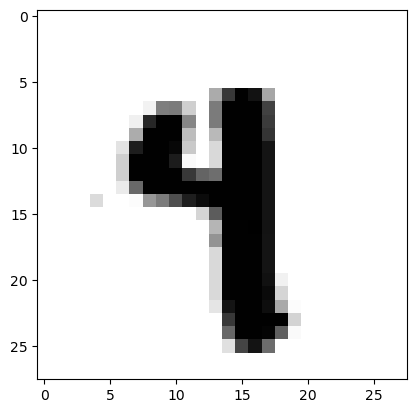


Image number 8527 wrongly identified: I guessed a 9, but it's a 4.


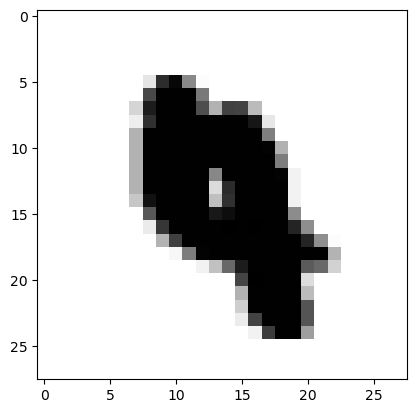


Image number 9009 wrongly identified: I guessed a 2, but it's a 7.


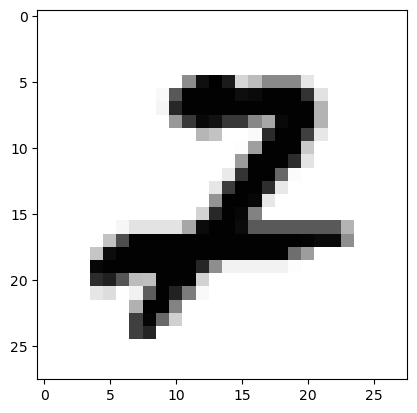


Image number 9015 wrongly identified: I guessed a 2, but it's a 7.


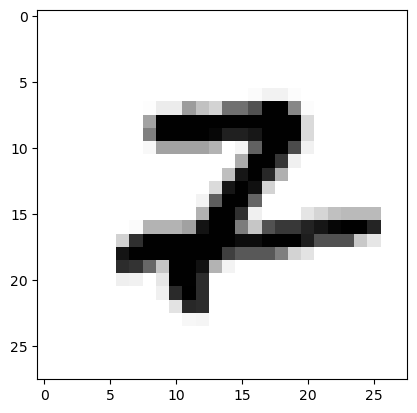


Image number 9024 wrongly identified: I guessed a 2, but it's a 7.


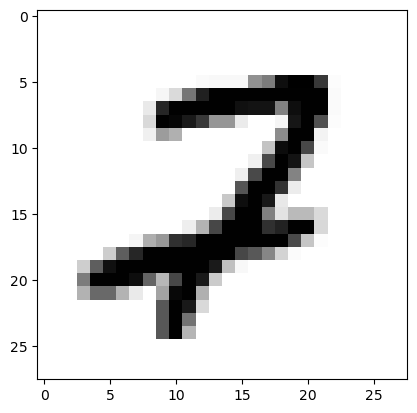


Image number 9280 wrongly identified: I guessed a 5, but it's a 8.


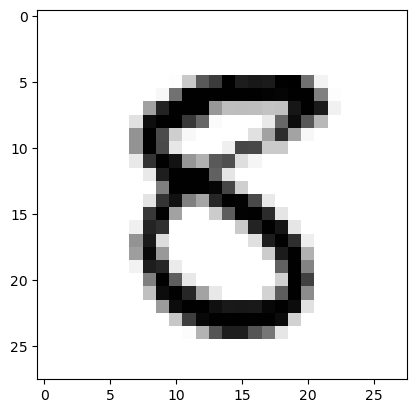


Image number 9544 wrongly identified: I guessed a 7, but it's a 9.


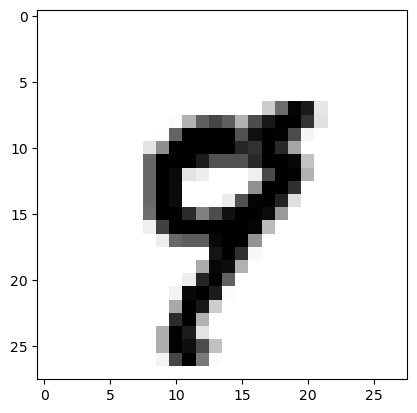


Image number 9613 wrongly identified: I guessed a 1, but it's a 2.


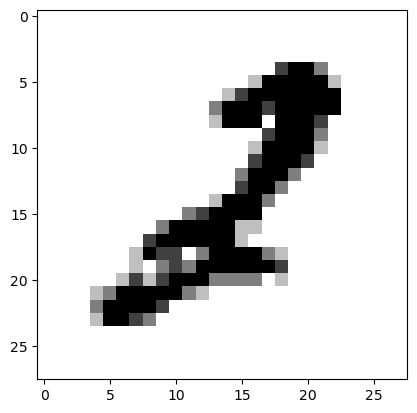


Image number 9624 wrongly identified: I guessed a 8, but it's a 3.


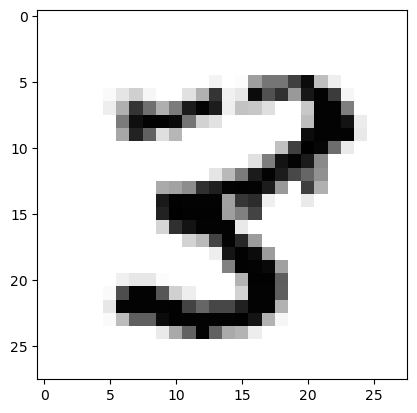


Image number 9634 wrongly identified: I guessed a 1, but it's a 0.


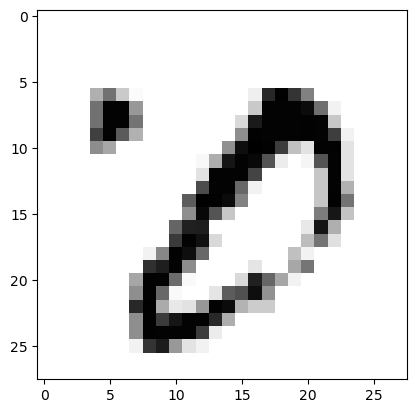


Image number 9642 wrongly identified: I guessed a 7, but it's a 9.


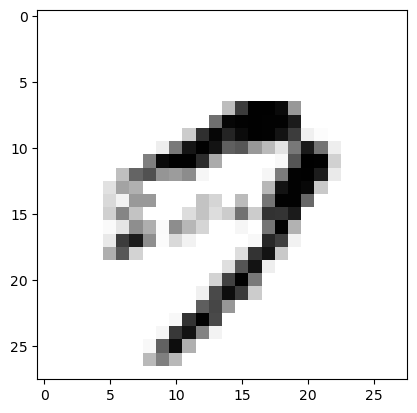


Image number 9655 wrongly identified: I guessed a 5, but it's a 3.


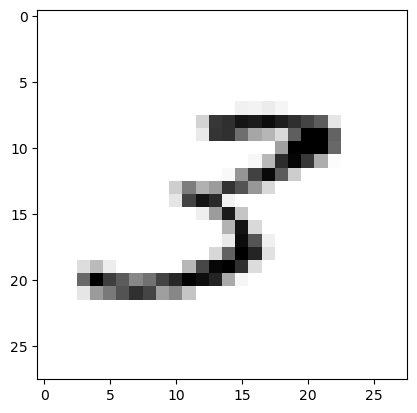


Image number 9664 wrongly identified: I guessed a 7, but it's a 2.


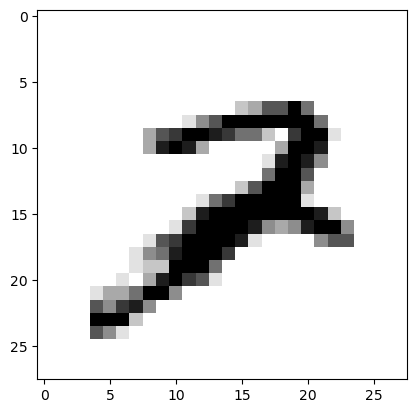


Image number 9686 wrongly identified: I guessed a 1, but it's a 2.


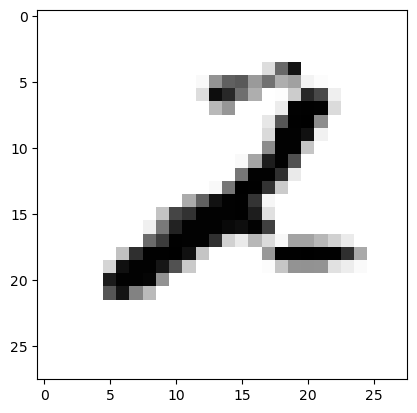


Image number 9719 wrongly identified: I guessed a 0, but it's a 5.


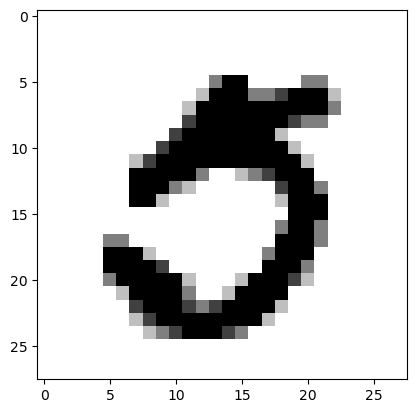


Image number 9729 wrongly identified: I guessed a 6, but it's a 5.


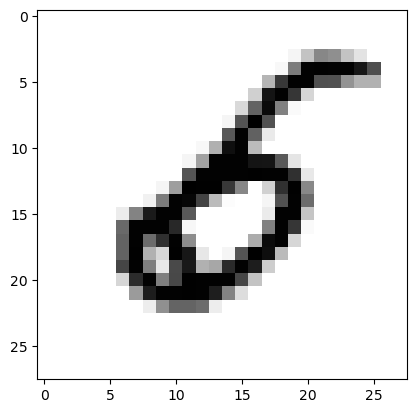


Image number 9741 wrongly identified: I guessed a 7, but it's a 9.


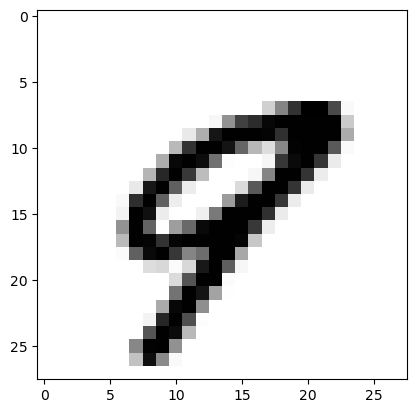


Image number 9745 wrongly identified: I guessed a 0, but it's a 4.


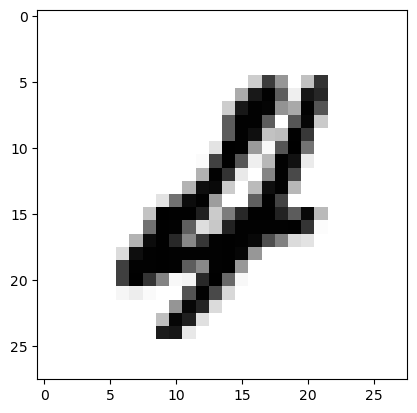


Image number 9751 wrongly identified: I guessed a 0, but it's a 2.


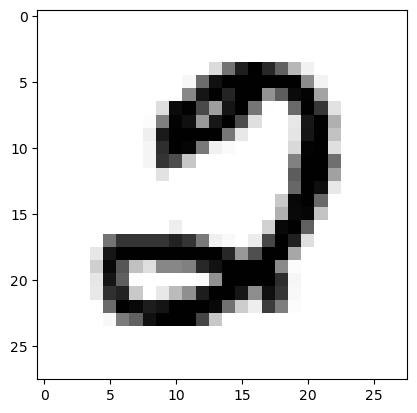


Image number 9768 wrongly identified: I guessed a 0, but it's a 2.


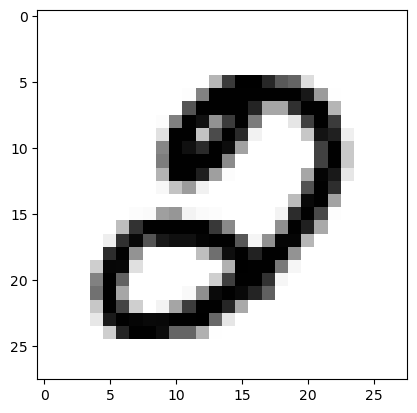


Image number 9770 wrongly identified: I guessed a 0, but it's a 5.


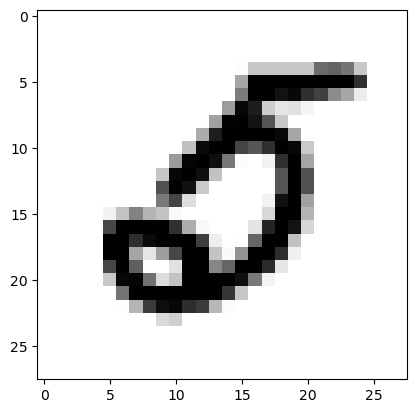


Image number 9779 wrongly identified: I guessed a 0, but it's a 2.


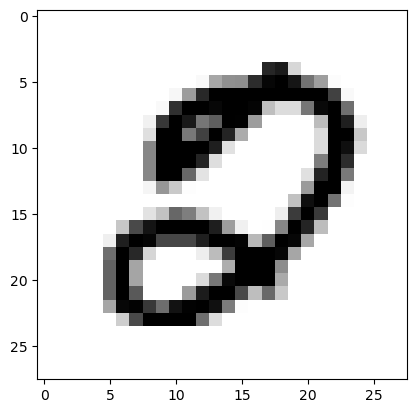


Image number 9808 wrongly identified: I guessed a 4, but it's a 9.


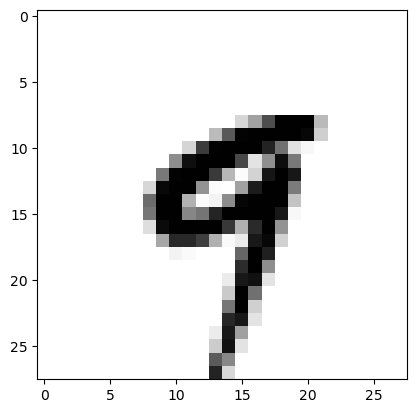


Image number 9811 wrongly identified: I guessed a 8, but it's a 2.


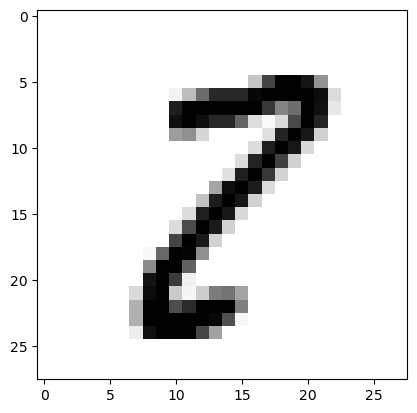


Image number 9839 wrongly identified: I guessed a 7, but it's a 2.


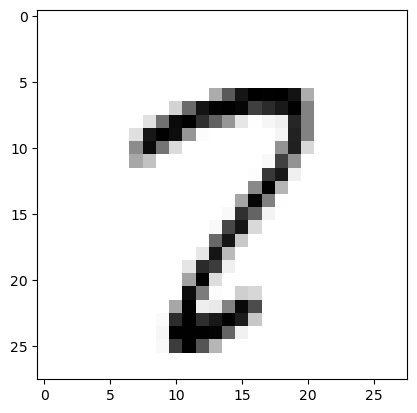


Image number 9867 wrongly identified: I guessed a 8, but it's a 2.


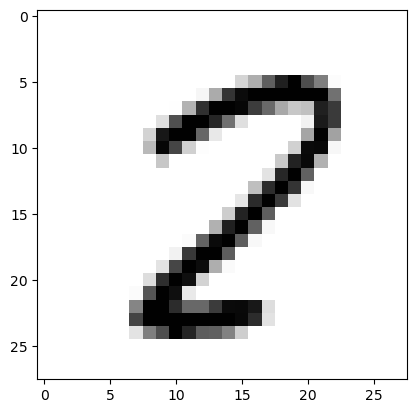


Image number 9875 wrongly identified: I guessed a 5, but it's a 8.


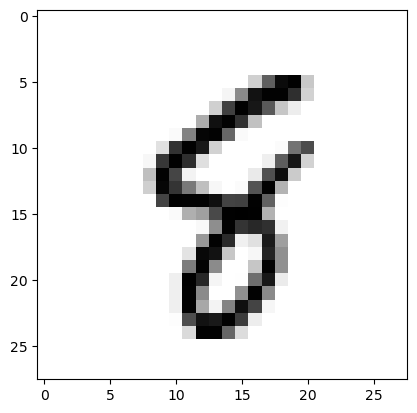


Image number 9879 wrongly identified: I guessed a 6, but it's a 0.


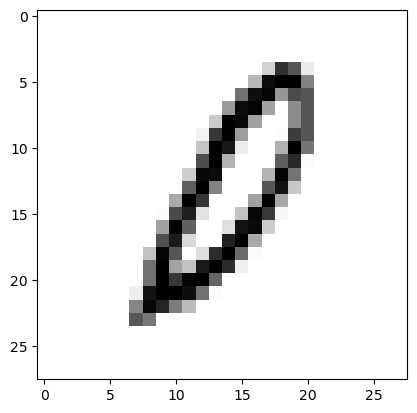


Image number 9883 wrongly identified: I guessed a 6, but it's a 5.


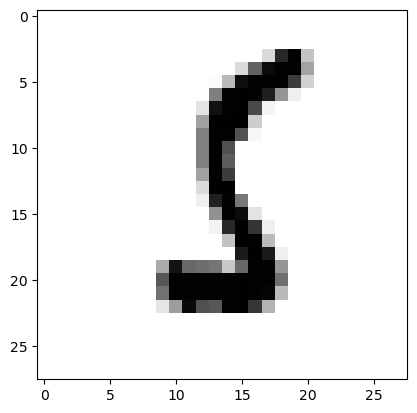


Image number 9892 wrongly identified: I guessed a 5, but it's a 8.


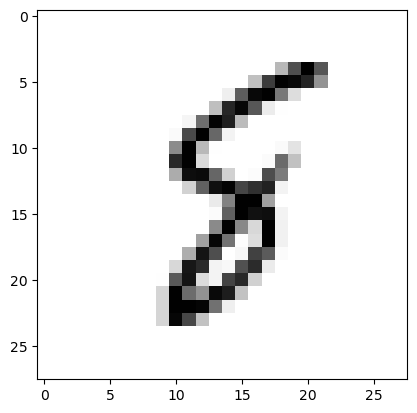


Image number 9904 wrongly identified: I guessed a 0, but it's a 2.


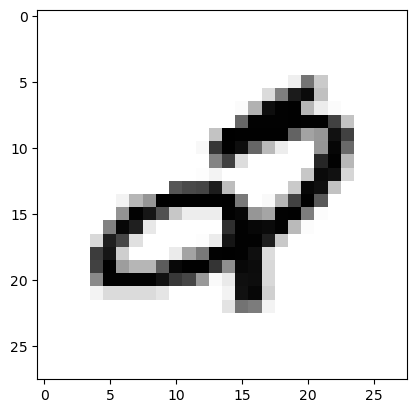


Image number 9905 wrongly identified: I guessed a 9, but it's a 3.


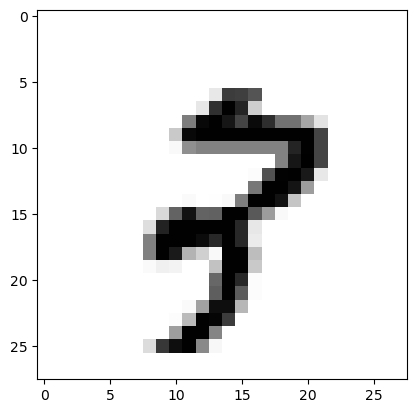


Image number 9944 wrongly identified: I guessed a 5, but it's a 3.


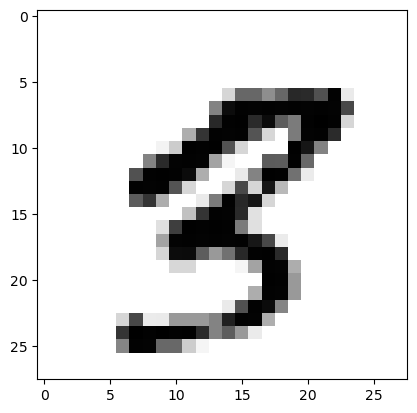


Image number 9982 wrongly identified: I guessed a 6, but it's a 5.


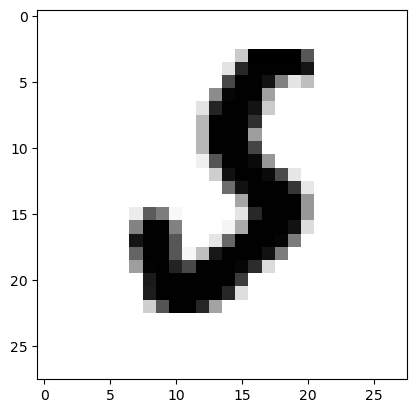

There were 332 errors out of 10000 images.
CPU times: user 1h 20min 3s, sys: 47.2 s, total: 1h 20min 50s
Wall time: 1h 9min 25s


In [27]:
%%time
errors = 0
for n in range(10_000):
    errors += check(n, 7)
print(f'There were {errors} errors out of 10000 images.')